<a href="https://colab.research.google.com/github/gokmenkilic/ML-Intro/blob/gk%2Ftests/Healthcare_Finding_Salient_Features_in_Chemicals_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Autoencoder and Variational Autoencoder feature extraction for Regression in Equilibrium Astrochemistry

In this notebook, we attempt to build an autoencoder and a regression model to extract important features from chemical abundances and use encodered features to predict gas temeperature and chemical abundances times serieses.

Since most gas cooling in astrophysical contexts comes from molecules radiating energy away, their abundances essentially set the cooling rate. Since the temperature affects how the gas evolves dynamically, any physics simulation of processes such as star formation requires a method of accurately calculating the chemistry of the gas.

Unfortunately, accurately calculating the temperature and chemistry (henceforth thermochemistry) of a gas can be computationally expensive. Many approaches such as simplifying chemical networks to only the most important species and reactions or assuming equilibrium are used to decrease the cost of these calculations. However, even these can fail for large simulations where an object is broken up into many parts which all require a thermochemical calculation.

The aim of this work is to use Autoencoders and Variational autoencoders for feature extraction and then to solve the chemistry and gas temperature with sufficient accuracy and speed to render a host of new problems attainable.

In [1]:
# tensorflow
from tensorflow.keras.layers import Input, Dense, Multiply, Add
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# check version
print('Using TensorFlow v%s' % tf.__version__)
acc_str = 'accuracy' if tf.__version__[:2] == '2.' else 'acc'

# helpers
import os
import urllib.request
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
import seaborn as sns
from glob import glob
from tqdm import tqdm

# need some certainty in data processing
np.random.seed(1234)
tf.random.set_seed(1234)


Using TensorFlow v2.19.0


## Data Setup & Google Colab Environment

The dataset is hosted publicly by DiRAC on COSMA. **Please make sure you run the cell below to download the data.**

To access the data from COSMA, you need to:

1. Run the first cell;
2. It will create a folder called sciml-workshop-data.
3. It will download the necessary HDF5 files directly into that folder.
4. Run the second cell and wait until the data folder appears.

If everything works correctly, a new folder called `sciml-workshop-data` should appear in the file browser on the left. Depending on the network speed, this may take one or two minutes. Ignore the warning "You do not appear to have access to project ...". If you are running the notebook locally or you have already connected to the bucket, these cells will have no side effects.

In [2]:
# data setup configuration
data_path = 'sciml-workshop-data'
full_dir = os.path.join(data_path, 'NHS')
os.makedirs(full_dir, exist_ok=True)

base_url = "https://virgodb.cosma.dur.ac.uk/public/dc-kili1/sciml-workshop-data/NHS/"
files_to_download = ["small_chemulator_dataset_train.hdf","small_chemulator_dataset_test.hdf"]

In [3]:
for filename in files_to_download:
    path = os.path.join(full_dir, filename)

    if not os.path.exists(path):
        urllib.request.urlretrieve(base_url + filename, path)

---

# 1. Load the dataset

### Read raw data

We start by loading the dataset taken from [Chemulator - Holdship et al. 2020](https://ui.adsabs.harvard.edu/abs/2021A%26A...653A..76H/abstract).

The full **Chemulator** dataset contains the abundances and physical parameters as a function of time when exposed to different conditions. The physical parameters are:
- Gas temperature
- Gas density
- Radation Field
- Local cosmic ray ionization rate
- Ratio of the abundance of metals in this gas to the sollar abundance of metal
- Total Column density
- $H_2$ Column density
- $C$ Column density

and the abundances are:

'H','H+', 'H2', 'H2+', 'H3+', 'HE', 'HE+', 'C+', 'C', 'CH', 'CH+', 'CH2', 'CH2+', 'CH3+', 'CH3', 'CH4+', 'O+', 'CH4', 'O', 'CH5+', 'OH+', 'OH', 'H2O+', 'H2O', 'H3O+', 'MG', 'MG+', 'CO+', 'CO', 'HCO+', 'O2', 'O2+','E-'

The data are stored in the hdf file 'NHS/small_chemulator_dataset_train.hdf' and 'NHS/small_chemulator_dataset_test.hdf'.


**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
train_data = pd.read_hdf(join(data_path, 'NHS/small_chemulator_dataset_train.hdf'), 'df')  
test_data = pd.read_hdf(join(data_path, 'NHS/small_chemulator_dataset_test.hdf'), 'df')  
```
    
</p>
</details>


In [4]:
train_data = pd.read_hdf(join(data_path, 'NHS/small_chemulator_dataset_train.hdf'), 'df')
test_data = pd.read_hdf(join(data_path, 'NHS/small_chemulator_dataset_test.hdf'), 'df')

In [5]:
class Scale_info:
    def __init__(self, data):
        self.min = np.min(data, axis = 0)
        self.max = np.max(data, axis = 0)

def preprocessing(df, data_type = 'chemical'):
    arr = df.copy()
    arr = np.log10(arr)
    if data_type == 'chemical':
        arr=np.where(arr<-20,-20,arr)
    arr = arr.astype(np.float32)
    reliable_min = np.percentile(arr, 2, axis =0)
    reliable_max = np.percentile(arr, 98, axis =0)

    arr = (arr - reliable_min)/(reliable_max - reliable_min)
    arr = np.clip(arr, 0., 1.)

    return arr # array

abundances = ['H','H+', 'H2', 'H2+', 'H3+', 'HE', 'HE+', 'C+', 'C', 'CH', 'CH+', 'CH2',
       'CH2+', 'CH3+', 'CH3', 'CH4+', 'O+', 'CH4', 'O', 'CH5+', 'OH+', 'OH',
       'H2O+', 'H2O', 'H3O+', 'MG', 'MG+', 'CO+', 'CO', 'HCO+', 'O2', 'O2+','E-']


### Preprocessing chemical abundances
train_data['HE'] = 0.1*train_data['metallicity']
chemical_abundances = train_data[abundances]
chemical_abundances = preprocessing(chemical_abundances, data_type = 'chemical')
train_data[abundances] = chemical_abundances

test_data['HE'] = 0.1*test_data['metallicity']
chemical_abundances_test = test_data[abundances]
chemical_abundances_test = preprocessing(chemical_abundances_test, data_type = 'chemical')
test_data[abundances] = chemical_abundances_test


### Preprocessing physical parameters
physics_labels=['gas_temp','gas_density','radfield','zeta','coldens','h2col','ccol',"metallicity"]
train_data[physics_labels] = preprocessing(train_data[physics_labels], data_type = 'physical')
test_data[physics_labels] = preprocessing(test_data[physics_labels], data_type = 'physical')

In [6]:
train_all = np.array(train_data[physics_labels + abundances])[:-1]
train_all_target = np.array(train_data[['gas_temp']+abundances])[1:]
test_all = np.array(test_data[physics_labels + abundances])[:-1]
test_all_target = np.array(test_data[['gas_temp']+abundances])[1:]

print(train_all.shape)
print(train_all_target.shape)
print(test_all.shape)
print(test_all_target.shape)

(1999999, 41)
(1999999, 34)
(399999, 41)
(399999, 34)


---

# 2. Build the network

### Regression using all abundances


**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
model_all = Sequential()
model_all.add(Input(shape=(train_all.shape[1],)))

for layer in [256, 256]:
    model_all.add(Dense(layer, activation="relu"))

model_all.add(Dense(1+len(abundances),activation='sigmoid'))        

model_all.compile(loss="mse", optimizer='adam')

stopper=EarlyStopping( monitor ="val_loss", min_delta=0.0,verbose=1,
                      mode="min",
                      restore_best_weights=True,patience=2)
history_all = model_all.fit(train_all, train_all_target, epochs=5, batch_size=128,
                             validation_data = (test_all, test_all_target) ,callbacks=[stopper])
```
    
</p>
</details>

In [7]:
model_all = Sequential()
model_all.add(Input(shape=(train_all.shape[1],)))

for layer in [256, 256]:
    model_all.add(Dense(layer, activation="relu"))

model_all.add(Dense(1+len(abundances),activation='sigmoid'))

model_all.compile(loss="mse", optimizer='adam')

stopper=EarlyStopping( monitor ="val_loss", min_delta=0.0,verbose=1,
                      mode="min",
                      restore_best_weights=True,patience=2)
history_all = model_all.fit(train_all, train_all_target, epochs=5, batch_size=128,
                             validation_data = (test_all, test_all_target) ,callbacks=[stopper])

Epoch 1/5
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - loss: 0.0016 - val_loss: 5.2027e-04
Epoch 2/5
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - loss: 3.1540e-04 - val_loss: 4.4152e-04
Epoch 3/5
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 2.8291e-04 - val_loss: 4.2089e-04
Epoch 4/5
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - loss: 2.6675e-04 - val_loss: 4.0858e-04
Epoch 5/5
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - loss: 2.5679e-04 - val_loss: 4.0087e-04
Restoring model weights from the end of the best epoch: 5.


---

# 3. Analyse results

### Take a look at some results

Using predict_multiple_timesteps function we can predict abundances and gas temperature time series from their initial valeus.

In [8]:
def predict_multiple_timesteps(model, init_condition, time = 999):
    x = init_condition.copy()
    predictions = [x.copy()]
    for i in tqdm(range(time)):
        pred = model.predict(x)
        x[:, 0] = pred[:, 0]
        x[:, len(physics_labels):] = pred[:, 1:]
        predictions.append(x.copy())
    return predictions

### Predict multiple timesteps

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
init_idx = 0
init_condition = train_all[init_idx:init_idx+1]
pred_all = predict_multiple_timesteps(model_all, init_condition, time = 999)

pred_all = np.stack(pred_all).reshape(1000, train_all.shape[1])
```
    
</p>
</details>

In [9]:
init_idx = 0
init_condition = train_all[init_idx:init_idx+1]
pred_all = predict_multiple_timesteps(model_all, init_condition, time = 999)

pred_all = np.stack(pred_all).reshape(1000, train_all.shape[1])

  0%|          | 0/999 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


  0%|          | 1/999 [00:00<04:58,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  0%|          | 3/999 [00:00<02:04,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  1%|          | 5/999 [00:00<01:29, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  1%|          | 7/999 [00:00<01:15, 13.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  1%|          | 9/999 [00:00<01:31, 10.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  1%|          | 11/999 [00:01<01:27, 11.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  1%|▏         | 13/999 [00:01<01:38,  9.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  2%|▏         | 15/999 [00:01<01:32, 10.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  2%|▏         | 17/999 [00:01<01:33, 10.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  2%|▏         | 19/999 [00:01<01:39,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  2%|▏         | 21/999 [00:02<01:46,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  2%|▏         | 23/999 [00:02<01:41,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  3%|▎         | 25/999 [00:02<01:42,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  3%|▎         | 27/999 [00:02<01:31, 10.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  3%|▎         | 29/999 [00:02<01:20, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  3%|▎         | 31/999 [00:02<01:12, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  3%|▎         | 33/999 [00:03<01:08, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  4%|▎         | 35/999 [00:03<01:04, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  4%|▎         | 37/999 [00:03<01:03, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  4%|▍         | 39/999 [00:03<01:01, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


  4%|▍         | 41/999 [00:03<00:59, 16.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  4%|▍         | 43/999 [00:03<00:58, 16.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  5%|▍         | 45/999 [00:03<00:58, 16.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  5%|▍         | 47/999 [00:03<00:57, 16.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  5%|▍         | 49/999 [00:03<00:57, 16.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  5%|▌         | 51/999 [00:04<00:56, 16.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  5%|▌         | 53/999 [00:04<01:02, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  6%|▌         | 55/999 [00:04<01:00, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  6%|▌         | 57/999 [00:04<00:59, 15.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  6%|▌         | 59/999 [00:04<00:58, 16.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  6%|▌         | 61/999 [00:04<00:57, 16.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  6%|▋         | 63/999 [00:04<00:58, 16.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  7%|▋         | 65/999 [00:04<00:57, 16.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  7%|▋         | 67/999 [00:05<00:56, 16.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  7%|▋         | 69/999 [00:05<00:56, 16.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  7%|▋         | 71/999 [00:05<00:58, 15.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  7%|▋         | 73/999 [00:05<00:56, 16.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  8%|▊         | 75/999 [00:05<00:55, 16.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  8%|▊         | 77/999 [00:05<00:55, 16.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  8%|▊         | 79/999 [00:05<00:55, 16.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  8%|▊         | 81/999 [00:05<00:56, 16.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  8%|▊         | 83/999 [00:06<00:56, 16.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  9%|▊         | 85/999 [00:06<00:55, 16.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  9%|▊         | 87/999 [00:06<00:57, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  9%|▉         | 89/999 [00:06<00:56, 16.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  9%|▉         | 91/999 [00:06<00:55, 16.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  9%|▉         | 93/999 [00:06<00:55, 16.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 10%|▉         | 95/999 [00:06<00:55, 16.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 10%|▉         | 97/999 [00:06<00:54, 16.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 10%|▉         | 99/999 [00:07<00:54, 16.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 10%|█         | 101/999 [00:07<00:54, 16.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 10%|█         | 103/999 [00:07<00:54, 16.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 11%|█         | 105/999 [00:07<00:55, 16.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 11%|█         | 107/999 [00:07<00:54, 16.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 11%|█         | 109/999 [00:07<00:54, 16.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 11%|█         | 111/999 [00:07<00:53, 16.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 11%|█▏        | 113/999 [00:07<00:53, 16.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 12%|█▏        | 115/999 [00:08<00:52, 16.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 12%|█▏        | 117/999 [00:08<00:53, 16.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 12%|█▏        | 119/999 [00:08<00:53, 16.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 12%|█▏        | 121/999 [00:08<00:55, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 12%|█▏        | 123/999 [00:08<00:54, 16.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 13%|█▎        | 125/999 [00:08<00:53, 16.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 13%|█▎        | 127/999 [00:08<00:52, 16.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 13%|█▎        | 129/999 [00:08<00:53, 16.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 13%|█▎        | 131/999 [00:09<00:53, 16.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 13%|█▎        | 133/999 [00:09<00:52, 16.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 14%|█▎        | 135/999 [00:09<00:51, 16.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 14%|█▎        | 137/999 [00:09<00:52, 16.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 14%|█▍        | 139/999 [00:09<00:52, 16.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 14%|█▍        | 141/999 [00:09<01:17, 11.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 14%|█▍        | 143/999 [00:09<01:09, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 15%|█▍        | 145/999 [00:10<01:03, 13.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 15%|█▍        | 147/999 [00:10<00:59, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 15%|█▍        | 149/999 [00:10<00:56, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 15%|█▌        | 151/999 [00:10<00:55, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 15%|█▌        | 153/999 [00:10<00:54, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 16%|█▌        | 155/999 [00:10<00:53, 15.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 16%|█▌        | 157/999 [00:10<00:52, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 16%|█▌        | 159/999 [00:10<00:52, 16.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 16%|█▌        | 161/999 [00:11<00:51, 16.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 16%|█▋        | 163/999 [00:11<00:50, 16.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 17%|█▋        | 165/999 [00:11<00:50, 16.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 17%|█▋        | 167/999 [00:11<00:51, 16.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 17%|█▋        | 169/999 [00:11<00:51, 16.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 17%|█▋        | 171/999 [00:11<00:51, 16.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 17%|█▋        | 173/999 [00:11<00:50, 16.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 18%|█▊        | 175/999 [00:11<00:49, 16.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 18%|█▊        | 177/999 [00:12<00:51, 16.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 18%|█▊        | 179/999 [00:12<00:50, 16.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 18%|█▊        | 181/999 [00:12<00:50, 16.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 18%|█▊        | 183/999 [00:12<00:49, 16.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 19%|█▊        | 185/999 [00:12<00:50, 16.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 19%|█▊        | 187/999 [00:12<00:52, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 19%|█▉        | 189/999 [00:12<01:03, 12.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 19%|█▉        | 191/999 [00:13<01:09, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 19%|█▉        | 193/999 [00:13<01:12, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 20%|█▉        | 195/999 [00:13<01:15, 10.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 20%|█▉        | 197/999 [00:13<01:14, 10.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 20%|█▉        | 199/999 [00:13<01:19, 10.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 20%|██        | 201/999 [00:14<01:18, 10.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 20%|██        | 203/999 [00:14<01:16, 10.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 21%|██        | 205/999 [00:14<01:23,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 21%|██        | 207/999 [00:14<01:14, 10.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 21%|██        | 209/999 [00:14<01:06, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 21%|██        | 211/999 [00:14<01:00, 13.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 21%|██▏       | 213/999 [00:15<00:58, 13.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 22%|██▏       | 215/999 [00:15<00:54, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 22%|██▏       | 217/999 [00:15<00:52, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 22%|██▏       | 219/999 [00:15<00:51, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 22%|██▏       | 221/999 [00:15<00:49, 15.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 22%|██▏       | 223/999 [00:15<00:54, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 23%|██▎       | 225/999 [00:15<00:54, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 23%|██▎       | 227/999 [00:15<00:53, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 23%|██▎       | 229/999 [00:16<00:51, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 23%|██▎       | 231/999 [00:16<00:49, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 23%|██▎       | 233/999 [00:16<00:49, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 24%|██▎       | 235/999 [00:16<00:48, 15.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 24%|██▎       | 237/999 [00:16<00:48, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 24%|██▍       | 239/999 [00:16<00:49, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 24%|██▍       | 241/999 [00:16<00:48, 15.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 24%|██▍       | 243/999 [00:16<00:47, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 25%|██▍       | 245/999 [00:17<00:47, 15.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 25%|██▍       | 247/999 [00:17<00:46, 16.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 25%|██▍       | 249/999 [00:17<00:47, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 25%|██▌       | 251/999 [00:17<00:47, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 25%|██▌       | 253/999 [00:17<00:46, 15.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 26%|██▌       | 255/999 [00:17<00:51, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 26%|██▌       | 257/999 [00:17<00:49, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 26%|██▌       | 259/999 [00:18<00:48, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 26%|██▌       | 261/999 [00:18<00:47, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 26%|██▋       | 263/999 [00:18<00:47, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 27%|██▋       | 265/999 [00:18<00:46, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 27%|██▋       | 267/999 [00:18<00:46, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 27%|██▋       | 269/999 [00:18<00:45, 16.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 27%|██▋       | 271/999 [00:18<00:50, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 27%|██▋       | 273/999 [00:18<00:48, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 28%|██▊       | 275/999 [00:19<00:48, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 28%|██▊       | 277/999 [00:19<00:46, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 28%|██▊       | 279/999 [00:19<00:45, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 28%|██▊       | 281/999 [00:19<00:45, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 28%|██▊       | 283/999 [00:19<00:44, 16.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 29%|██▊       | 285/999 [00:19<00:44, 15.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 29%|██▊       | 287/999 [00:19<00:45, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 29%|██▉       | 289/999 [00:19<00:45, 15.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 29%|██▉       | 291/999 [00:20<00:45, 15.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 29%|██▉       | 293/999 [00:20<00:44, 15.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 30%|██▉       | 295/999 [00:20<00:43, 16.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 30%|██▉       | 297/999 [00:20<00:46, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 30%|██▉       | 299/999 [00:20<00:46, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 30%|███       | 301/999 [00:20<00:45, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 30%|███       | 303/999 [00:20<00:45, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 31%|███       | 305/999 [00:20<00:45, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 31%|███       | 307/999 [00:21<00:44, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 31%|███       | 309/999 [00:21<00:44, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 31%|███       | 311/999 [00:21<00:44, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 31%|███▏      | 313/999 [00:21<00:43, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 32%|███▏      | 315/999 [00:21<00:42, 15.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 32%|███▏      | 317/999 [00:21<00:42, 16.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 32%|███▏      | 319/999 [00:21<00:46, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 32%|███▏      | 321/999 [00:22<00:45, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 32%|███▏      | 323/999 [00:22<00:44, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 33%|███▎      | 325/999 [00:22<00:43, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 33%|███▎      | 327/999 [00:22<00:43, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 33%|███▎      | 329/999 [00:22<00:42, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 33%|███▎      | 331/999 [00:22<00:42, 15.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 33%|███▎      | 333/999 [00:22<00:42, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 34%|███▎      | 335/999 [00:22<00:43, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 34%|███▎      | 337/999 [00:23<00:42, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 34%|███▍      | 339/999 [00:23<00:42, 15.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 34%|███▍      | 341/999 [00:23<00:41, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 34%|███▍      | 343/999 [00:23<00:41, 15.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 35%|███▍      | 345/999 [00:23<00:41, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 35%|███▍      | 347/999 [00:23<00:41, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 35%|███▍      | 349/999 [00:23<00:41, 15.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 35%|███▌      | 351/999 [00:23<00:45, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 35%|███▌      | 353/999 [00:24<00:43, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 36%|███▌      | 355/999 [00:24<00:42, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 36%|███▌      | 357/999 [00:24<00:42, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 36%|███▌      | 359/999 [00:24<00:41, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 36%|███▌      | 361/999 [00:24<00:47, 13.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 36%|███▋      | 363/999 [00:24<00:56, 11.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 37%|███▋      | 365/999 [00:25<01:02, 10.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 37%|███▋      | 367/999 [00:25<00:59, 10.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 37%|███▋      | 369/999 [00:25<01:04,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 37%|███▋      | 371/999 [00:25<01:02, 10.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 37%|███▋      | 373/999 [00:25<01:01, 10.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 38%|███▊      | 375/999 [00:26<01:00, 10.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 38%|███▊      | 377/999 [00:26<00:59, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 38%|███▊      | 379/999 [00:26<01:05,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 38%|███▊      | 381/999 [00:26<00:57, 10.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 38%|███▊      | 383/999 [00:26<00:51, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 39%|███▊      | 385/999 [00:26<00:47, 12.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 39%|███▊      | 387/999 [00:27<00:46, 13.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 39%|███▉      | 389/999 [00:27<00:43, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 39%|███▉      | 391/999 [00:27<00:42, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 39%|███▉      | 393/999 [00:27<00:41, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 40%|███▉      | 395/999 [00:27<00:40, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 40%|███▉      | 397/999 [00:27<00:39, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 40%|███▉      | 399/999 [00:27<00:39, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 40%|████      | 401/999 [00:27<00:38, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 40%|████      | 403/999 [00:28<00:39, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 41%|████      | 405/999 [00:28<00:38, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 41%|████      | 407/999 [00:28<00:39, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 41%|████      | 409/999 [00:28<00:38, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 41%|████      | 411/999 [00:28<00:38, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 41%|████▏     | 413/999 [00:28<00:37, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 42%|████▏     | 415/999 [00:28<00:38, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 42%|████▏     | 417/999 [00:29<00:38, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 42%|████▏     | 419/999 [00:29<00:38, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 42%|████▏     | 421/999 [00:29<00:38, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 42%|████▏     | 423/999 [00:29<00:38, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 43%|████▎     | 425/999 [00:29<00:37, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 43%|████▎     | 427/999 [00:29<00:36, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 43%|████▎     | 429/999 [00:29<00:36, 15.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 43%|████▎     | 431/999 [00:29<00:36, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 43%|████▎     | 433/999 [00:30<00:35, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 44%|████▎     | 435/999 [00:30<00:36, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 44%|████▎     | 437/999 [00:30<00:35, 15.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 44%|████▍     | 439/999 [00:30<00:35, 15.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 44%|████▍     | 441/999 [00:30<00:35, 15.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 44%|████▍     | 443/999 [00:30<00:35, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 45%|████▍     | 445/999 [00:30<00:35, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 45%|████▍     | 447/999 [00:30<00:35, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 45%|████▍     | 449/999 [00:31<00:35, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 45%|████▌     | 451/999 [00:31<00:35, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 45%|████▌     | 453/999 [00:31<00:35, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 46%|████▌     | 455/999 [00:31<00:35, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 46%|████▌     | 457/999 [00:31<00:35, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 46%|████▌     | 459/999 [00:31<00:35, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 46%|████▌     | 461/999 [00:31<00:34, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 46%|████▋     | 463/999 [00:32<00:37, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 47%|████▋     | 465/999 [00:32<00:37, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 47%|████▋     | 467/999 [00:32<00:36, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 47%|████▋     | 469/999 [00:32<00:35, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 47%|████▋     | 471/999 [00:32<00:35, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 47%|████▋     | 473/999 [00:32<00:34, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 48%|████▊     | 475/999 [00:32<00:33, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 48%|████▊     | 477/999 [00:32<00:34, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 48%|████▊     | 479/999 [00:33<00:34, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 48%|████▊     | 481/999 [00:33<00:35, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 48%|████▊     | 483/999 [00:33<00:34, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 49%|████▊     | 485/999 [00:33<00:33, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 49%|████▊     | 487/999 [00:33<00:33, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 49%|████▉     | 489/999 [00:33<00:33, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 49%|████▉     | 491/999 [00:33<00:33, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 49%|████▉     | 493/999 [00:34<00:33, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 50%|████▉     | 495/999 [00:34<00:32, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 50%|████▉     | 497/999 [00:34<00:36, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 50%|████▉     | 499/999 [00:34<00:35, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 50%|█████     | 501/999 [00:34<00:34, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 50%|█████     | 503/999 [00:34<00:33, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 51%|█████     | 505/999 [00:34<00:33, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 51%|█████     | 507/999 [00:34<00:32, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 51%|█████     | 509/999 [00:35<00:32, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 51%|█████     | 511/999 [00:35<00:34, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 51%|█████▏    | 513/999 [00:35<00:34, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 52%|█████▏    | 515/999 [00:35<00:33, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 52%|█████▏    | 517/999 [00:35<00:32, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 52%|█████▏    | 519/999 [00:35<00:32, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 52%|█████▏    | 521/999 [00:35<00:31, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 52%|█████▏    | 523/999 [00:36<00:31, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 53%|█████▎    | 525/999 [00:36<00:31, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 53%|█████▎    | 527/999 [00:36<00:32, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 53%|█████▎    | 529/999 [00:36<00:31, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 53%|█████▎    | 531/999 [00:36<00:36, 12.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 53%|█████▎    | 533/999 [00:36<00:38, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 54%|█████▎    | 535/999 [00:37<00:43, 10.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 54%|█████▍    | 537/999 [00:37<00:45, 10.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 54%|█████▍    | 539/999 [00:37<00:43, 10.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 54%|█████▍    | 541/999 [00:37<00:42, 10.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 54%|█████▍    | 543/999 [00:37<00:44, 10.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 55%|█████▍    | 545/999 [00:38<00:43, 10.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 55%|█████▍    | 547/999 [00:38<00:45,  9.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 55%|█████▍    | 549/999 [00:38<00:45,  9.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 55%|█████▌    | 550/999 [00:38<00:45,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 55%|█████▌    | 552/999 [00:38<00:40, 11.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 55%|█████▌    | 554/999 [00:38<00:36, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 56%|█████▌    | 556/999 [00:39<00:34, 13.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 56%|█████▌    | 558/999 [00:39<00:32, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 56%|█████▌    | 560/999 [00:39<00:30, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 56%|█████▋    | 562/999 [00:39<00:33, 12.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 56%|█████▋    | 564/999 [00:39<00:31, 13.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 57%|█████▋    | 566/999 [00:39<00:30, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 57%|█████▋    | 568/999 [00:39<00:30, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 57%|█████▋    | 570/999 [00:39<00:29, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 57%|█████▋    | 572/999 [00:40<00:28, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 57%|█████▋    | 574/999 [00:40<00:28, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 58%|█████▊    | 576/999 [00:40<00:28, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 58%|█████▊    | 578/999 [00:40<00:28, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 58%|█████▊    | 580/999 [00:40<00:28, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 58%|█████▊    | 582/999 [00:40<00:27, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 58%|█████▊    | 584/999 [00:40<00:27, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 59%|█████▊    | 586/999 [00:41<00:27, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 59%|█████▉    | 588/999 [00:41<00:28, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 59%|█████▉    | 590/999 [00:41<00:28, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 59%|█████▉    | 592/999 [00:41<00:28, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 59%|█████▉    | 594/999 [00:41<00:27, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 60%|█████▉    | 596/999 [00:41<00:27, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 60%|█████▉    | 598/999 [00:41<00:27, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 60%|██████    | 600/999 [00:42<00:27, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 60%|██████    | 602/999 [00:42<00:26, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 60%|██████    | 604/999 [00:42<00:26, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 61%|██████    | 606/999 [00:42<00:26, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 61%|██████    | 608/999 [00:42<00:26, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 61%|██████    | 610/999 [00:42<00:26, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 61%|██████▏   | 612/999 [00:42<00:25, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 61%|██████▏   | 614/999 [00:42<00:25, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 62%|██████▏   | 616/999 [00:43<00:25, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 62%|██████▏   | 618/999 [00:43<00:24, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 62%|██████▏   | 620/999 [00:43<00:24, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 62%|██████▏   | 622/999 [00:43<00:24, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 62%|██████▏   | 624/999 [00:43<00:25, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 63%|██████▎   | 626/999 [00:43<00:24, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 63%|██████▎   | 628/999 [00:43<00:24, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 63%|██████▎   | 630/999 [00:44<00:24, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 63%|██████▎   | 632/999 [00:44<00:24, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 63%|██████▎   | 634/999 [00:44<00:24, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 64%|██████▎   | 636/999 [00:44<00:24, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 64%|██████▍   | 638/999 [00:44<00:24, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 64%|██████▍   | 640/999 [00:44<00:24, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 64%|██████▍   | 642/999 [00:44<00:23, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 64%|██████▍   | 644/999 [00:44<00:23, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 65%|██████▍   | 646/999 [00:45<00:23, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 65%|██████▍   | 648/999 [00:45<00:23, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 65%|██████▌   | 650/999 [00:45<00:23, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 65%|██████▌   | 652/999 [00:45<00:22, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 65%|██████▌   | 654/999 [00:45<00:23, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 66%|██████▌   | 656/999 [00:45<00:23, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 66%|██████▌   | 658/999 [00:45<00:23, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 66%|██████▌   | 660/999 [00:46<00:23, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 66%|██████▋   | 662/999 [00:46<00:22, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 66%|██████▋   | 664/999 [00:46<00:22, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 67%|██████▋   | 666/999 [00:46<00:22, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 67%|██████▋   | 668/999 [00:46<00:21, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 67%|██████▋   | 670/999 [00:46<00:23, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 67%|██████▋   | 672/999 [00:46<00:23, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 67%|██████▋   | 674/999 [00:46<00:22, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 68%|██████▊   | 676/999 [00:47<00:22, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 68%|██████▊   | 678/999 [00:47<00:21, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 68%|██████▊   | 680/999 [00:47<00:21, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 68%|██████▊   | 682/999 [00:47<00:21, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 68%|██████▊   | 684/999 [00:47<00:21, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 69%|██████▊   | 686/999 [00:47<00:21, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 69%|██████▉   | 688/999 [00:47<00:22, 13.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 69%|██████▉   | 690/999 [00:48<00:22, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 69%|██████▉   | 692/999 [00:48<00:21, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 69%|██████▉   | 694/999 [00:48<00:21, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 70%|██████▉   | 696/999 [00:48<00:20, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 70%|██████▉   | 698/999 [00:48<00:21, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 70%|███████   | 700/999 [00:48<00:25, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 70%|███████   | 702/999 [00:49<00:26, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 70%|███████   | 704/999 [00:49<00:27, 10.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 71%|███████   | 706/999 [00:49<00:27, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 71%|███████   | 708/999 [00:49<00:27, 10.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 71%|███████   | 710/999 [00:49<00:28, 10.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 71%|███████▏  | 712/999 [00:50<00:29,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 71%|███████▏  | 713/999 [00:50<00:31,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 72%|███████▏  | 715/999 [00:50<00:30,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 72%|███████▏  | 716/999 [00:50<00:31,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 72%|███████▏  | 717/999 [00:50<00:33,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 72%|███████▏  | 719/999 [00:50<00:30,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 72%|███████▏  | 721/999 [00:51<00:26, 10.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 72%|███████▏  | 723/999 [00:51<00:23, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 73%|███████▎  | 725/999 [00:51<00:21, 12.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 73%|███████▎  | 727/999 [00:51<00:20, 13.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 73%|███████▎  | 729/999 [00:51<00:19, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 73%|███████▎  | 731/999 [00:51<00:19, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 73%|███████▎  | 733/999 [00:51<00:18, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 74%|███████▎  | 735/999 [00:52<00:18, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 74%|███████▍  | 737/999 [00:52<00:19, 13.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 74%|███████▍  | 739/999 [00:52<00:18, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 74%|███████▍  | 741/999 [00:52<00:18, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 74%|███████▍  | 743/999 [00:52<00:17, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 75%|███████▍  | 745/999 [00:52<00:17, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 75%|███████▍  | 747/999 [00:52<00:18, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 75%|███████▍  | 749/999 [00:53<00:17, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 75%|███████▌  | 751/999 [00:53<00:16, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 75%|███████▌  | 753/999 [00:53<00:16, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 76%|███████▌  | 755/999 [00:53<00:16, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 76%|███████▌  | 757/999 [00:53<00:17, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 76%|███████▌  | 759/999 [00:53<00:17, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 76%|███████▌  | 761/999 [00:53<00:16, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 76%|███████▋  | 763/999 [00:54<00:16, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 77%|███████▋  | 765/999 [00:54<00:16, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 77%|███████▋  | 767/999 [00:54<00:15, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 77%|███████▋  | 769/999 [00:54<00:15, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 77%|███████▋  | 771/999 [00:54<00:15, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 77%|███████▋  | 773/999 [00:54<00:15, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 78%|███████▊  | 775/999 [00:54<00:14, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 78%|███████▊  | 777/999 [00:54<00:15, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 78%|███████▊  | 779/999 [00:55<00:15, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 78%|███████▊  | 781/999 [00:55<00:15, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 78%|███████▊  | 783/999 [00:55<00:14, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 79%|███████▊  | 785/999 [00:55<00:14, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 79%|███████▉  | 787/999 [00:55<00:14, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 79%|███████▉  | 789/999 [00:55<00:15, 13.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 79%|███████▉  | 791/999 [00:55<00:14, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 79%|███████▉  | 793/999 [00:56<00:15, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 80%|███████▉  | 795/999 [00:56<00:14, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 80%|███████▉  | 797/999 [00:56<00:14, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 80%|███████▉  | 799/999 [00:56<00:13, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 80%|████████  | 801/999 [00:56<00:13, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 80%|████████  | 803/999 [00:56<00:13, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 81%|████████  | 805/999 [00:56<00:13, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 81%|████████  | 807/999 [00:57<00:13, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 81%|████████  | 809/999 [00:57<00:13, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 81%|████████  | 811/999 [00:57<00:12, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 81%|████████▏ | 813/999 [00:57<00:12, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 82%|████████▏ | 815/999 [00:57<00:12, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 82%|████████▏ | 817/999 [00:57<00:12, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 82%|████████▏ | 819/999 [00:57<00:13, 13.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 82%|████████▏ | 821/999 [00:58<00:12, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 82%|████████▏ | 823/999 [00:58<00:12, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 83%|████████▎ | 825/999 [00:58<00:12, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 83%|████████▎ | 827/999 [00:58<00:12, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 83%|████████▎ | 829/999 [00:58<00:11, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 83%|████████▎ | 831/999 [00:58<00:11, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 83%|████████▎ | 833/999 [00:58<00:11, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 84%|████████▎ | 835/999 [00:58<00:10, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 84%|████████▍ | 837/999 [00:59<00:11, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 84%|████████▍ | 839/999 [00:59<00:11, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 84%|████████▍ | 841/999 [00:59<00:11, 13.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 84%|████████▍ | 843/999 [00:59<00:11, 13.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 85%|████████▍ | 845/999 [00:59<00:11, 13.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 85%|████████▍ | 847/999 [00:59<00:11, 13.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 85%|████████▍ | 849/999 [01:00<00:11, 13.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 85%|████████▌ | 851/999 [01:00<00:11, 13.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 85%|████████▌ | 853/999 [01:00<00:10, 13.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 86%|████████▌ | 855/999 [01:00<00:10, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 86%|████████▌ | 857/999 [01:00<00:10, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 86%|████████▌ | 859/999 [01:00<00:09, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 86%|████████▌ | 861/999 [01:00<00:10, 12.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 86%|████████▋ | 863/999 [01:01<00:12, 10.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 87%|████████▋ | 865/999 [01:01<00:13,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 87%|████████▋ | 867/999 [01:01<00:13,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 87%|████████▋ | 869/999 [01:01<00:13,  9.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 87%|████████▋ | 871/999 [01:02<00:13,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 87%|████████▋ | 873/999 [01:02<00:13,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 87%|████████▋ | 874/999 [01:02<00:13,  9.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 88%|████████▊ | 875/999 [01:02<00:13,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 88%|████████▊ | 876/999 [01:02<00:14,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 88%|████████▊ | 877/999 [01:02<00:13,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 88%|████████▊ | 878/999 [01:02<00:13,  8.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 88%|████████▊ | 879/999 [01:03<00:14,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 88%|████████▊ | 881/999 [01:03<00:11, 10.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 88%|████████▊ | 883/999 [01:03<00:10, 10.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 89%|████████▊ | 885/999 [01:03<00:09, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 89%|████████▉ | 887/999 [01:03<00:08, 12.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 89%|████████▉ | 889/999 [01:03<00:08, 13.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 89%|████████▉ | 891/999 [01:03<00:08, 13.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 89%|████████▉ | 893/999 [01:04<00:07, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 90%|████████▉ | 895/999 [01:04<00:07, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 90%|████████▉ | 897/999 [01:04<00:07, 12.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 90%|████████▉ | 899/999 [01:04<00:07, 13.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 90%|█████████ | 901/999 [01:04<00:07, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 90%|█████████ | 903/999 [01:04<00:06, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 91%|█████████ | 905/999 [01:04<00:06, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 91%|█████████ | 907/999 [01:05<00:06, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 91%|█████████ | 909/999 [01:05<00:06, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 91%|█████████ | 911/999 [01:05<00:07, 12.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 91%|█████████▏| 913/999 [01:05<00:06, 12.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 92%|█████████▏| 915/999 [01:05<00:06, 13.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 92%|█████████▏| 917/999 [01:05<00:05, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 92%|█████████▏| 919/999 [01:05<00:05, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 92%|█████████▏| 921/999 [01:06<00:05, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 92%|█████████▏| 923/999 [01:06<00:05, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 93%|█████████▎| 925/999 [01:06<00:05, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 93%|█████████▎| 927/999 [01:06<00:05, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 93%|█████████▎| 929/999 [01:06<00:04, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 93%|█████████▎| 931/999 [01:06<00:04, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 93%|█████████▎| 933/999 [01:06<00:04, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 94%|█████████▎| 935/999 [01:07<00:04, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 94%|█████████▍| 937/999 [01:07<00:04, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 94%|█████████▍| 939/999 [01:07<00:04, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 94%|█████████▍| 941/999 [01:07<00:04, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 94%|█████████▍| 943/999 [01:07<00:03, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 95%|█████████▍| 945/999 [01:07<00:03, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 95%|█████████▍| 947/999 [01:07<00:03, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 95%|█████████▍| 949/999 [01:07<00:03, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 95%|█████████▌| 951/999 [01:08<00:03, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 95%|█████████▌| 953/999 [01:08<00:03, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 96%|█████████▌| 955/999 [01:08<00:03, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 96%|█████████▌| 957/999 [01:08<00:02, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 96%|█████████▌| 959/999 [01:08<00:02, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 96%|█████████▌| 961/999 [01:08<00:02, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 96%|█████████▋| 963/999 [01:08<00:02, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 97%|█████████▋| 965/999 [01:09<00:02, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 97%|█████████▋| 967/999 [01:09<00:02, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 97%|█████████▋| 969/999 [01:09<00:02, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 97%|█████████▋| 971/999 [01:09<00:02, 13.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 97%|█████████▋| 973/999 [01:09<00:01, 13.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 98%|█████████▊| 975/999 [01:09<00:01, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 98%|█████████▊| 977/999 [01:09<00:01, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 98%|█████████▊| 979/999 [01:10<00:01, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 98%|█████████▊| 981/999 [01:10<00:01, 13.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 98%|█████████▊| 983/999 [01:10<00:01, 13.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 99%|█████████▊| 985/999 [01:10<00:01, 13.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 99%|█████████▉| 987/999 [01:10<00:00, 13.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 99%|█████████▉| 989/999 [01:10<00:00, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 99%|█████████▉| 991/999 [01:11<00:00, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 99%|█████████▉| 993/999 [01:11<00:00, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


100%|█████████▉| 995/999 [01:11<00:00, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


100%|█████████▉| 997/999 [01:11<00:00, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


100%|██████████| 999/999 [01:11<00:00, 13.96it/s]


/tmp/ipython-input-2101963715.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


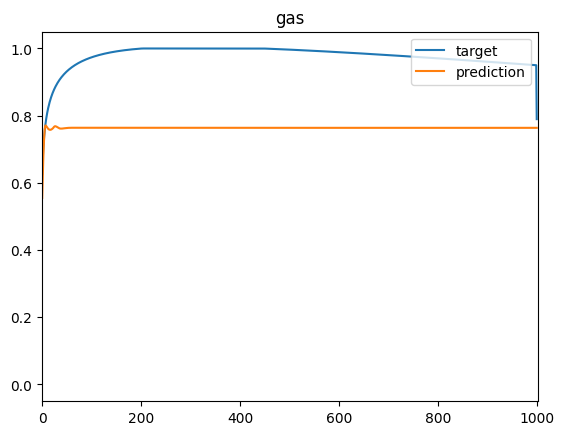

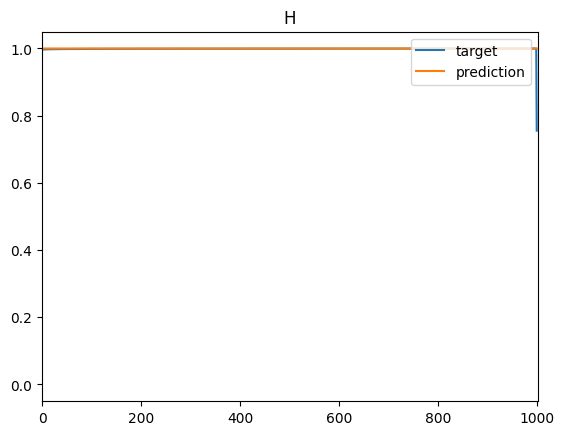

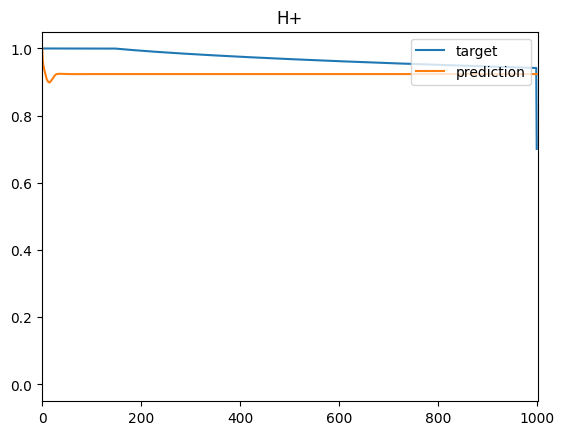

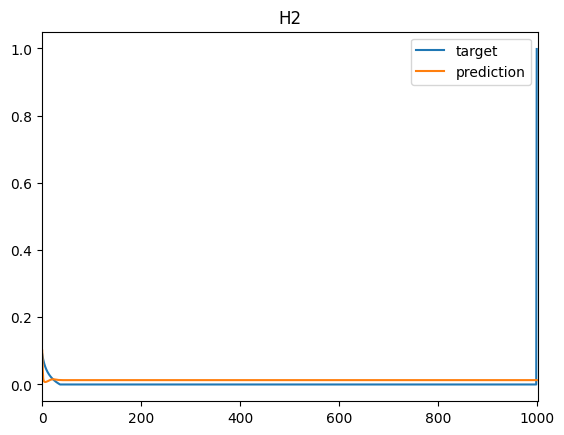

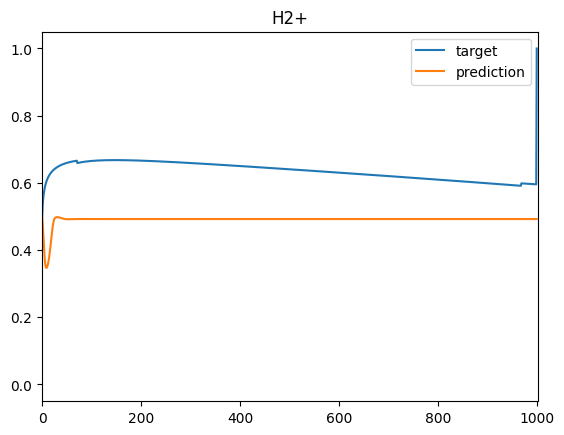

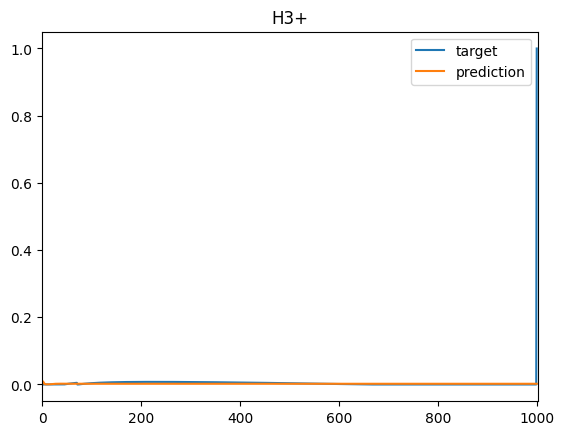

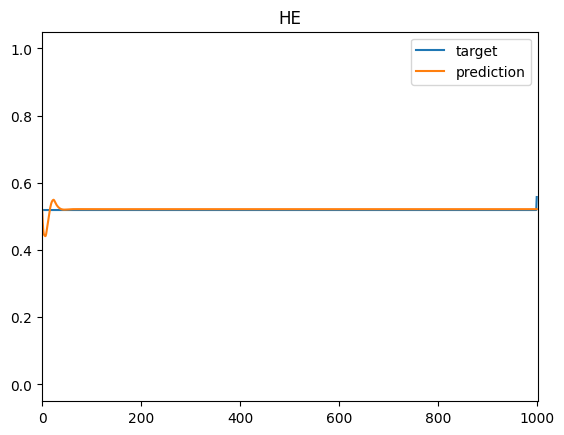

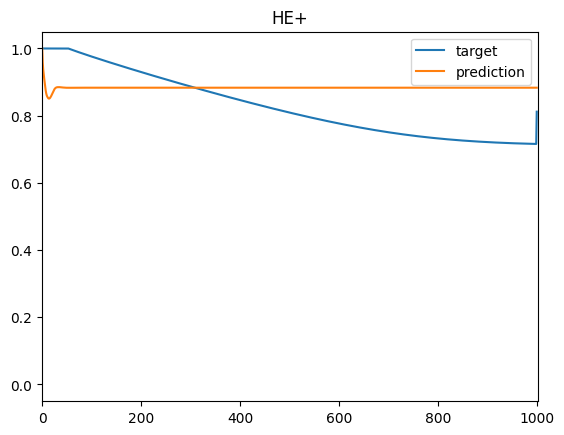

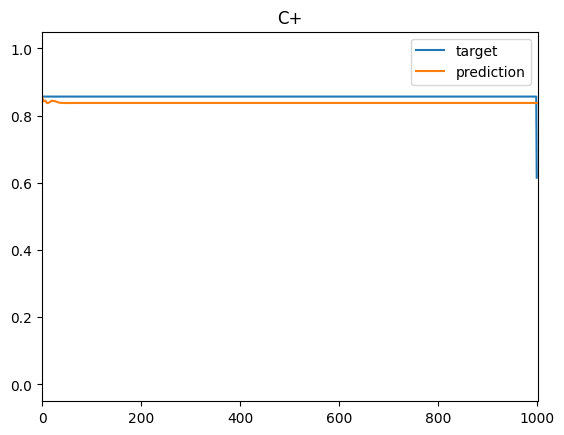

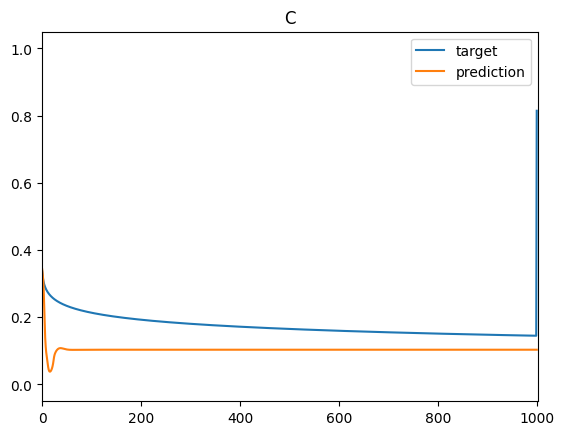

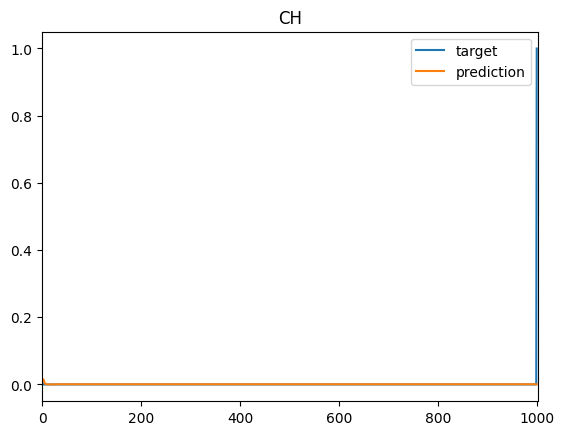

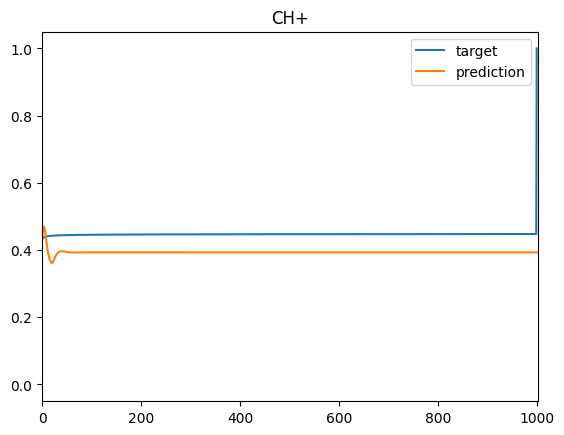

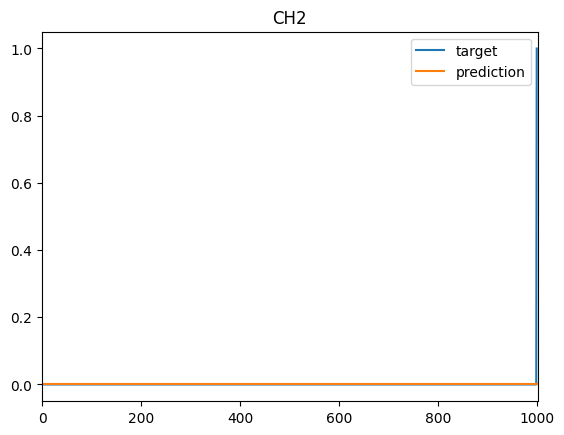

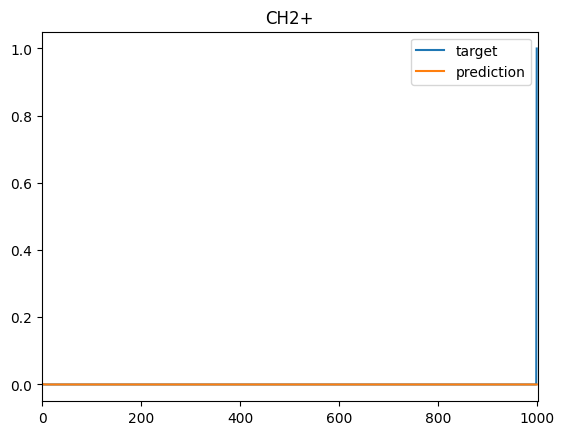

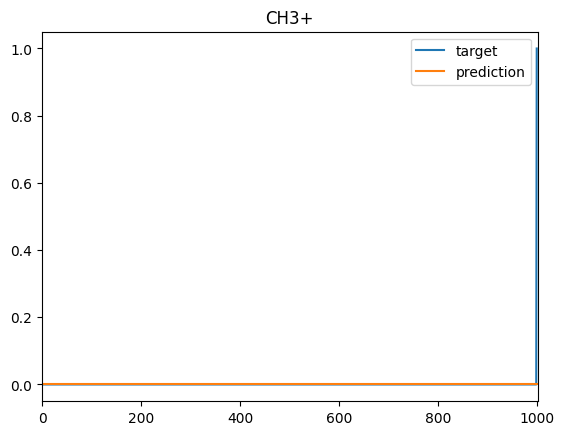

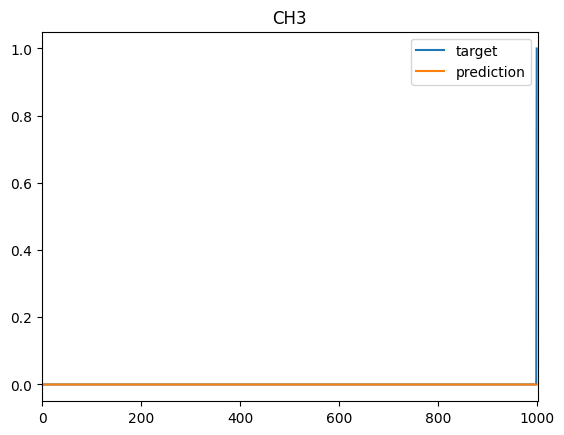

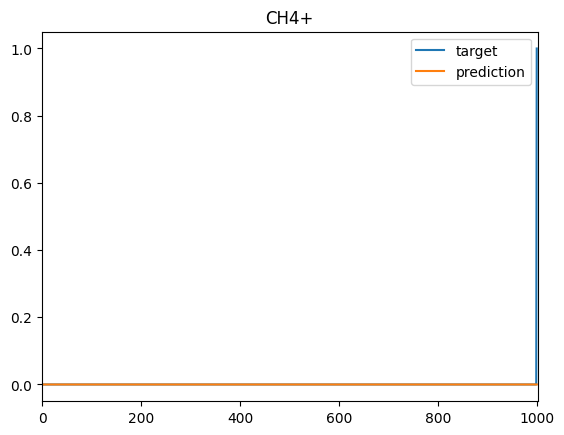

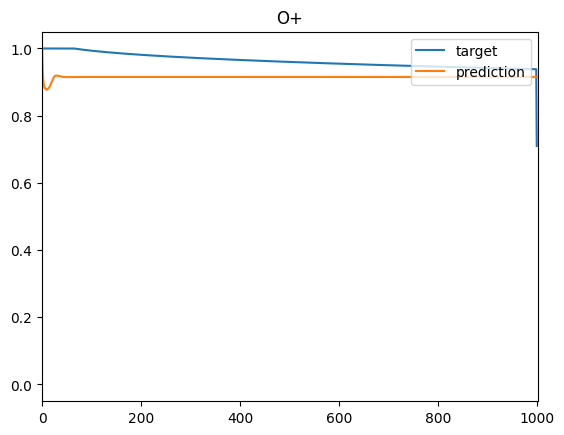

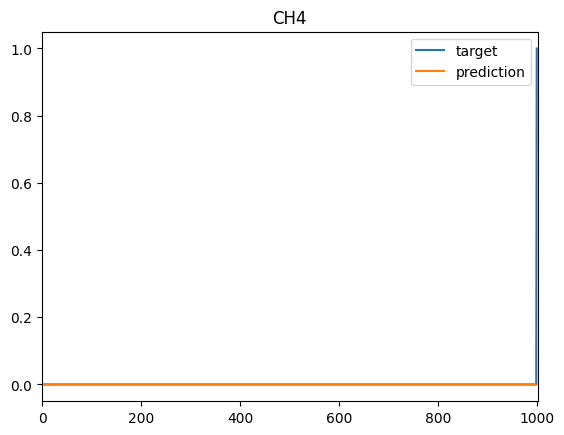

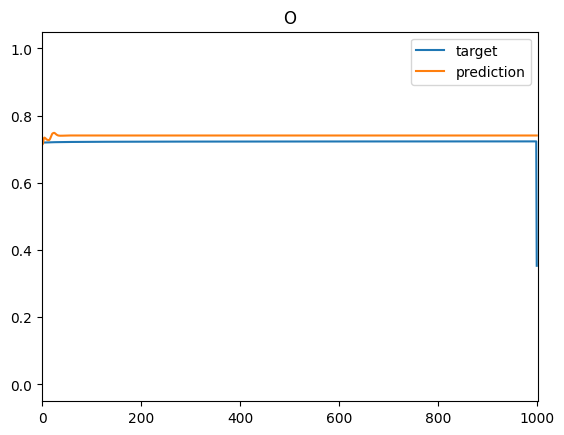

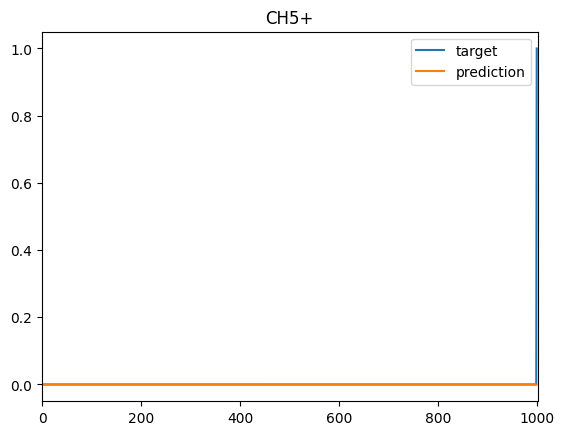

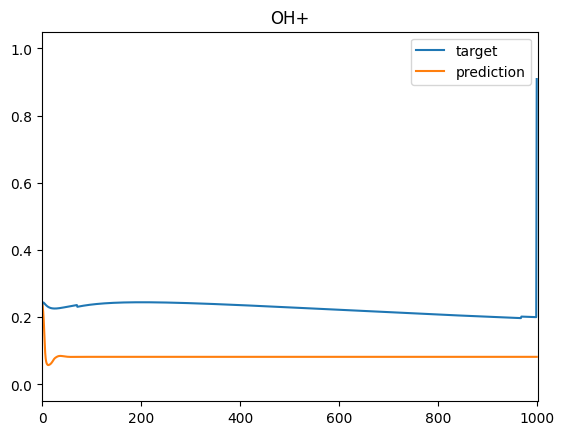

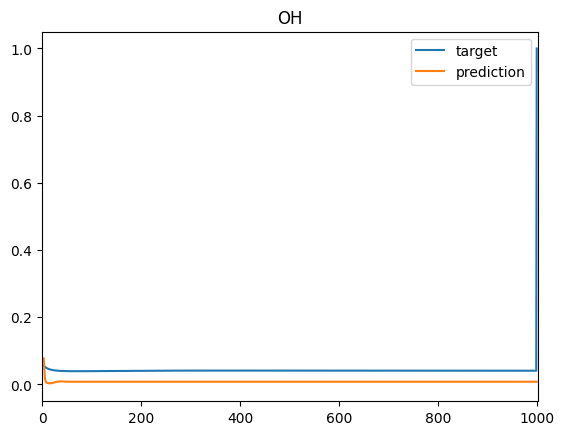

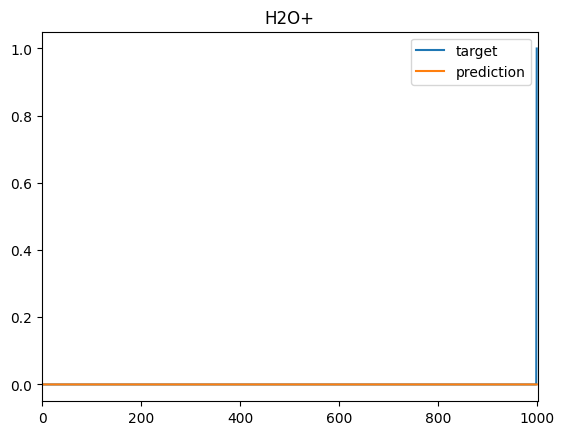

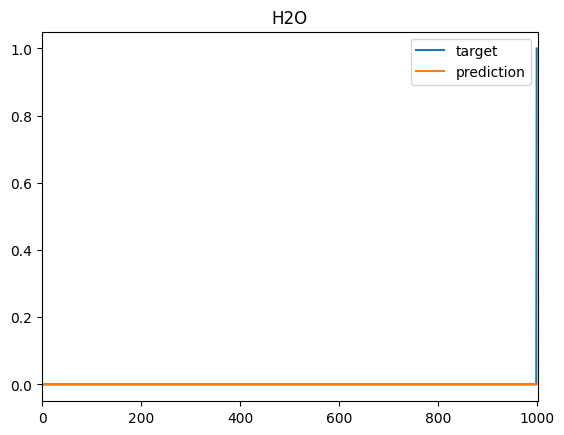

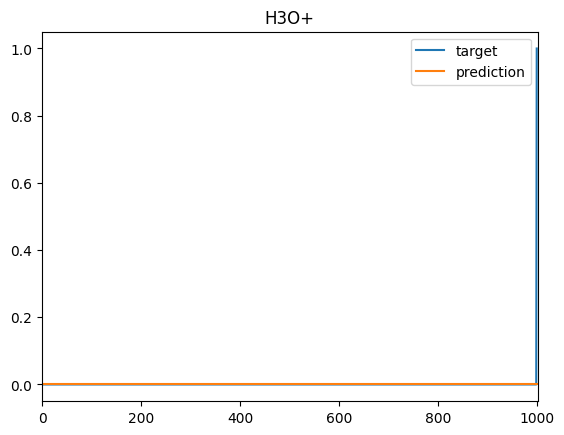

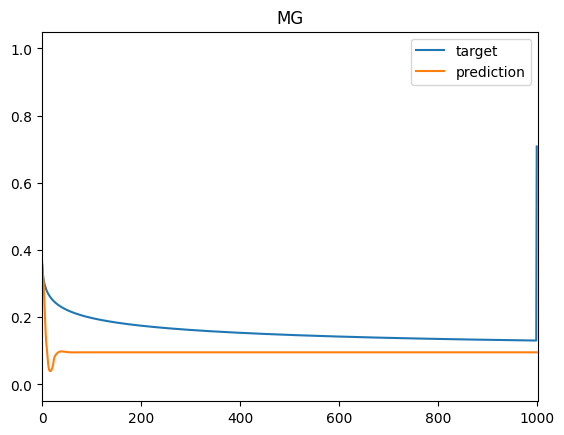

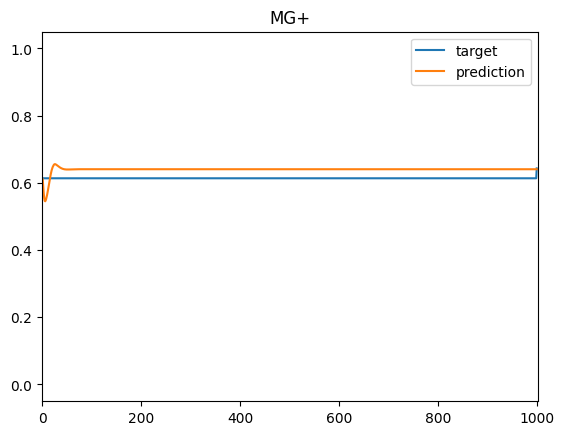

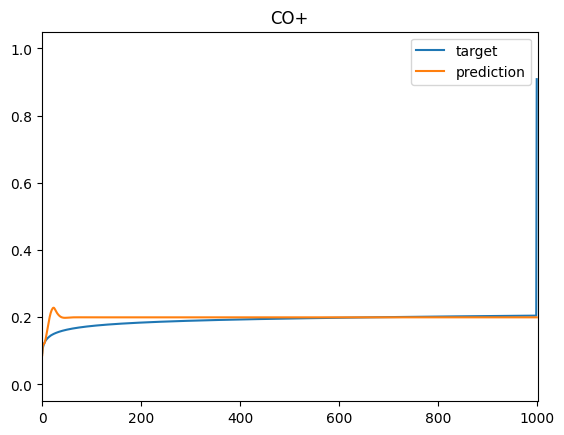

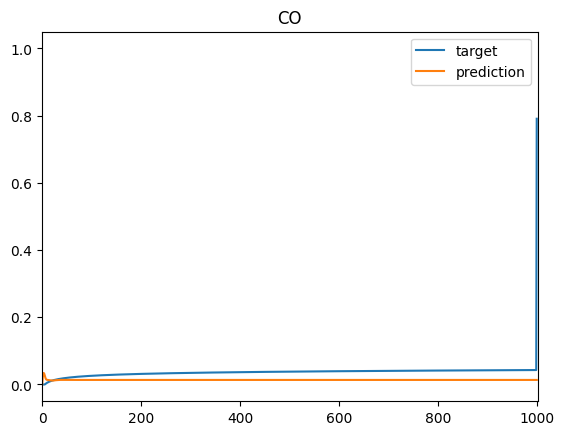

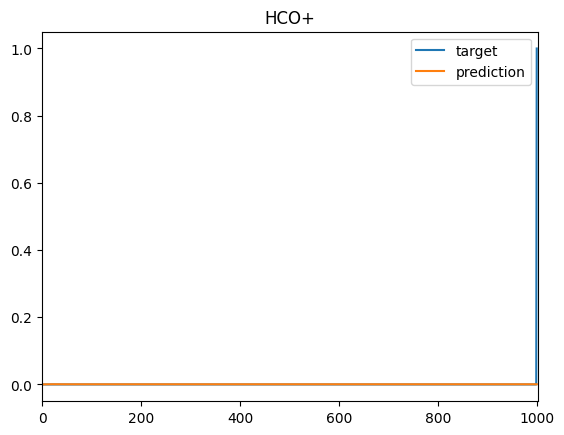

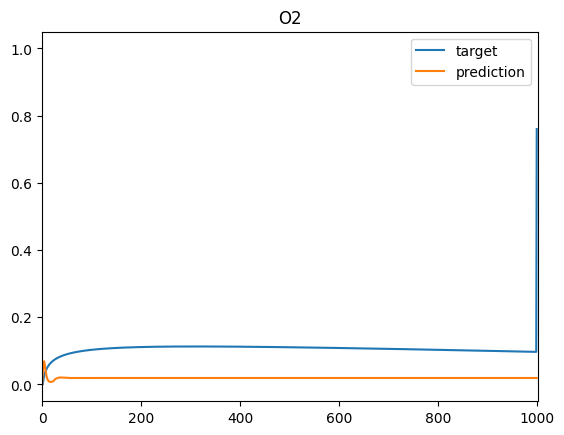

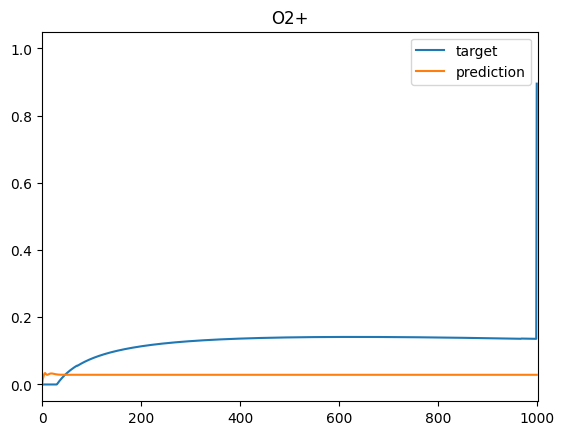

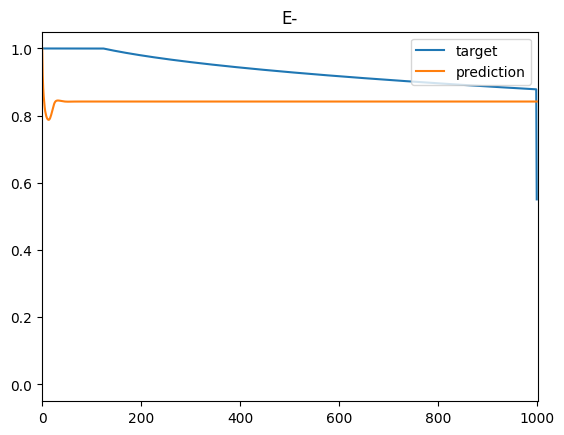

In [10]:
plt.figure()
plt.plot(train_all_target[init_idx:init_idx+1000, 0], label = 'target')
plt.plot(pred_all[:, 0], label = 'prediction')
plt.axis([-1., 1001., -0.05, 1.05])
plt.title('gas')
plt.legend(loc = 1)
for i in range(len(abundances)):
    plt.figure()
    plt.plot(train_all_target[init_idx:init_idx+1000, 1+i], label = 'target')
    plt.plot(pred_all[:, len(physics_labels)+i], label = 'prediction')
    plt.axis([-1., 1001., -0.05, 1.05])
    plt.title(abundances[i])
    plt.legend(loc = 1)

# 4. Regression using features extracted by Autoencoders

In [11]:
train_abundances = np.array(train_data[abundances])
test_abundances = np.array(test_data[abundances])

### Build AE with 8 dimensional latent space

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
encoding_dim = 8  

# This is our input image
inputs = Input(shape=(len(abundances),))
en_hidden = Dense(256, activation='swish')(inputs)
encoded = Dense(encoding_dim)(en_hidden)

de_hidden = Dense(256, activation='swish')(encoded)               
decoded = Dense(len(abundances))(de_hidden)

# This model maps an input to its reconstruction
AE = Model(inputs, decoded)
AE_encoder = Model(inputs, encoded)

AE.compile(loss="mse", optimizer='adam')

stopper=EarlyStopping(monitor ="val_loss", min_delta=0.0,verbose=1,
                      mode="min",
                      restore_best_weights=True,patience=2)
history_ae = AE.fit(train_abundances, train_abundances, epochs=5, batch_size=128,
                             validation_data = (test_abundances, test_abundances) ,callbacks=[stopper])```
    
</p>
</details>

In [12]:
encoding_dim = 8

# This is our input image
inputs = Input(shape=(len(abundances),))
en_hidden = Dense(256, activation='swish')(inputs)
encoded = Dense(encoding_dim)(en_hidden)

de_hidden = Dense(256, activation='swish')(encoded)
decoded = Dense(len(abundances))(de_hidden)

# This model maps an input to its reconstruction
AE = Model(inputs, decoded)
AE_encoder = Model(inputs, encoded)

AE.compile(loss="mse", optimizer='adam')

stopper=EarlyStopping(monitor ="val_loss", min_delta=0.0,verbose=1,
                      mode="min",
                      restore_best_weights=True,patience=2)
history_ae = AE.fit(train_abundances, train_abundances, epochs=5, batch_size=128,
                             validation_data = (test_abundances, test_abundances) ,callbacks=[stopper])

Epoch 1/5
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - loss: 0.0043 - val_loss: 7.9062e-04
Epoch 2/5
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 3.0980e-04 - val_loss: 6.8019e-04
Epoch 3/5
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 2.2249e-04 - val_loss: 6.6330e-04
Epoch 4/5
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 1.7959e-04 - val_loss: 6.3225e-04
Epoch 5/5
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 1.5511e-04 - val_loss: 6.0347e-04
Restoring model weights from the end of the best epoch: 5.


### Visualize reconstruction results using the autoencoder


**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
test_recon = AE.predict(test_abundances)
idx_abundances = 0
plt.figure()
plt.plot(test_abundances[:, idx_abundances], label = 'true ' + abundances[idx_abundances])
plt.plot(test_recon[:, idx_abundances], label = 'reconstruction')
plt.legend(bbox_to_anchor=(1., 1.03))
plt.xlabel('time')
plt.ylabel(abundances[idx_abundances], rotation=0)
plt.title(abundances[idx_abundances] + ' reconstruction result')
```
    
</p>
</details>

12500/12500 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step


Text(0.5, 1.0, 'H reconstruction result')

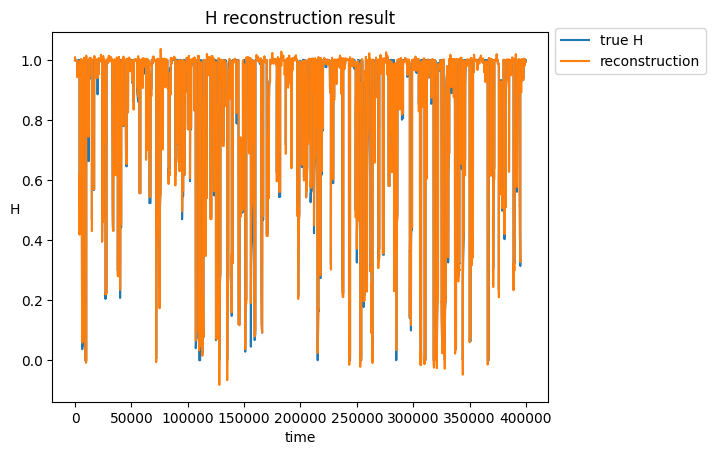

In [13]:
test_recon = AE.predict(test_abundances)
idx_abundances = 0
plt.figure()
plt.plot(test_abundances[:, idx_abundances], label = 'true ' + abundances[idx_abundances])
plt.plot(test_recon[:, idx_abundances], label = 'reconstruction')
plt.legend(bbox_to_anchor=(1., 1.03))
plt.xlabel('time')
plt.ylabel(abundances[idx_abundances], rotation=0)
plt.title(abundances[idx_abundances] + ' reconstruction result')

### Prepare encoded features using the encoder of the autoencoder

In [14]:
abundances_encoded = []
for i in tqdm(range(int(len(train_data)/1000))):
    abundances_encoded.append(AE_encoder.predict(np.array(train_abundances[i*1000:(i+1)*1000])))

abundances_test_encoded = []
for i in tqdm(range(int(len(test_data)/1000))):
    abundances_test_encoded.append(AE_encoder.predict(np.array(test_abundances[i*1000:(i+1)*1000])))

abundances_encoded = np.concatenate(abundances_encoded, axis =0)
abundances_test_encoded = np.concatenate(abundances_test_encoded, axis =0)

  0%|          | 0/2000 [00:00<?, ?it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


  0%|          | 1/2000 [00:00<17:07,  1.94it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  0%|          | 2/2000 [00:00<09:18,  3.57it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  0%|          | 3/2000 [00:00<06:45,  4.92it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  0%|          | 4/2000 [00:00<05:33,  5.99it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  0%|          | 5/2000 [00:00<04:56,  6.74it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  0%|          | 6/2000 [00:01<04:29,  7.39it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  0%|          | 7/2000 [00:01<04:10,  7.95it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  0%|          | 8/2000 [00:01<03:58,  8.34it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  0%|          | 9/2000 [00:01<03:57,  8.39it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  0%|          | 10/2000 [00:01<03:49,  8.67it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  1%|          | 11/2000 [00:01<03:47,  8.75it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  1%|          | 12/2000 [00:01<03:47,  8.72it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 13/2000 [00:01<04:26,  7.45it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 14/2000 [00:02<04:42,  7.03it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 15/2000 [00:02<04:53,  6.76it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  1%|          | 16/2000 [00:02<05:24,  6.11it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 17/2000 [00:02<05:47,  5.71it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  1%|          | 18/2000 [00:02<05:33,  5.94it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 19/2000 [00:02<05:51,  5.64it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 20/2000 [00:03<05:48,  5.69it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 21/2000 [00:03<05:43,  5.76it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|          | 22/2000 [00:03<05:48,  5.67it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|          | 23/2000 [00:03<05:53,  5.60it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  1%|          | 24/2000 [00:03<05:13,  6.30it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  1%|▏         | 25/2000 [00:03<04:47,  6.86it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  1%|▏         | 26/2000 [00:04<04:28,  7.36it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  1%|▏         | 27/2000 [00:04<04:11,  7.84it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  1%|▏         | 28/2000 [00:04<04:00,  8.19it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  1%|▏         | 29/2000 [00:04<03:54,  8.42it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  2%|▏         | 30/2000 [00:04<03:56,  8.35it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  2%|▏         | 31/2000 [00:04<03:55,  8.35it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  2%|▏         | 32/2000 [00:04<03:50,  8.54it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  2%|▏         | 33/2000 [00:04<03:44,  8.74it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  2%|▏         | 34/2000 [00:04<03:45,  8.72it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  2%|▏         | 35/2000 [00:05<03:42,  8.84it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  2%|▏         | 36/2000 [00:05<03:43,  8.80it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  2%|▏         | 37/2000 [00:05<03:43,  8.79it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  2%|▏         | 38/2000 [00:05<03:42,  8.82it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  2%|▏         | 39/2000 [00:05<03:50,  8.52it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  2%|▏         | 40/2000 [00:05<03:48,  8.58it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  2%|▏         | 41/2000 [00:05<03:45,  8.71it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  2%|▏         | 42/2000 [00:05<03:42,  8.79it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  2%|▏         | 43/2000 [00:05<03:41,  8.83it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  2%|▏         | 44/2000 [00:06<03:40,  8.87it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  2%|▏         | 45/2000 [00:06<03:38,  8.94it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  2%|▏         | 46/2000 [00:06<03:38,  8.96it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  2%|▏         | 47/2000 [00:06<03:36,  9.01it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  2%|▏         | 48/2000 [00:06<03:38,  8.95it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  2%|▏         | 49/2000 [00:06<03:45,  8.66it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  2%|▎         | 50/2000 [00:06<03:42,  8.78it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  3%|▎         | 51/2000 [00:06<03:42,  8.75it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  3%|▎         | 52/2000 [00:07<03:47,  8.56it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  3%|▎         | 53/2000 [00:07<03:43,  8.70it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  3%|▎         | 54/2000 [00:07<03:42,  8.74it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  3%|▎         | 55/2000 [00:07<03:39,  8.86it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  3%|▎         | 56/2000 [00:07<03:40,  8.83it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  3%|▎         | 57/2000 [00:07<03:46,  8.58it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  3%|▎         | 58/2000 [00:07<03:47,  8.55it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  3%|▎         | 59/2000 [00:07<03:43,  8.69it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  3%|▎         | 60/2000 [00:07<03:42,  8.73it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  3%|▎         | 61/2000 [00:08<03:52,  8.35it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  3%|▎         | 62/2000 [00:08<03:48,  8.47it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  3%|▎         | 63/2000 [00:08<03:45,  8.58it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  3%|▎         | 64/2000 [00:08<03:41,  8.72it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  3%|▎         | 65/2000 [00:08<03:39,  8.80it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  3%|▎         | 66/2000 [00:08<03:47,  8.52it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  3%|▎         | 67/2000 [00:08<03:42,  8.69it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  3%|▎         | 68/2000 [00:08<03:58,  8.09it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  3%|▎         | 69/2000 [00:08<03:51,  8.33it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  4%|▎         | 70/2000 [00:09<03:49,  8.40it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  4%|▎         | 71/2000 [00:09<03:45,  8.55it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  4%|▎         | 72/2000 [00:09<03:41,  8.72it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  4%|▎         | 73/2000 [00:09<03:42,  8.67it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  4%|▎         | 74/2000 [00:09<03:40,  8.75it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  4%|▍         | 75/2000 [00:09<03:47,  8.45it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  4%|▍         | 76/2000 [00:09<03:44,  8.57it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  4%|▍         | 77/2000 [00:09<03:44,  8.56it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  4%|▍         | 78/2000 [00:10<03:42,  8.62it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  4%|▍         | 79/2000 [00:10<03:40,  8.69it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  4%|▍         | 80/2000 [00:10<03:41,  8.68it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  4%|▍         | 81/2000 [00:10<03:39,  8.76it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  4%|▍         | 82/2000 [00:10<03:38,  8.77it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  4%|▍         | 83/2000 [00:10<03:37,  8.82it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  4%|▍         | 84/2000 [00:10<03:44,  8.54it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  4%|▍         | 85/2000 [00:10<03:45,  8.49it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  4%|▍         | 86/2000 [00:10<03:46,  8.46it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  4%|▍         | 87/2000 [00:11<03:44,  8.52it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  4%|▍         | 88/2000 [00:11<03:40,  8.66it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  4%|▍         | 89/2000 [00:11<03:40,  8.67it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  4%|▍         | 90/2000 [00:11<03:41,  8.64it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  5%|▍         | 91/2000 [00:11<03:38,  8.76it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  5%|▍         | 92/2000 [00:11<03:37,  8.76it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  5%|▍         | 93/2000 [00:11<03:41,  8.60it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  5%|▍         | 94/2000 [00:11<03:41,  8.59it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  5%|▍         | 95/2000 [00:11<03:39,  8.70it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  5%|▍         | 96/2000 [00:12<03:37,  8.75it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  5%|▍         | 97/2000 [00:12<03:39,  8.68it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  5%|▍         | 98/2000 [00:12<03:37,  8.75it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  5%|▍         | 99/2000 [00:12<03:36,  8.78it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  5%|▌         | 100/2000 [00:12<03:34,  8.86it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  5%|▌         | 101/2000 [00:12<03:36,  8.79it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  5%|▌         | 102/2000 [00:12<03:40,  8.60it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  5%|▌         | 103/2000 [00:12<03:38,  8.67it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  5%|▌         | 104/2000 [00:13<03:38,  8.66it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  5%|▌         | 105/2000 [00:13<03:36,  8.74it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  5%|▌         | 106/2000 [00:13<03:33,  8.86it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  5%|▌         | 107/2000 [00:13<03:33,  8.88it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  5%|▌         | 108/2000 [00:13<03:34,  8.80it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  5%|▌         | 109/2000 [00:13<03:38,  8.64it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  6%|▌         | 110/2000 [00:13<03:39,  8.62it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  6%|▌         | 111/2000 [00:13<04:24,  7.15it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  6%|▌         | 112/2000 [00:14<04:42,  6.69it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  6%|▌         | 113/2000 [00:14<04:55,  6.39it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  6%|▌         | 114/2000 [00:14<04:58,  6.32it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  6%|▌         | 115/2000 [00:14<05:03,  6.22it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  6%|▌         | 116/2000 [00:14<05:03,  6.22it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  6%|▌         | 117/2000 [00:14<05:16,  5.95it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  6%|▌         | 118/2000 [00:15<05:05,  6.15it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  6%|▌         | 119/2000 [00:15<05:09,  6.08it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  6%|▌         | 120/2000 [00:15<05:09,  6.08it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  6%|▌         | 121/2000 [00:15<05:35,  5.59it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  6%|▌         | 122/2000 [00:15<05:41,  5.50it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  6%|▌         | 123/2000 [00:15<05:13,  5.98it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  6%|▌         | 124/2000 [00:16<04:43,  6.61it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  6%|▋         | 125/2000 [00:16<04:24,  7.08it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  6%|▋         | 126/2000 [00:16<04:09,  7.51it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  6%|▋         | 127/2000 [00:16<03:59,  7.83it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  6%|▋         | 128/2000 [00:16<03:51,  8.08it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  6%|▋         | 129/2000 [00:16<03:46,  8.27it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  6%|▋         | 130/2000 [00:16<03:42,  8.39it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  7%|▋         | 131/2000 [00:16<03:39,  8.50it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  7%|▋         | 132/2000 [00:16<03:43,  8.34it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  7%|▋         | 133/2000 [00:17<03:42,  8.40it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  7%|▋         | 134/2000 [00:17<04:20,  7.17it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  7%|▋         | 135/2000 [00:17<04:06,  7.57it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  7%|▋         | 136/2000 [00:17<03:55,  7.90it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  7%|▋         | 137/2000 [00:17<03:49,  8.10it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  7%|▋         | 138/2000 [00:17<03:45,  8.25it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  7%|▋         | 139/2000 [00:17<04:21,  7.12it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  7%|▋         | 140/2000 [00:18<04:07,  7.52it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  7%|▋         | 141/2000 [00:18<04:00,  7.72it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  7%|▋         | 142/2000 [00:18<03:51,  8.02it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  7%|▋         | 143/2000 [00:18<03:47,  8.15it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  7%|▋         | 144/2000 [00:18<03:44,  8.26it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  7%|▋         | 145/2000 [00:18<03:45,  8.24it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  7%|▋         | 146/2000 [00:18<03:44,  8.24it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  7%|▋         | 147/2000 [00:18<03:42,  8.34it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  7%|▋         | 148/2000 [00:19<03:46,  8.17it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  7%|▋         | 149/2000 [00:19<03:42,  8.34it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  8%|▊         | 150/2000 [00:19<03:40,  8.39it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  8%|▊         | 151/2000 [00:19<03:38,  8.47it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  8%|▊         | 152/2000 [00:19<03:35,  8.57it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  8%|▊         | 153/2000 [00:19<03:37,  8.48it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  8%|▊         | 154/2000 [00:19<03:35,  8.55it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  8%|▊         | 155/2000 [00:19<03:35,  8.56it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  8%|▊         | 156/2000 [00:19<03:34,  8.60it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  8%|▊         | 157/2000 [00:20<04:19,  7.11it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  8%|▊         | 158/2000 [00:20<04:05,  7.50it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  8%|▊         | 159/2000 [00:20<03:55,  7.81it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  8%|▊         | 160/2000 [00:20<03:50,  7.98it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  8%|▊         | 161/2000 [00:20<03:45,  8.17it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  8%|▊         | 162/2000 [00:20<03:41,  8.30it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  8%|▊         | 163/2000 [00:20<03:38,  8.42it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  8%|▊         | 164/2000 [00:20<03:37,  8.43it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  8%|▊         | 165/2000 [00:21<03:40,  8.31it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  8%|▊         | 166/2000 [00:21<03:39,  8.34it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  8%|▊         | 167/2000 [00:21<03:36,  8.47it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  8%|▊         | 168/2000 [00:21<03:34,  8.54it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  8%|▊         | 169/2000 [00:21<03:38,  8.39it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  8%|▊         | 170/2000 [00:21<03:36,  8.43it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  9%|▊         | 171/2000 [00:21<03:37,  8.42it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  9%|▊         | 172/2000 [00:21<03:36,  8.43it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  9%|▊         | 173/2000 [00:22<03:34,  8.52it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  9%|▊         | 174/2000 [00:22<03:38,  8.34it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  9%|▉         | 175/2000 [00:22<03:36,  8.44it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  9%|▉         | 176/2000 [00:22<03:33,  8.55it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  9%|▉         | 177/2000 [00:22<03:30,  8.65it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  9%|▉         | 178/2000 [00:22<03:27,  8.78it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  9%|▉         | 179/2000 [00:22<03:28,  8.75it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  9%|▉         | 180/2000 [00:22<03:28,  8.73it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  9%|▉         | 181/2000 [00:22<03:32,  8.54it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  9%|▉         | 182/2000 [00:23<03:31,  8.61it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  9%|▉         | 183/2000 [00:23<03:35,  8.45it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  9%|▉         | 184/2000 [00:23<03:31,  8.58it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  9%|▉         | 185/2000 [00:23<03:29,  8.65it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  9%|▉         | 186/2000 [00:23<03:28,  8.71it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  9%|▉         | 187/2000 [00:23<03:29,  8.67it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  9%|▉         | 188/2000 [00:23<03:30,  8.60it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  9%|▉         | 189/2000 [00:23<03:29,  8.67it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 10%|▉         | 190/2000 [00:23<03:27,  8.73it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 10%|▉         | 191/2000 [00:24<03:26,  8.77it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 10%|▉         | 192/2000 [00:24<03:32,  8.52it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 10%|▉         | 193/2000 [00:24<03:34,  8.41it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 10%|▉         | 194/2000 [00:24<03:32,  8.50it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 10%|▉         | 195/2000 [00:24<03:32,  8.51it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 10%|▉         | 196/2000 [00:24<03:32,  8.47it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 10%|▉         | 197/2000 [00:24<03:32,  8.48it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 10%|▉         | 198/2000 [00:24<03:33,  8.46it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 10%|▉         | 199/2000 [00:25<03:30,  8.54it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 10%|█         | 200/2000 [00:25<04:08,  7.23it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 10%|█         | 201/2000 [00:25<03:55,  7.63it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 10%|█         | 202/2000 [00:25<04:24,  6.80it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 10%|█         | 203/2000 [00:25<04:06,  7.28it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 10%|█         | 204/2000 [00:25<04:32,  6.60it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 10%|█         | 205/2000 [00:26<05:12,  5.74it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 10%|█         | 206/2000 [00:26<05:10,  5.78it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 10%|█         | 207/2000 [00:26<05:06,  5.85it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 10%|█         | 208/2000 [00:26<05:06,  5.84it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 10%|█         | 209/2000 [00:26<05:28,  5.45it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 10%|█         | 210/2000 [00:26<05:20,  5.59it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 11%|█         | 211/2000 [00:27<05:12,  5.73it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 11%|█         | 212/2000 [00:27<05:13,  5.71it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 11%|█         | 213/2000 [00:27<05:33,  5.36it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 11%|█         | 214/2000 [00:27<05:47,  5.14it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 11%|█         | 215/2000 [00:27<05:46,  5.16it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 11%|█         | 216/2000 [00:28<05:03,  5.87it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 11%|█         | 217/2000 [00:28<04:38,  6.41it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 11%|█         | 218/2000 [00:28<04:16,  6.94it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 11%|█         | 219/2000 [00:28<04:16,  6.94it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 11%|█         | 220/2000 [00:28<04:02,  7.34it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 11%|█         | 221/2000 [00:28<03:52,  7.64it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 11%|█         | 222/2000 [00:28<03:45,  7.89it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 11%|█         | 223/2000 [00:28<03:41,  8.02it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 11%|█         | 224/2000 [00:28<03:36,  8.20it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 11%|█▏        | 225/2000 [00:29<03:32,  8.36it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 11%|█▏        | 226/2000 [00:29<03:28,  8.52it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 11%|█▏        | 227/2000 [00:29<03:25,  8.63it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 11%|█▏        | 228/2000 [00:29<03:29,  8.45it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 11%|█▏        | 229/2000 [00:29<03:31,  8.39it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 12%|█▏        | 230/2000 [00:29<03:30,  8.42it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 12%|█▏        | 231/2000 [00:29<03:29,  8.44it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 12%|█▏        | 232/2000 [00:29<03:30,  8.39it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 12%|█▏        | 233/2000 [00:30<03:28,  8.49it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 12%|█▏        | 234/2000 [00:30<03:30,  8.40it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 12%|█▏        | 235/2000 [00:30<03:30,  8.39it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 12%|█▏        | 236/2000 [00:30<03:35,  8.17it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 12%|█▏        | 237/2000 [00:30<03:31,  8.33it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 12%|█▏        | 238/2000 [00:30<03:29,  8.41it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 12%|█▏        | 239/2000 [00:30<03:28,  8.44it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 12%|█▏        | 240/2000 [00:30<03:28,  8.43it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 12%|█▏        | 241/2000 [00:31<03:30,  8.36it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 12%|█▏        | 242/2000 [00:31<03:29,  8.39it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 12%|█▏        | 243/2000 [00:31<03:27,  8.48it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 12%|█▏        | 244/2000 [00:31<03:26,  8.49it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 12%|█▏        | 245/2000 [00:31<03:32,  8.27it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 12%|█▏        | 246/2000 [00:31<03:29,  8.37it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 12%|█▏        | 247/2000 [00:31<03:29,  8.38it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 12%|█▏        | 248/2000 [00:31<03:27,  8.45it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 12%|█▏        | 249/2000 [00:31<03:27,  8.44it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 12%|█▎        | 250/2000 [00:32<03:24,  8.55it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 13%|█▎        | 251/2000 [00:32<03:23,  8.59it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 13%|█▎        | 252/2000 [00:32<03:22,  8.65it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 13%|█▎        | 253/2000 [00:32<03:25,  8.51it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 13%|█▎        | 254/2000 [00:32<03:31,  8.26it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 13%|█▎        | 255/2000 [00:32<03:29,  8.34it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 13%|█▎        | 256/2000 [00:32<03:29,  8.33it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 13%|█▎        | 257/2000 [00:32<04:04,  7.12it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 13%|█▎        | 258/2000 [00:33<03:53,  7.47it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 13%|█▎        | 259/2000 [00:33<03:43,  7.78it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 13%|█▎        | 260/2000 [00:33<03:36,  8.02it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 13%|█▎        | 261/2000 [00:33<03:32,  8.17it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 13%|█▎        | 262/2000 [00:33<03:34,  8.10it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 13%|█▎        | 263/2000 [00:33<03:30,  8.26it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 13%|█▎        | 264/2000 [00:33<03:27,  8.35it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 13%|█▎        | 265/2000 [00:33<03:30,  8.24it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 13%|█▎        | 266/2000 [00:34<03:28,  8.34it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 13%|█▎        | 267/2000 [00:34<03:27,  8.36it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 13%|█▎        | 268/2000 [00:34<03:26,  8.39it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 13%|█▎        | 269/2000 [00:34<04:01,  7.15it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 14%|█▎        | 270/2000 [00:34<03:56,  7.33it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 14%|█▎        | 271/2000 [00:34<03:46,  7.63it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 14%|█▎        | 272/2000 [00:34<03:38,  7.91it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 14%|█▎        | 273/2000 [00:34<03:34,  8.04it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 14%|█▎        | 274/2000 [00:35<03:28,  8.28it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 14%|█▍        | 275/2000 [00:35<03:25,  8.40it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 14%|█▍        | 276/2000 [00:35<03:23,  8.48it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 14%|█▍        | 277/2000 [00:35<03:24,  8.43it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 14%|█▍        | 278/2000 [00:35<03:23,  8.47it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 14%|█▍        | 279/2000 [00:35<03:28,  8.25it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 14%|█▍        | 280/2000 [00:35<04:01,  7.12it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 14%|█▍        | 281/2000 [00:35<03:53,  7.38it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 14%|█▍        | 282/2000 [00:36<03:43,  7.69it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 14%|█▍        | 283/2000 [00:36<03:36,  7.91it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 14%|█▍        | 284/2000 [00:36<03:32,  8.07it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 14%|█▍        | 285/2000 [00:36<03:29,  8.18it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 14%|█▍        | 286/2000 [00:36<03:27,  8.26it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 14%|█▍        | 287/2000 [00:36<03:30,  8.15it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 14%|█▍        | 288/2000 [00:36<03:27,  8.24it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 14%|█▍        | 289/2000 [00:36<03:29,  8.17it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 14%|█▍        | 290/2000 [00:37<03:26,  8.29it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 15%|█▍        | 291/2000 [00:37<03:23,  8.39it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 15%|█▍        | 292/2000 [00:37<03:22,  8.44it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 15%|█▍        | 293/2000 [00:37<03:21,  8.49it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 15%|█▍        | 294/2000 [00:37<03:20,  8.50it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 15%|█▍        | 295/2000 [00:37<03:56,  7.20it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 15%|█▍        | 296/2000 [00:37<03:48,  7.47it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 15%|█▍        | 297/2000 [00:37<03:59,  7.11it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 15%|█▍        | 298/2000 [00:38<04:21,  6.51it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 15%|█▍        | 299/2000 [00:38<04:47,  5.91it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 15%|█▌        | 300/2000 [00:38<04:43,  6.00it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 15%|█▌        | 301/2000 [00:38<04:50,  5.84it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 15%|█▌        | 302/2000 [00:38<04:58,  5.69it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 15%|█▌        | 303/2000 [00:39<05:03,  5.60it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 15%|█▌        | 304/2000 [00:39<04:59,  5.67it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 15%|█▌        | 305/2000 [00:39<04:59,  5.66it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 15%|█▌        | 306/2000 [00:39<05:02,  5.60it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 15%|█▌        | 307/2000 [00:39<05:08,  5.49it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 15%|█▌        | 308/2000 [00:40<05:17,  5.33it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 15%|█▌        | 309/2000 [00:40<04:55,  5.72it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 16%|█▌        | 310/2000 [00:40<04:25,  6.36it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 16%|█▌        | 311/2000 [00:40<04:03,  6.94it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 16%|█▌        | 312/2000 [00:40<03:49,  7.35it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 16%|█▌        | 313/2000 [00:40<03:42,  7.58it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 16%|█▌        | 314/2000 [00:40<03:35,  7.81it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 16%|█▌        | 315/2000 [00:40<03:41,  7.60it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 16%|█▌        | 316/2000 [00:40<03:35,  7.81it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 16%|█▌        | 317/2000 [00:41<03:30,  8.00it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 16%|█▌        | 318/2000 [00:41<03:26,  8.16it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 16%|█▌        | 319/2000 [00:41<03:25,  8.19it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 16%|█▌        | 320/2000 [00:41<03:21,  8.32it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 16%|█▌        | 321/2000 [00:41<03:19,  8.42it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 16%|█▌        | 322/2000 [00:41<03:19,  8.40it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 16%|█▌        | 323/2000 [00:41<03:19,  8.42it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 16%|█▌        | 324/2000 [00:41<03:25,  8.14it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 16%|█▋        | 325/2000 [00:42<03:25,  8.17it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 16%|█▋        | 326/2000 [00:42<03:57,  7.04it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 16%|█▋        | 327/2000 [00:42<03:44,  7.44it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 16%|█▋        | 328/2000 [00:42<03:37,  7.70it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 16%|█▋        | 329/2000 [00:42<03:30,  7.95it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 16%|█▋        | 330/2000 [00:42<03:25,  8.12it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 17%|█▋        | 331/2000 [00:42<03:24,  8.16it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 17%|█▋        | 332/2000 [00:42<03:27,  8.05it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 17%|█▋        | 333/2000 [00:43<03:22,  8.23it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 17%|█▋        | 334/2000 [00:43<03:22,  8.22it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 17%|█▋        | 335/2000 [00:43<03:20,  8.29it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 17%|█▋        | 336/2000 [00:43<03:19,  8.34it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 17%|█▋        | 337/2000 [00:43<03:56,  7.04it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 17%|█▋        | 338/2000 [00:43<03:45,  7.35it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 17%|█▋        | 339/2000 [00:43<03:40,  7.54it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 17%|█▋        | 340/2000 [00:44<04:15,  6.51it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 17%|█▋        | 341/2000 [00:44<03:57,  6.99it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 17%|█▋        | 342/2000 [00:44<03:44,  7.38it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 17%|█▋        | 343/2000 [00:44<03:35,  7.70it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 17%|█▋        | 344/2000 [00:44<04:03,  6.79it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 17%|█▋        | 345/2000 [00:44<03:49,  7.21it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 17%|█▋        | 346/2000 [00:44<03:41,  7.47it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 17%|█▋        | 347/2000 [00:45<03:38,  7.56it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 17%|█▋        | 348/2000 [00:45<03:31,  7.83it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 17%|█▋        | 349/2000 [00:45<03:28,  7.93it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 18%|█▊        | 350/2000 [00:45<03:24,  8.08it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 18%|█▊        | 351/2000 [00:45<03:20,  8.22it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 18%|█▊        | 352/2000 [00:45<03:19,  8.26it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 18%|█▊        | 353/2000 [00:45<03:19,  8.26it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 18%|█▊        | 354/2000 [00:45<03:19,  8.25it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 18%|█▊        | 355/2000 [00:46<03:53,  7.04it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 18%|█▊        | 356/2000 [00:46<03:41,  7.42it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 18%|█▊        | 357/2000 [00:46<03:32,  7.74it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 18%|█▊        | 358/2000 [00:46<03:28,  7.89it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 18%|█▊        | 359/2000 [00:46<03:24,  8.02it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 18%|█▊        | 360/2000 [00:46<03:19,  8.21it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 18%|█▊        | 361/2000 [00:46<03:22,  8.10it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 18%|█▊        | 362/2000 [00:46<03:24,  8.00it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 18%|█▊        | 363/2000 [00:47<03:27,  7.90it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 18%|█▊        | 364/2000 [00:47<03:24,  8.01it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 18%|█▊        | 365/2000 [00:47<03:23,  8.02it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 18%|█▊        | 366/2000 [00:47<03:29,  7.81it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 18%|█▊        | 367/2000 [00:47<04:00,  6.80it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 18%|█▊        | 368/2000 [00:47<03:46,  7.19it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 18%|█▊        | 369/2000 [00:47<03:36,  7.53it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 18%|█▊        | 370/2000 [00:47<03:32,  7.68it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 19%|█▊        | 371/2000 [00:48<03:59,  6.80it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 19%|█▊        | 372/2000 [00:48<03:43,  7.29it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 19%|█▊        | 373/2000 [00:48<03:36,  7.53it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 19%|█▊        | 374/2000 [00:48<03:29,  7.77it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 19%|█▉        | 375/2000 [00:48<03:23,  7.98it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 19%|█▉        | 376/2000 [00:48<03:20,  8.10it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 19%|█▉        | 377/2000 [00:48<03:19,  8.13it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 19%|█▉        | 378/2000 [00:48<03:17,  8.22it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 19%|█▉        | 379/2000 [00:49<03:19,  8.11it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 19%|█▉        | 380/2000 [00:49<03:18,  8.17it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 19%|█▉        | 381/2000 [00:49<03:15,  8.29it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 19%|█▉        | 382/2000 [00:49<03:13,  8.35it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 19%|█▉        | 383/2000 [00:49<03:11,  8.43it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 19%|█▉        | 384/2000 [00:49<03:11,  8.46it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 19%|█▉        | 385/2000 [00:49<03:13,  8.35it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 19%|█▉        | 386/2000 [00:49<03:17,  8.18it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 19%|█▉        | 387/2000 [00:50<03:51,  6.95it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 19%|█▉        | 388/2000 [00:50<04:17,  6.26it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 19%|█▉        | 389/2000 [00:50<04:23,  6.11it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 20%|█▉        | 390/2000 [00:50<04:43,  5.68it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 20%|█▉        | 391/2000 [00:50<04:37,  5.79it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 20%|█▉        | 392/2000 [00:51<04:53,  5.48it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 20%|█▉        | 393/2000 [00:51<04:50,  5.53it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 20%|█▉        | 394/2000 [00:51<05:00,  5.34it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 20%|█▉        | 395/2000 [00:51<05:01,  5.33it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 20%|█▉        | 396/2000 [00:51<04:57,  5.38it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 20%|█▉        | 397/2000 [00:52<05:09,  5.19it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 20%|█▉        | 398/2000 [00:52<05:19,  5.01it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 20%|█▉        | 399/2000 [00:52<05:14,  5.08it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 20%|██        | 400/2000 [00:52<04:37,  5.76it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 20%|██        | 401/2000 [00:52<04:44,  5.62it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 20%|██        | 402/2000 [00:52<04:19,  6.17it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 20%|██        | 403/2000 [00:52<04:00,  6.64it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 20%|██        | 404/2000 [00:53<03:45,  7.07it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 20%|██        | 405/2000 [00:53<03:37,  7.33it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 20%|██        | 406/2000 [00:53<04:03,  6.54it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 20%|██        | 407/2000 [00:53<03:48,  6.97it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 20%|██        | 408/2000 [00:53<03:36,  7.37it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 20%|██        | 409/2000 [00:53<03:31,  7.52it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 20%|██        | 410/2000 [00:53<03:28,  7.61it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 21%|██        | 411/2000 [00:54<03:56,  6.72it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 21%|██        | 412/2000 [00:54<03:41,  7.15it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 21%|██        | 413/2000 [00:54<03:35,  7.35it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 21%|██        | 414/2000 [00:54<03:28,  7.61it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 21%|██        | 415/2000 [00:54<03:22,  7.81it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 21%|██        | 416/2000 [00:54<03:51,  6.84it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 21%|██        | 417/2000 [00:54<03:42,  7.13it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 21%|██        | 418/2000 [00:55<03:31,  7.49it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 21%|██        | 419/2000 [00:55<03:23,  7.76it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 21%|██        | 420/2000 [00:55<03:18,  7.95it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 21%|██        | 421/2000 [00:55<03:55,  6.71it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 21%|██        | 422/2000 [00:55<04:14,  6.19it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 21%|██        | 423/2000 [00:55<03:54,  6.71it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 21%|██        | 424/2000 [00:55<04:14,  6.20it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 21%|██▏       | 425/2000 [00:56<04:27,  5.88it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 21%|██▏       | 426/2000 [00:56<04:36,  5.69it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 21%|██▏       | 427/2000 [00:56<04:11,  6.26it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 21%|██▏       | 428/2000 [00:56<03:53,  6.74it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 21%|██▏       | 429/2000 [00:56<03:38,  7.20it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 22%|██▏       | 430/2000 [00:56<04:02,  6.48it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 22%|██▏       | 431/2000 [00:57<04:18,  6.07it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 22%|██▏       | 432/2000 [00:57<04:29,  5.81it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 22%|██▏       | 433/2000 [00:57<04:17,  6.09it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 22%|██▏       | 434/2000 [00:57<04:29,  5.82it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 22%|██▏       | 435/2000 [00:57<04:06,  6.35it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 22%|██▏       | 436/2000 [00:57<03:50,  6.80it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 22%|██▏       | 437/2000 [00:57<03:37,  7.18it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 22%|██▏       | 438/2000 [00:58<03:33,  7.31it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 22%|██▏       | 439/2000 [00:58<03:25,  7.59it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 22%|██▏       | 440/2000 [00:58<03:18,  7.85it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 22%|██▏       | 441/2000 [00:58<03:19,  7.80it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 22%|██▏       | 442/2000 [00:58<03:15,  7.95it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 22%|██▏       | 443/2000 [00:58<03:12,  8.09it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 22%|██▏       | 444/2000 [00:58<03:17,  7.90it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 22%|██▏       | 445/2000 [00:58<03:17,  7.87it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 22%|██▏       | 446/2000 [00:59<03:15,  7.94it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 22%|██▏       | 447/2000 [00:59<03:13,  8.03it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 22%|██▏       | 448/2000 [00:59<03:12,  8.08it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 22%|██▏       | 449/2000 [00:59<03:17,  7.87it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 22%|██▎       | 450/2000 [00:59<03:12,  8.03it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 23%|██▎       | 451/2000 [00:59<03:09,  8.18it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 23%|██▎       | 452/2000 [00:59<03:07,  8.24it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 23%|██▎       | 453/2000 [00:59<03:10,  8.11it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 23%|██▎       | 454/2000 [01:00<03:40,  7.01it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 23%|██▎       | 455/2000 [01:00<03:30,  7.34it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 23%|██▎       | 456/2000 [01:00<03:21,  7.68it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 23%|██▎       | 457/2000 [01:00<03:24,  7.55it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 23%|██▎       | 458/2000 [01:00<03:18,  7.76it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 23%|██▎       | 459/2000 [01:00<03:15,  7.87it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 23%|██▎       | 460/2000 [01:00<03:14,  7.91it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 23%|██▎       | 461/2000 [01:01<03:44,  6.86it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 23%|██▎       | 462/2000 [01:01<04:03,  6.31it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 23%|██▎       | 463/2000 [01:01<03:49,  6.71it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 23%|██▎       | 464/2000 [01:01<03:41,  6.95it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 23%|██▎       | 465/2000 [01:01<03:28,  7.35it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 23%|██▎       | 466/2000 [01:01<03:20,  7.63it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 23%|██▎       | 467/2000 [01:01<03:17,  7.77it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 23%|██▎       | 468/2000 [01:02<03:44,  6.83it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 23%|██▎       | 469/2000 [01:02<03:39,  6.98it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 24%|██▎       | 470/2000 [01:02<04:04,  6.27it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 24%|██▎       | 471/2000 [01:02<04:19,  5.89it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 24%|██▎       | 472/2000 [01:02<04:23,  5.79it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 24%|██▎       | 473/2000 [01:02<04:35,  5.54it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 24%|██▎       | 474/2000 [01:03<04:29,  5.67it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 24%|██▍       | 475/2000 [01:03<04:41,  5.41it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 24%|██▍       | 476/2000 [01:03<04:49,  5.26it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 24%|██▍       | 477/2000 [01:03<05:06,  4.96it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 24%|██▍       | 478/2000 [01:04<05:09,  4.92it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 24%|██▍       | 479/2000 [01:04<05:09,  4.92it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 24%|██▍       | 480/2000 [01:04<04:55,  5.14it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 24%|██▍       | 481/2000 [01:04<04:23,  5.76it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 24%|██▍       | 482/2000 [01:04<04:00,  6.31it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 24%|██▍       | 483/2000 [01:04<03:49,  6.62it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 24%|██▍       | 484/2000 [01:04<03:37,  6.97it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 24%|██▍       | 485/2000 [01:05<03:26,  7.33it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 24%|██▍       | 486/2000 [01:05<03:18,  7.62it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 24%|██▍       | 487/2000 [01:05<03:45,  6.70it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 24%|██▍       | 488/2000 [01:05<03:33,  7.07it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 24%|██▍       | 489/2000 [01:05<03:24,  7.40it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 24%|██▍       | 490/2000 [01:05<03:19,  7.57it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 25%|██▍       | 491/2000 [01:05<03:17,  7.63it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 25%|██▍       | 492/2000 [01:05<03:14,  7.73it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 25%|██▍       | 493/2000 [01:06<03:44,  6.71it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 25%|██▍       | 494/2000 [01:06<04:03,  6.20it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 25%|██▍       | 495/2000 [01:06<03:45,  6.68it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 25%|██▍       | 496/2000 [01:06<03:31,  7.10it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 25%|██▍       | 497/2000 [01:06<03:25,  7.33it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 25%|██▍       | 498/2000 [01:06<03:22,  7.41it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 25%|██▍       | 499/2000 [01:06<03:17,  7.61it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 25%|██▌       | 500/2000 [01:07<03:12,  7.80it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 25%|██▌       | 501/2000 [01:07<03:39,  6.84it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 25%|██▌       | 502/2000 [01:07<03:27,  7.24it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 25%|██▌       | 503/2000 [01:07<03:19,  7.51it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 25%|██▌       | 504/2000 [01:07<03:13,  7.73it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 25%|██▌       | 505/2000 [01:07<03:44,  6.65it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 25%|██▌       | 506/2000 [01:07<03:35,  6.92it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 25%|██▌       | 507/2000 [01:08<03:26,  7.23it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 25%|██▌       | 508/2000 [01:08<03:17,  7.56it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 25%|██▌       | 509/2000 [01:08<03:11,  7.78it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 26%|██▌       | 510/2000 [01:08<03:08,  7.90it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 26%|██▌       | 511/2000 [01:08<03:06,  7.99it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 26%|██▌       | 512/2000 [01:08<03:03,  8.12it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 26%|██▌       | 513/2000 [01:08<03:06,  7.99it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 26%|██▌       | 514/2000 [01:08<03:03,  8.09it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 26%|██▌       | 515/2000 [01:09<03:12,  7.70it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 26%|██▌       | 516/2000 [01:09<03:13,  7.66it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 26%|██▌       | 517/2000 [01:09<03:12,  7.71it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 26%|██▌       | 518/2000 [01:09<03:07,  7.90it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 26%|██▌       | 519/2000 [01:09<03:04,  8.03it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 26%|██▌       | 520/2000 [01:09<03:03,  8.06it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 26%|██▌       | 521/2000 [01:09<03:05,  7.97it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 26%|██▌       | 522/2000 [01:09<03:08,  7.85it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 26%|██▌       | 523/2000 [01:10<03:05,  7.96it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 26%|██▌       | 524/2000 [01:10<03:05,  7.98it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 26%|██▋       | 525/2000 [01:10<03:02,  8.09it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 26%|██▋       | 526/2000 [01:10<03:30,  7.02it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 26%|██▋       | 527/2000 [01:10<03:19,  7.38it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 26%|██▋       | 528/2000 [01:10<03:12,  7.63it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 26%|██▋       | 529/2000 [01:10<03:17,  7.46it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 26%|██▋       | 530/2000 [01:11<03:15,  7.51it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 27%|██▋       | 531/2000 [01:11<03:11,  7.68it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 27%|██▋       | 532/2000 [01:11<03:07,  7.82it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 27%|██▋       | 533/2000 [01:11<03:33,  6.86it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 27%|██▋       | 534/2000 [01:11<03:22,  7.23it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 27%|██▋       | 535/2000 [01:11<03:14,  7.53it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 27%|██▋       | 536/2000 [01:11<03:12,  7.61it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 27%|██▋       | 537/2000 [01:11<03:13,  7.54it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 27%|██▋       | 538/2000 [01:12<03:39,  6.67it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 27%|██▋       | 539/2000 [01:12<03:26,  7.08it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 27%|██▋       | 540/2000 [01:12<03:16,  7.43it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 27%|██▋       | 541/2000 [01:12<03:13,  7.55it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 27%|██▋       | 542/2000 [01:12<03:09,  7.69it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 27%|██▋       | 543/2000 [01:12<03:06,  7.83it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 27%|██▋       | 544/2000 [01:12<03:06,  7.80it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 27%|██▋       | 545/2000 [01:13<03:36,  6.72it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 27%|██▋       | 546/2000 [01:13<03:24,  7.12it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 27%|██▋       | 547/2000 [01:13<03:16,  7.39it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 27%|██▋       | 548/2000 [01:13<03:10,  7.63it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 27%|██▋       | 549/2000 [01:13<03:06,  7.79it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 28%|██▊       | 550/2000 [01:13<03:02,  7.93it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 28%|██▊       | 551/2000 [01:13<03:31,  6.87it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 28%|██▊       | 552/2000 [01:14<03:27,  6.99it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 28%|██▊       | 553/2000 [01:14<03:48,  6.33it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 28%|██▊       | 554/2000 [01:14<03:34,  6.74it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 28%|██▊       | 555/2000 [01:14<03:53,  6.20it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 28%|██▊       | 556/2000 [01:14<03:56,  6.10it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 28%|██▊       | 557/2000 [01:14<04:02,  5.95it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 28%|██▊       | 558/2000 [01:15<04:21,  5.51it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 28%|██▊       | 559/2000 [01:15<04:24,  5.44it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 28%|██▊       | 560/2000 [01:15<04:17,  5.59it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 28%|██▊       | 561/2000 [01:15<04:09,  5.76it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 28%|██▊       | 562/2000 [01:15<04:05,  5.86it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 28%|██▊       | 563/2000 [01:15<04:06,  5.83it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 28%|██▊       | 564/2000 [01:16<04:22,  5.46it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 28%|██▊       | 565/2000 [01:16<04:30,  5.30it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 28%|██▊       | 566/2000 [01:16<04:31,  5.27it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 28%|██▊       | 567/2000 [01:16<04:15,  5.61it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 28%|██▊       | 568/2000 [01:16<03:53,  6.13it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 28%|██▊       | 569/2000 [01:17<04:05,  5.82it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 28%|██▊       | 570/2000 [01:17<03:44,  6.37it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 29%|██▊       | 571/2000 [01:17<03:34,  6.66it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 29%|██▊       | 572/2000 [01:17<03:23,  7.03it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 29%|██▊       | 573/2000 [01:17<03:14,  7.35it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 29%|██▊       | 574/2000 [01:17<03:09,  7.52it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 29%|██▉       | 575/2000 [01:17<03:32,  6.70it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 29%|██▉       | 576/2000 [01:17<03:23,  7.00it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 29%|██▉       | 577/2000 [01:18<03:15,  7.27it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 29%|██▉       | 578/2000 [01:18<03:38,  6.52it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 29%|██▉       | 579/2000 [01:18<03:25,  6.92it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 29%|██▉       | 580/2000 [01:18<03:15,  7.25it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 29%|██▉       | 581/2000 [01:18<03:37,  6.52it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 29%|██▉       | 582/2000 [01:18<03:24,  6.94it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 29%|██▉       | 583/2000 [01:18<03:17,  7.18it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 29%|██▉       | 584/2000 [01:19<03:11,  7.40it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 29%|██▉       | 585/2000 [01:19<03:03,  7.73it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 29%|██▉       | 586/2000 [01:19<03:32,  6.66it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 29%|██▉       | 587/2000 [01:19<03:20,  7.06it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 29%|██▉       | 588/2000 [01:19<03:10,  7.40it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 29%|██▉       | 589/2000 [01:19<03:07,  7.54it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 30%|██▉       | 590/2000 [01:19<03:05,  7.62it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 30%|██▉       | 591/2000 [01:20<03:28,  6.75it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 30%|██▉       | 592/2000 [01:20<03:18,  7.08it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 30%|██▉       | 593/2000 [01:20<03:14,  7.22it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 30%|██▉       | 594/2000 [01:20<03:07,  7.50it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 30%|██▉       | 595/2000 [01:20<03:02,  7.69it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 30%|██▉       | 596/2000 [01:20<02:58,  7.86it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 30%|██▉       | 597/2000 [01:20<03:24,  6.85it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 30%|██▉       | 598/2000 [01:21<03:14,  7.20it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 30%|██▉       | 599/2000 [01:21<03:08,  7.44it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 30%|███       | 600/2000 [01:21<03:29,  6.69it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 30%|███       | 601/2000 [01:21<03:20,  6.97it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 30%|███       | 602/2000 [01:21<03:11,  7.30it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 30%|███       | 603/2000 [01:21<03:33,  6.55it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 30%|███       | 604/2000 [01:21<03:20,  6.96it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 30%|███       | 605/2000 [01:22<03:10,  7.31it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 30%|███       | 606/2000 [01:22<03:33,  6.52it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 30%|███       | 607/2000 [01:22<03:24,  6.80it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 30%|███       | 608/2000 [01:22<03:14,  7.16it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 30%|███       | 609/2000 [01:22<03:35,  6.46it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 30%|███       | 610/2000 [01:22<03:20,  6.94it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 31%|███       | 611/2000 [01:22<03:38,  6.36it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 31%|███       | 612/2000 [01:23<03:52,  5.97it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 31%|███       | 613/2000 [01:23<03:36,  6.41it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 31%|███       | 614/2000 [01:23<03:26,  6.71it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 31%|███       | 615/2000 [01:23<03:43,  6.18it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 31%|███       | 616/2000 [01:23<03:27,  6.67it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 31%|███       | 617/2000 [01:23<03:17,  7.00it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 31%|███       | 618/2000 [01:23<03:10,  7.26it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 31%|███       | 619/2000 [01:24<03:32,  6.50it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 31%|███       | 620/2000 [01:24<03:47,  6.07it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 31%|███       | 621/2000 [01:24<03:33,  6.45it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 31%|███       | 622/2000 [01:24<03:19,  6.89it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 31%|███       | 623/2000 [01:24<03:11,  7.21it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 31%|███       | 624/2000 [01:24<03:02,  7.54it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 31%|███▏      | 625/2000 [01:24<03:01,  7.60it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 31%|███▏      | 626/2000 [01:25<03:24,  6.71it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 31%|███▏      | 627/2000 [01:25<03:15,  7.03it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 31%|███▏      | 628/2000 [01:25<03:12,  7.14it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 31%|███▏      | 629/2000 [01:25<03:05,  7.40it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 32%|███▏      | 630/2000 [01:25<02:59,  7.62it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 32%|███▏      | 631/2000 [01:25<02:56,  7.75it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 32%|███▏      | 632/2000 [01:25<02:54,  7.82it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 32%|███▏      | 633/2000 [01:26<02:53,  7.87it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 32%|███▏      | 634/2000 [01:26<02:51,  7.96it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 32%|███▏      | 635/2000 [01:26<02:49,  8.07it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 32%|███▏      | 636/2000 [01:26<03:15,  6.97it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 32%|███▏      | 637/2000 [01:26<03:10,  7.16it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 32%|███▏      | 638/2000 [01:26<03:31,  6.45it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 32%|███▏      | 639/2000 [01:26<03:38,  6.24it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 32%|███▏      | 640/2000 [01:27<03:55,  5.76it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 32%|███▏      | 641/2000 [01:27<04:06,  5.51it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 32%|███▏      | 642/2000 [01:27<04:18,  5.26it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 32%|███▏      | 643/2000 [01:27<04:03,  5.58it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 32%|███▏      | 644/2000 [01:27<03:54,  5.77it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 32%|███▏      | 645/2000 [01:28<03:59,  5.66it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 32%|███▏      | 646/2000 [01:28<04:05,  5.52it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 32%|███▏      | 647/2000 [01:28<04:18,  5.22it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 32%|███▏      | 648/2000 [01:28<04:24,  5.12it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 32%|███▏      | 649/2000 [01:28<04:33,  4.94it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 32%|███▎      | 650/2000 [01:29<04:28,  5.02it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 33%|███▎      | 651/2000 [01:29<03:59,  5.64it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 33%|███▎      | 652/2000 [01:29<04:03,  5.53it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 33%|███▎      | 653/2000 [01:29<03:41,  6.09it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 33%|███▎      | 654/2000 [01:29<03:31,  6.37it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 33%|███▎      | 655/2000 [01:29<03:18,  6.77it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 33%|███▎      | 656/2000 [01:29<03:08,  7.14it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 33%|███▎      | 657/2000 [01:30<03:01,  7.41it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 33%|███▎      | 658/2000 [01:30<02:56,  7.61it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 33%|███▎      | 659/2000 [01:30<02:52,  7.77it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 33%|███▎      | 660/2000 [01:30<02:49,  7.89it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 33%|███▎      | 661/2000 [01:30<03:15,  6.83it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 33%|███▎      | 662/2000 [01:30<03:10,  7.02it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 33%|███▎      | 663/2000 [01:30<03:05,  7.21it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 33%|███▎      | 664/2000 [01:31<03:28,  6.42it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 33%|███▎      | 665/2000 [01:31<03:16,  6.80it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 33%|███▎      | 666/2000 [01:31<03:06,  7.14it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 33%|███▎      | 667/2000 [01:31<03:01,  7.35it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 33%|███▎      | 668/2000 [01:31<02:57,  7.52it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 33%|███▎      | 669/2000 [01:31<02:58,  7.45it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 34%|███▎      | 670/2000 [01:31<02:54,  7.63it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 34%|███▎      | 671/2000 [01:32<03:18,  6.68it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 34%|███▎      | 672/2000 [01:32<03:07,  7.07it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 34%|███▎      | 673/2000 [01:32<03:00,  7.34it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 34%|███▎      | 674/2000 [01:32<02:54,  7.59it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 34%|███▍      | 675/2000 [01:32<03:17,  6.71it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 34%|███▍      | 676/2000 [01:32<03:34,  6.17it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 34%|███▍      | 677/2000 [01:32<03:21,  6.58it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 34%|███▍      | 678/2000 [01:33<03:12,  6.86it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 34%|███▍      | 679/2000 [01:33<03:07,  7.05it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 34%|███▍      | 680/2000 [01:33<03:01,  7.27it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 34%|███▍      | 681/2000 [01:33<02:56,  7.47it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 34%|███▍      | 682/2000 [01:33<02:53,  7.61it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 34%|███▍      | 683/2000 [01:33<02:49,  7.79it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 34%|███▍      | 684/2000 [01:33<03:13,  6.81it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 34%|███▍      | 685/2000 [01:34<03:07,  7.01it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 34%|███▍      | 686/2000 [01:34<03:26,  6.37it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 34%|███▍      | 687/2000 [01:34<03:38,  6.00it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 34%|███▍      | 688/2000 [01:34<03:22,  6.47it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 34%|███▍      | 689/2000 [01:34<03:37,  6.03it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 34%|███▍      | 690/2000 [01:34<03:30,  6.23it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 35%|███▍      | 691/2000 [01:34<03:17,  6.64it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 35%|███▍      | 692/2000 [01:35<03:06,  7.00it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 35%|███▍      | 693/2000 [01:35<02:59,  7.28it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 35%|███▍      | 694/2000 [01:35<02:53,  7.52it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 35%|███▍      | 695/2000 [01:35<02:49,  7.69it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 35%|███▍      | 696/2000 [01:35<02:46,  7.82it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 35%|███▍      | 697/2000 [01:35<02:46,  7.83it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 35%|███▍      | 698/2000 [01:35<02:51,  7.60it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 35%|███▍      | 699/2000 [01:35<02:48,  7.71it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 35%|███▌      | 700/2000 [01:36<02:45,  7.84it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 35%|███▌      | 701/2000 [01:36<02:43,  7.96it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 35%|███▌      | 702/2000 [01:36<03:08,  6.88it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 35%|███▌      | 703/2000 [01:36<02:59,  7.23it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 35%|███▌      | 704/2000 [01:36<02:53,  7.47it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 35%|███▌      | 705/2000 [01:36<02:48,  7.68it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 35%|███▌      | 706/2000 [01:36<02:53,  7.46it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 35%|███▌      | 707/2000 [01:37<02:49,  7.62it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 35%|███▌      | 708/2000 [01:37<02:46,  7.76it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 35%|███▌      | 709/2000 [01:37<02:46,  7.74it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 36%|███▌      | 710/2000 [01:37<02:45,  7.79it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 36%|███▌      | 711/2000 [01:37<02:44,  7.85it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 36%|███▌      | 712/2000 [01:37<02:43,  7.87it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 36%|███▌      | 713/2000 [01:37<02:42,  7.92it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 36%|███▌      | 714/2000 [01:37<02:51,  7.51it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 36%|███▌      | 715/2000 [01:38<02:48,  7.65it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 36%|███▌      | 716/2000 [01:38<02:45,  7.77it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 36%|███▌      | 717/2000 [01:38<02:42,  7.91it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 36%|███▌      | 718/2000 [01:38<02:40,  8.00it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 36%|███▌      | 719/2000 [01:38<02:38,  8.10it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 36%|███▌      | 720/2000 [01:38<02:36,  8.18it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 36%|███▌      | 721/2000 [01:38<02:38,  8.07it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 36%|███▌      | 722/2000 [01:38<02:50,  7.50it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 36%|███▌      | 723/2000 [01:39<03:20,  6.38it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 36%|███▌      | 724/2000 [01:39<03:45,  5.66it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 36%|███▋      | 725/2000 [01:39<03:49,  5.56it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 36%|███▋      | 726/2000 [01:39<04:01,  5.27it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 36%|███▋      | 727/2000 [01:40<04:04,  5.21it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 36%|███▋      | 728/2000 [01:40<04:07,  5.15it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 36%|███▋      | 729/2000 [01:40<04:10,  5.07it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 36%|███▋      | 730/2000 [01:40<04:04,  5.20it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 37%|███▋      | 731/2000 [01:40<03:54,  5.40it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 37%|███▋      | 732/2000 [01:40<03:57,  5.34it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 37%|███▋      | 733/2000 [01:41<04:17,  4.93it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 37%|███▋      | 734/2000 [01:41<04:01,  5.24it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 37%|███▋      | 735/2000 [01:41<04:02,  5.21it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 37%|███▋      | 736/2000 [01:41<03:38,  5.79it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 37%|███▋      | 737/2000 [01:41<03:19,  6.32it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 37%|███▋      | 738/2000 [01:41<03:09,  6.67it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 37%|███▋      | 739/2000 [01:42<02:58,  7.04it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 37%|███▋      | 740/2000 [01:42<03:17,  6.37it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 37%|███▋      | 741/2000 [01:42<03:29,  6.00it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 37%|███▋      | 742/2000 [01:42<03:14,  6.47it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 37%|███▋      | 743/2000 [01:42<03:02,  6.90it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 37%|███▋      | 744/2000 [01:42<03:19,  6.30it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 37%|███▋      | 745/2000 [01:43<03:10,  6.59it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 37%|███▋      | 746/2000 [01:43<03:24,  6.13it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 37%|███▋      | 747/2000 [01:43<03:11,  6.53it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 37%|███▋      | 748/2000 [01:43<03:01,  6.91it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 37%|███▋      | 749/2000 [01:43<02:53,  7.20it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 38%|███▊      | 750/2000 [01:43<02:48,  7.41it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 38%|███▊      | 751/2000 [01:43<02:45,  7.53it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 38%|███▊      | 752/2000 [01:43<02:43,  7.63it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 38%|███▊      | 753/2000 [01:44<02:41,  7.72it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 38%|███▊      | 754/2000 [01:44<02:46,  7.50it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 38%|███▊      | 755/2000 [01:44<02:42,  7.66it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 38%|███▊      | 756/2000 [01:44<02:38,  7.85it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 38%|███▊      | 757/2000 [01:44<02:38,  7.82it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 38%|███▊      | 758/2000 [01:44<02:38,  7.83it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 38%|███▊      | 759/2000 [01:44<02:38,  7.82it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 38%|███▊      | 760/2000 [01:44<02:39,  7.78it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 38%|███▊      | 761/2000 [01:45<02:38,  7.83it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 38%|███▊      | 762/2000 [01:45<02:44,  7.54it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 38%|███▊      | 763/2000 [01:45<02:41,  7.66it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 38%|███▊      | 764/2000 [01:45<02:38,  7.78it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 38%|███▊      | 765/2000 [01:45<03:00,  6.83it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 38%|███▊      | 766/2000 [01:45<02:51,  7.19it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 38%|███▊      | 767/2000 [01:45<02:47,  7.34it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 38%|███▊      | 768/2000 [01:46<03:08,  6.55it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 38%|███▊      | 769/2000 [01:46<03:23,  6.06it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 38%|███▊      | 770/2000 [01:46<03:09,  6.49it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 39%|███▊      | 771/2000 [01:46<03:22,  6.06it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 39%|███▊      | 772/2000 [01:46<03:31,  5.80it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 39%|███▊      | 773/2000 [01:46<03:16,  6.25it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 39%|███▊      | 774/2000 [01:47<03:02,  6.72it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 39%|███▉      | 775/2000 [01:47<02:57,  6.92it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 39%|███▉      | 776/2000 [01:47<02:54,  7.02it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 39%|███▉      | 777/2000 [01:47<02:55,  6.99it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 39%|███▉      | 778/2000 [01:47<02:51,  7.12it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 39%|███▉      | 779/2000 [01:47<02:44,  7.41it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 39%|███▉      | 780/2000 [01:47<02:41,  7.55it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 39%|███▉      | 781/2000 [01:48<02:41,  7.54it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 39%|███▉      | 782/2000 [01:48<04:33,  4.45it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 39%|███▉      | 783/2000 [01:48<03:58,  5.10it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 39%|███▉      | 784/2000 [01:48<03:36,  5.63it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 39%|███▉      | 785/2000 [01:48<03:18,  6.11it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 39%|███▉      | 786/2000 [01:49<03:07,  6.48it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 39%|███▉      | 787/2000 [01:49<02:59,  6.77it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 39%|███▉      | 788/2000 [01:49<03:15,  6.20it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 39%|███▉      | 789/2000 [01:49<03:07,  6.47it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 40%|███▉      | 790/2000 [01:49<03:00,  6.71it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 40%|███▉      | 791/2000 [01:49<02:53,  6.97it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 40%|███▉      | 792/2000 [01:49<02:50,  7.08it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 40%|███▉      | 793/2000 [01:50<03:10,  6.34it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 40%|███▉      | 794/2000 [01:50<03:01,  6.63it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 40%|███▉      | 795/2000 [01:50<02:54,  6.89it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 40%|███▉      | 796/2000 [01:50<03:16,  6.12it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 40%|███▉      | 797/2000 [01:50<03:28,  5.78it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 40%|███▉      | 798/2000 [01:50<03:14,  6.16it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 40%|███▉      | 799/2000 [01:51<03:27,  5.80it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 40%|████      | 800/2000 [01:51<03:14,  6.18it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 40%|████      | 801/2000 [01:51<03:24,  5.86it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 40%|████      | 802/2000 [01:51<03:32,  5.64it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 40%|████      | 803/2000 [01:51<03:37,  5.50it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 40%|████      | 804/2000 [01:51<03:47,  5.25it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 40%|████      | 805/2000 [01:52<03:48,  5.22it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 40%|████      | 806/2000 [01:52<03:40,  5.41it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 40%|████      | 807/2000 [01:52<03:50,  5.17it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 40%|████      | 808/2000 [01:52<03:44,  5.32it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 40%|████      | 809/2000 [01:52<03:51,  5.14it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 40%|████      | 810/2000 [01:53<03:50,  5.16it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 41%|████      | 811/2000 [01:53<03:58,  4.98it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


 41%|████      | 812/2000 [01:53<04:07,  4.81it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 41%|████      | 813/2000 [01:53<03:44,  5.30it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 41%|████      | 814/2000 [01:53<03:23,  5.82it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 41%|████      | 815/2000 [01:53<03:09,  6.25it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 41%|████      | 816/2000 [01:54<02:57,  6.65it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 41%|████      | 817/2000 [01:54<02:49,  6.99it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 41%|████      | 818/2000 [01:54<03:08,  6.27it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 41%|████      | 819/2000 [01:54<03:06,  6.34it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 41%|████      | 820/2000 [01:54<02:58,  6.62it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 41%|████      | 821/2000 [01:54<02:51,  6.89it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 41%|████      | 822/2000 [01:54<02:46,  7.09it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 41%|████      | 823/2000 [01:55<02:41,  7.30it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 41%|████      | 824/2000 [01:55<02:38,  7.43it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 41%|████▏     | 825/2000 [01:55<02:37,  7.48it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 41%|████▏     | 826/2000 [01:55<02:35,  7.55it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 41%|████▏     | 827/2000 [01:55<02:42,  7.24it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 41%|████▏     | 828/2000 [01:55<02:38,  7.38it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 41%|████▏     | 829/2000 [01:55<02:36,  7.48it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 42%|████▏     | 830/2000 [01:56<02:37,  7.42it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 42%|████▏     | 831/2000 [01:56<02:36,  7.47it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 42%|████▏     | 832/2000 [01:56<02:36,  7.48it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 42%|████▏     | 833/2000 [01:56<02:33,  7.61it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 42%|████▏     | 834/2000 [01:56<02:33,  7.59it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 42%|████▏     | 835/2000 [01:56<02:34,  7.52it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 42%|████▏     | 836/2000 [01:56<02:34,  7.53it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 42%|████▏     | 837/2000 [01:57<02:55,  6.64it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 42%|████▏     | 838/2000 [01:57<02:48,  6.90it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 42%|████▏     | 839/2000 [01:57<02:44,  7.08it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 42%|████▏     | 840/2000 [01:57<02:39,  7.26it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 42%|████▏     | 841/2000 [01:57<02:58,  6.51it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 42%|████▏     | 842/2000 [01:57<02:53,  6.69it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 42%|████▏     | 843/2000 [01:57<02:46,  6.95it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 42%|████▏     | 844/2000 [01:58<02:44,  7.03it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 42%|████▏     | 845/2000 [01:58<02:39,  7.26it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 42%|████▏     | 846/2000 [01:58<02:36,  7.36it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 42%|████▏     | 847/2000 [01:58<02:55,  6.58it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 42%|████▏     | 848/2000 [01:58<02:47,  6.90it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 42%|████▏     | 849/2000 [01:58<02:46,  6.93it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 42%|████▎     | 850/2000 [01:58<02:41,  7.12it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 43%|████▎     | 851/2000 [01:59<02:38,  7.27it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 43%|████▎     | 852/2000 [01:59<02:34,  7.41it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 43%|████▎     | 853/2000 [01:59<02:31,  7.57it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 43%|████▎     | 854/2000 [01:59<02:32,  7.52it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 43%|████▎     | 855/2000 [01:59<02:29,  7.63it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 43%|████▎     | 856/2000 [01:59<02:28,  7.68it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 43%|████▎     | 857/2000 [01:59<02:31,  7.53it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 43%|████▎     | 858/2000 [01:59<02:30,  7.57it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 43%|████▎     | 859/2000 [02:00<02:31,  7.54it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 43%|████▎     | 860/2000 [02:00<02:30,  7.58it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 43%|████▎     | 861/2000 [02:00<02:30,  7.59it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 43%|████▎     | 862/2000 [02:00<02:28,  7.67it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 43%|████▎     | 863/2000 [02:00<02:26,  7.75it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 43%|████▎     | 864/2000 [02:00<02:47,  6.78it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 43%|████▎     | 865/2000 [02:00<02:41,  7.03it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 43%|████▎     | 866/2000 [02:01<03:00,  6.28it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 43%|████▎     | 867/2000 [02:01<02:50,  6.66it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 43%|████▎     | 868/2000 [02:01<02:42,  6.97it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 43%|████▎     | 869/2000 [02:01<02:36,  7.21it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 44%|████▎     | 870/2000 [02:01<02:32,  7.42it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 44%|████▎     | 871/2000 [02:01<02:32,  7.42it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 44%|████▎     | 872/2000 [02:01<02:33,  7.35it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 44%|████▎     | 873/2000 [02:02<02:30,  7.49it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 44%|████▎     | 874/2000 [02:02<02:53,  6.50it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 44%|████▍     | 875/2000 [02:02<02:45,  6.80it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 44%|████▍     | 876/2000 [02:02<03:00,  6.23it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 44%|████▍     | 877/2000 [02:02<02:48,  6.66it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 44%|████▍     | 878/2000 [02:02<02:48,  6.66it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 44%|████▍     | 879/2000 [02:02<02:44,  6.80it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 44%|████▍     | 880/2000 [02:03<02:41,  6.92it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 44%|████▍     | 881/2000 [02:03<02:36,  7.16it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 44%|████▍     | 882/2000 [02:03<02:32,  7.31it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 44%|████▍     | 883/2000 [02:03<02:29,  7.46it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 44%|████▍     | 884/2000 [02:03<02:28,  7.52it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 44%|████▍     | 885/2000 [02:03<02:54,  6.39it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 44%|████▍     | 886/2000 [02:04<03:14,  5.72it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 44%|████▍     | 887/2000 [02:04<03:21,  5.53it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 44%|████▍     | 888/2000 [02:04<03:31,  5.25it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 44%|████▍     | 889/2000 [02:04<03:40,  5.05it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 44%|████▍     | 890/2000 [02:04<03:33,  5.20it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 45%|████▍     | 891/2000 [02:05<03:34,  5.17it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 45%|████▍     | 892/2000 [02:05<03:23,  5.44it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 45%|████▍     | 893/2000 [02:05<03:25,  5.38it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 45%|████▍     | 894/2000 [02:05<03:20,  5.51it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 45%|████▍     | 895/2000 [02:05<03:27,  5.32it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 45%|████▍     | 896/2000 [02:06<04:32,  4.06it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 45%|████▍     | 897/2000 [02:06<04:14,  4.33it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 45%|████▍     | 898/2000 [02:06<03:42,  4.95it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 45%|████▍     | 899/2000 [02:06<03:17,  5.56it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 45%|████▌     | 900/2000 [02:06<03:00,  6.08it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 45%|████▌     | 901/2000 [02:06<03:09,  5.80it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 45%|████▌     | 902/2000 [02:07<03:03,  5.98it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 45%|████▌     | 903/2000 [02:07<02:51,  6.38it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 45%|████▌     | 904/2000 [02:07<02:46,  6.57it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 45%|████▌     | 905/2000 [02:07<02:41,  6.79it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 45%|████▌     | 906/2000 [02:07<02:34,  7.06it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 45%|████▌     | 907/2000 [02:07<02:32,  7.19it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 45%|████▌     | 908/2000 [02:07<02:29,  7.28it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 45%|████▌     | 909/2000 [02:08<02:27,  7.40it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 46%|████▌     | 910/2000 [02:08<02:29,  7.31it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 46%|████▌     | 911/2000 [02:08<02:46,  6.54it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 46%|████▌     | 912/2000 [02:08<02:39,  6.80it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 46%|████▌     | 913/2000 [02:08<02:53,  6.26it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 46%|████▌     | 914/2000 [02:08<02:45,  6.55it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 46%|████▌     | 915/2000 [02:08<02:38,  6.84it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 46%|████▌     | 916/2000 [02:09<02:33,  7.06it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 46%|████▌     | 917/2000 [02:09<02:33,  7.07it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 46%|████▌     | 918/2000 [02:09<02:49,  6.37it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 46%|████▌     | 919/2000 [02:09<02:42,  6.67it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 46%|████▌     | 920/2000 [02:09<02:56,  6.12it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 46%|████▌     | 921/2000 [02:09<02:46,  6.48it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 46%|████▌     | 922/2000 [02:09<02:39,  6.77it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 46%|████▌     | 923/2000 [02:10<02:35,  6.94it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 46%|████▌     | 924/2000 [02:10<02:52,  6.26it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 46%|████▋     | 925/2000 [02:10<02:42,  6.63it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 46%|████▋     | 926/2000 [02:10<02:37,  6.81it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 46%|████▋     | 927/2000 [02:10<02:32,  7.02it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 46%|████▋     | 928/2000 [02:10<02:29,  7.16it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 46%|████▋     | 929/2000 [02:10<02:28,  7.21it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 46%|████▋     | 930/2000 [02:11<02:46,  6.43it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 47%|████▋     | 931/2000 [02:11<02:58,  5.99it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 47%|████▋     | 932/2000 [02:11<02:46,  6.43it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 47%|████▋     | 933/2000 [02:11<02:37,  6.78it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 47%|████▋     | 934/2000 [02:11<02:31,  7.04it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 47%|████▋     | 935/2000 [02:11<02:47,  6.36it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 47%|████▋     | 936/2000 [02:12<02:37,  6.76it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 47%|████▋     | 937/2000 [02:12<02:35,  6.86it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 47%|████▋     | 938/2000 [02:12<02:32,  6.99it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 47%|████▋     | 939/2000 [02:12<02:28,  7.17it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 47%|████▋     | 940/2000 [02:12<02:24,  7.32it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 47%|████▋     | 941/2000 [02:12<02:41,  6.56it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 47%|████▋     | 942/2000 [02:12<02:34,  6.84it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 47%|████▋     | 943/2000 [02:13<02:49,  6.22it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 47%|████▋     | 944/2000 [02:13<02:46,  6.34it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 47%|████▋     | 945/2000 [02:13<02:39,  6.62it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 47%|████▋     | 946/2000 [02:13<02:32,  6.90it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 47%|████▋     | 947/2000 [02:13<02:26,  7.19it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 47%|████▋     | 948/2000 [02:13<02:21,  7.42it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 47%|████▋     | 949/2000 [02:14<02:40,  6.53it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 48%|████▊     | 950/2000 [02:14<02:36,  6.73it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 48%|████▊     | 951/2000 [02:14<02:34,  6.80it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 48%|████▊     | 952/2000 [02:14<02:29,  7.02it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 48%|████▊     | 953/2000 [02:14<02:25,  7.20it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 48%|████▊     | 954/2000 [02:14<02:22,  7.33it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 48%|████▊     | 955/2000 [02:14<02:23,  7.26it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 48%|████▊     | 956/2000 [02:14<02:21,  7.35it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 48%|████▊     | 957/2000 [02:15<02:19,  7.46it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 48%|████▊     | 958/2000 [02:15<02:37,  6.62it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 48%|████▊     | 959/2000 [02:15<02:34,  6.72it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 48%|████▊     | 960/2000 [02:15<02:29,  6.96it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 48%|████▊     | 961/2000 [02:15<02:25,  7.16it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 48%|████▊     | 962/2000 [02:15<02:22,  7.28it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 48%|████▊     | 963/2000 [02:15<02:21,  7.31it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 48%|████▊     | 964/2000 [02:16<02:39,  6.49it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 48%|████▊     | 965/2000 [02:16<02:52,  5.99it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 48%|████▊     | 966/2000 [02:16<03:03,  5.62it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 48%|████▊     | 967/2000 [02:16<03:05,  5.58it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 48%|████▊     | 968/2000 [02:16<03:16,  5.24it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 48%|████▊     | 969/2000 [02:17<03:10,  5.43it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 48%|████▊     | 970/2000 [02:17<03:06,  5.53it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 49%|████▊     | 971/2000 [02:17<03:11,  5.37it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 49%|████▊     | 972/2000 [02:17<03:22,  5.08it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 49%|████▊     | 973/2000 [02:17<03:26,  4.97it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 49%|████▊     | 974/2000 [02:18<03:30,  4.87it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 49%|████▉     | 975/2000 [02:18<03:29,  4.89it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 49%|████▉     | 976/2000 [02:18<03:16,  5.21it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 49%|████▉     | 977/2000 [02:18<02:59,  5.69it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 49%|████▉     | 978/2000 [02:18<02:49,  6.05it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 49%|████▉     | 979/2000 [02:18<02:39,  6.39it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 49%|████▉     | 980/2000 [02:19<02:31,  6.72it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 49%|████▉     | 981/2000 [02:19<02:25,  7.01it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 49%|████▉     | 982/2000 [02:19<02:21,  7.18it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 49%|████▉     | 983/2000 [02:19<02:19,  7.28it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 49%|████▉     | 984/2000 [02:19<02:23,  7.06it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 49%|████▉     | 985/2000 [02:19<02:19,  7.25it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 49%|████▉     | 986/2000 [02:19<02:19,  7.28it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 49%|████▉     | 987/2000 [02:20<02:37,  6.45it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 49%|████▉     | 988/2000 [02:20<02:31,  6.67it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 49%|████▉     | 989/2000 [02:20<02:44,  6.15it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 50%|████▉     | 990/2000 [02:20<02:36,  6.46it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 50%|████▉     | 991/2000 [02:20<02:47,  6.01it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 50%|████▉     | 992/2000 [02:20<02:55,  5.73it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 50%|████▉     | 993/2000 [02:21<02:44,  6.14it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 50%|████▉     | 994/2000 [02:21<02:35,  6.49it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 50%|████▉     | 995/2000 [02:21<02:27,  6.79it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 50%|████▉     | 996/2000 [02:21<02:21,  7.08it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 50%|████▉     | 997/2000 [02:21<02:18,  7.24it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 50%|████▉     | 998/2000 [02:21<02:21,  7.06it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 50%|████▉     | 999/2000 [02:21<02:19,  7.17it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 50%|█████     | 1000/2000 [02:21<02:18,  7.23it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 50%|█████     | 1001/2000 [02:22<02:15,  7.35it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 50%|█████     | 1002/2000 [02:22<02:14,  7.42it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 50%|█████     | 1003/2000 [02:22<02:14,  7.42it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 50%|█████     | 1004/2000 [02:22<02:31,  6.58it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 50%|█████     | 1005/2000 [02:22<02:30,  6.61it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 50%|█████     | 1006/2000 [02:22<02:42,  6.11it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 50%|█████     | 1007/2000 [02:23<02:32,  6.50it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 50%|█████     | 1008/2000 [02:23<02:26,  6.77it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 50%|█████     | 1009/2000 [02:23<02:20,  7.04it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 50%|█████     | 1010/2000 [02:23<02:19,  7.09it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 51%|█████     | 1011/2000 [02:23<02:17,  7.19it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 51%|█████     | 1012/2000 [02:23<02:18,  7.15it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 51%|█████     | 1013/2000 [02:23<02:16,  7.22it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 51%|█████     | 1014/2000 [02:23<02:15,  7.30it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 51%|█████     | 1015/2000 [02:24<02:30,  6.52it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 51%|█████     | 1016/2000 [02:24<02:23,  6.84it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 51%|█████     | 1017/2000 [02:24<02:19,  7.05it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 51%|█████     | 1018/2000 [02:24<02:34,  6.34it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 51%|█████     | 1019/2000 [02:24<02:33,  6.38it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 51%|█████     | 1020/2000 [02:24<02:30,  6.52it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 51%|█████     | 1021/2000 [02:25<02:23,  6.80it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 51%|█████     | 1022/2000 [02:25<02:20,  6.95it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 51%|█████     | 1023/2000 [02:25<02:17,  7.08it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 51%|█████     | 1024/2000 [02:25<02:16,  7.14it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 51%|█████▏    | 1025/2000 [02:25<02:14,  7.26it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 51%|█████▏    | 1026/2000 [02:25<02:15,  7.20it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 51%|█████▏    | 1027/2000 [02:25<02:16,  7.11it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 51%|█████▏    | 1028/2000 [02:26<02:14,  7.21it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 51%|█████▏    | 1029/2000 [02:26<02:12,  7.33it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 52%|█████▏    | 1030/2000 [02:26<02:10,  7.41it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 52%|█████▏    | 1031/2000 [02:26<02:09,  7.51it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 52%|█████▏    | 1032/2000 [02:26<02:07,  7.57it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 52%|█████▏    | 1033/2000 [02:26<02:06,  7.64it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 52%|█████▏    | 1034/2000 [02:26<02:11,  7.34it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 52%|█████▏    | 1035/2000 [02:26<02:10,  7.38it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 52%|█████▏    | 1036/2000 [02:27<02:09,  7.45it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 52%|█████▏    | 1037/2000 [02:27<02:08,  7.50it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 52%|█████▏    | 1038/2000 [02:27<02:07,  7.53it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 52%|█████▏    | 1039/2000 [02:27<02:24,  6.63it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 52%|█████▏    | 1040/2000 [02:27<02:19,  6.86it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 52%|█████▏    | 1041/2000 [02:27<02:17,  6.99it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 52%|█████▏    | 1042/2000 [02:27<02:17,  6.98it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 52%|█████▏    | 1043/2000 [02:28<02:31,  6.34it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 52%|█████▏    | 1044/2000 [02:28<02:28,  6.43it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 52%|█████▏    | 1045/2000 [02:28<02:41,  5.92it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 52%|█████▏    | 1046/2000 [02:28<02:56,  5.39it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


 52%|█████▏    | 1047/2000 [02:29<03:55,  4.04it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 52%|█████▏    | 1048/2000 [02:29<03:47,  4.18it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 52%|█████▏    | 1049/2000 [02:29<03:28,  4.57it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 52%|█████▎    | 1050/2000 [02:29<03:13,  4.91it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 53%|█████▎    | 1051/2000 [02:29<03:14,  4.87it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 53%|█████▎    | 1052/2000 [02:30<03:20,  4.72it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 53%|█████▎    | 1053/2000 [02:30<03:19,  4.74it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 53%|█████▎    | 1054/2000 [02:30<03:24,  4.63it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 53%|█████▎    | 1055/2000 [02:30<03:14,  4.85it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 53%|█████▎    | 1056/2000 [02:30<03:09,  4.97it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 53%|█████▎    | 1057/2000 [02:31<02:55,  5.38it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 53%|█████▎    | 1058/2000 [02:31<02:41,  5.84it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 53%|█████▎    | 1059/2000 [02:31<02:30,  6.26it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 53%|█████▎    | 1060/2000 [02:31<02:21,  6.65it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 53%|█████▎    | 1061/2000 [02:31<02:16,  6.87it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 53%|█████▎    | 1062/2000 [02:31<02:13,  7.05it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 53%|█████▎    | 1063/2000 [02:31<02:10,  7.16it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 53%|█████▎    | 1064/2000 [02:32<02:09,  7.25it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 53%|█████▎    | 1065/2000 [02:32<02:12,  7.04it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 53%|█████▎    | 1066/2000 [02:32<02:26,  6.35it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 53%|█████▎    | 1067/2000 [02:32<02:21,  6.60it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 53%|█████▎    | 1068/2000 [02:32<02:15,  6.87it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 53%|█████▎    | 1069/2000 [02:32<02:10,  7.11it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 54%|█████▎    | 1070/2000 [02:32<02:10,  7.15it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 54%|█████▎    | 1071/2000 [02:33<02:09,  7.17it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 54%|█████▎    | 1072/2000 [02:33<02:10,  7.10it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 54%|█████▎    | 1073/2000 [02:33<02:08,  7.19it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 54%|█████▎    | 1074/2000 [02:33<02:06,  7.30it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 54%|█████▍    | 1075/2000 [02:33<02:06,  7.33it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 54%|█████▍    | 1076/2000 [02:33<02:04,  7.41it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 54%|█████▍    | 1077/2000 [02:33<02:04,  7.41it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 54%|█████▍    | 1078/2000 [02:34<02:22,  6.49it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 54%|█████▍    | 1079/2000 [02:34<02:18,  6.65it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 54%|█████▍    | 1080/2000 [02:34<02:12,  6.96it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 54%|█████▍    | 1081/2000 [02:34<02:08,  7.13it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 54%|█████▍    | 1082/2000 [02:34<02:08,  7.14it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 54%|█████▍    | 1083/2000 [02:34<02:07,  7.19it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 54%|█████▍    | 1084/2000 [02:34<02:06,  7.26it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 54%|█████▍    | 1085/2000 [02:34<02:05,  7.28it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 54%|█████▍    | 1086/2000 [02:35<02:09,  7.07it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 54%|█████▍    | 1087/2000 [02:35<02:26,  6.25it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 54%|█████▍    | 1088/2000 [02:35<02:18,  6.59it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 54%|█████▍    | 1089/2000 [02:35<02:11,  6.92it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 55%|█████▍    | 1090/2000 [02:35<02:07,  7.12it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 55%|█████▍    | 1091/2000 [02:35<02:05,  7.27it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 55%|█████▍    | 1092/2000 [02:35<02:02,  7.39it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 55%|█████▍    | 1093/2000 [02:36<02:18,  6.56it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 55%|█████▍    | 1094/2000 [02:36<02:16,  6.64it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 55%|█████▍    | 1095/2000 [02:36<02:12,  6.82it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 55%|█████▍    | 1096/2000 [02:36<02:09,  6.97it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 55%|█████▍    | 1097/2000 [02:36<02:08,  7.02it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 55%|█████▍    | 1098/2000 [02:36<02:06,  7.12it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 55%|█████▍    | 1099/2000 [02:37<02:03,  7.28it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 55%|█████▌    | 1100/2000 [02:37<02:02,  7.33it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 55%|█████▌    | 1101/2000 [02:37<02:06,  7.11it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 55%|█████▌    | 1102/2000 [02:37<02:04,  7.21it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 55%|█████▌    | 1103/2000 [02:37<02:02,  7.31it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 55%|█████▌    | 1104/2000 [02:37<02:17,  6.53it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 55%|█████▌    | 1105/2000 [02:37<02:12,  6.75it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 55%|█████▌    | 1106/2000 [02:38<02:09,  6.92it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 55%|█████▌    | 1107/2000 [02:38<02:07,  7.03it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 55%|█████▌    | 1108/2000 [02:38<02:06,  7.08it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 55%|█████▌    | 1109/2000 [02:38<02:03,  7.20it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 56%|█████▌    | 1110/2000 [02:38<02:02,  7.28it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 56%|█████▌    | 1111/2000 [02:38<02:00,  7.37it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 56%|█████▌    | 1112/2000 [02:38<01:59,  7.45it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 56%|█████▌    | 1113/2000 [02:38<01:59,  7.39it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 56%|█████▌    | 1114/2000 [02:39<01:58,  7.45it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 56%|█████▌    | 1115/2000 [02:39<01:57,  7.53it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 56%|█████▌    | 1116/2000 [02:39<01:58,  7.48it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 56%|█████▌    | 1117/2000 [02:39<02:04,  7.09it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 56%|█████▌    | 1118/2000 [02:39<02:19,  6.31it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 56%|█████▌    | 1119/2000 [02:39<02:13,  6.60it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 56%|█████▌    | 1120/2000 [02:40<02:08,  6.83it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 56%|█████▌    | 1121/2000 [02:40<02:04,  7.07it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 56%|█████▌    | 1122/2000 [02:40<02:17,  6.40it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 56%|█████▌    | 1123/2000 [02:40<02:11,  6.64it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 56%|█████▌    | 1124/2000 [02:40<02:22,  6.14it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 56%|█████▋    | 1125/2000 [02:40<02:28,  5.88it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 56%|█████▋    | 1126/2000 [02:41<02:42,  5.39it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 56%|█████▋    | 1127/2000 [02:41<02:42,  5.37it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


 56%|█████▋    | 1128/2000 [02:41<03:29,  4.16it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 56%|█████▋    | 1129/2000 [02:41<03:19,  4.37it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 56%|█████▋    | 1130/2000 [02:42<03:14,  4.48it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 57%|█████▋    | 1131/2000 [02:42<03:12,  4.52it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 57%|█████▋    | 1132/2000 [02:42<03:10,  4.56it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 57%|█████▋    | 1133/2000 [02:42<03:07,  4.62it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 57%|█████▋    | 1134/2000 [02:42<03:03,  4.73it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 57%|█████▋    | 1135/2000 [02:43<03:00,  4.79it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 57%|█████▋    | 1136/2000 [02:43<02:56,  4.89it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 57%|█████▋    | 1137/2000 [02:43<02:36,  5.50it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 57%|█████▋    | 1138/2000 [02:43<02:30,  5.73it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 57%|█████▋    | 1139/2000 [02:43<02:35,  5.55it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 57%|█████▋    | 1140/2000 [02:43<02:23,  5.99it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 57%|█████▋    | 1141/2000 [02:44<02:12,  6.47it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 57%|█████▋    | 1142/2000 [02:44<02:08,  6.68it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 57%|█████▋    | 1143/2000 [02:44<02:04,  6.89it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 57%|█████▋    | 1144/2000 [02:44<02:00,  7.09it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 57%|█████▋    | 1145/2000 [02:44<02:16,  6.27it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 57%|█████▋    | 1146/2000 [02:44<02:17,  6.21it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 57%|█████▋    | 1147/2000 [02:44<02:11,  6.51it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 57%|█████▋    | 1148/2000 [02:45<02:05,  6.79it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 57%|█████▋    | 1149/2000 [02:45<01:59,  7.11it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 57%|█████▊    | 1150/2000 [02:45<01:57,  7.22it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 58%|█████▊    | 1151/2000 [02:45<01:57,  7.25it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 58%|█████▊    | 1152/2000 [02:45<01:57,  7.25it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 58%|█████▊    | 1153/2000 [02:45<02:09,  6.52it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 58%|█████▊    | 1154/2000 [02:45<02:22,  5.94it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 58%|█████▊    | 1155/2000 [02:46<02:13,  6.35it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 58%|█████▊    | 1156/2000 [02:46<02:22,  5.91it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 58%|█████▊    | 1157/2000 [02:46<02:14,  6.24it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 58%|█████▊    | 1158/2000 [02:46<02:09,  6.48it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 58%|█████▊    | 1159/2000 [02:46<02:06,  6.66it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 58%|█████▊    | 1160/2000 [02:46<02:01,  6.90it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 58%|█████▊    | 1161/2000 [02:47<02:13,  6.27it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 58%|█████▊    | 1162/2000 [02:47<02:22,  5.89it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 58%|█████▊    | 1163/2000 [02:47<02:27,  5.67it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 58%|█████▊    | 1164/2000 [02:47<02:19,  5.99it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 58%|█████▊    | 1165/2000 [02:47<02:13,  6.25it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 58%|█████▊    | 1166/2000 [02:47<02:08,  6.52it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 58%|█████▊    | 1167/2000 [02:47<02:04,  6.72it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 58%|█████▊    | 1168/2000 [02:48<02:00,  6.92it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 58%|█████▊    | 1169/2000 [02:48<02:11,  6.30it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 58%|█████▊    | 1170/2000 [02:48<02:05,  6.64it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 59%|█████▊    | 1171/2000 [02:48<02:00,  6.90it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 59%|█████▊    | 1172/2000 [02:48<01:59,  6.94it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 59%|█████▊    | 1173/2000 [02:48<02:10,  6.32it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 59%|█████▊    | 1174/2000 [02:49<02:07,  6.48it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 59%|█████▉    | 1175/2000 [02:49<02:01,  6.77it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 59%|█████▉    | 1176/2000 [02:49<01:57,  7.02it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 59%|█████▉    | 1177/2000 [02:49<01:57,  7.03it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 59%|█████▉    | 1178/2000 [02:49<02:11,  6.26it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 59%|█████▉    | 1179/2000 [02:49<02:07,  6.45it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 59%|█████▉    | 1180/2000 [02:50<02:17,  5.98it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 59%|█████▉    | 1181/2000 [02:50<02:08,  6.36it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 59%|█████▉    | 1182/2000 [02:50<02:02,  6.66it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 59%|█████▉    | 1183/2000 [02:50<01:58,  6.89it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 59%|█████▉    | 1184/2000 [02:50<01:56,  6.99it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 59%|█████▉    | 1185/2000 [02:50<01:53,  7.16it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 59%|█████▉    | 1186/2000 [02:50<01:55,  7.06it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 59%|█████▉    | 1187/2000 [02:50<01:54,  7.13it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 59%|█████▉    | 1188/2000 [02:51<01:51,  7.29it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 59%|█████▉    | 1189/2000 [02:51<01:49,  7.42it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 60%|█████▉    | 1190/2000 [02:51<01:50,  7.33it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 60%|█████▉    | 1191/2000 [02:51<01:50,  7.32it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 60%|█████▉    | 1192/2000 [02:51<01:49,  7.38it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 60%|█████▉    | 1193/2000 [02:51<01:51,  7.25it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 60%|█████▉    | 1194/2000 [02:51<01:52,  7.16it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 60%|█████▉    | 1195/2000 [02:52<01:50,  7.28it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 60%|█████▉    | 1196/2000 [02:52<02:04,  6.48it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 60%|█████▉    | 1197/2000 [02:52<02:13,  6.03it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 60%|█████▉    | 1198/2000 [02:52<02:19,  5.73it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 60%|█████▉    | 1199/2000 [02:52<02:09,  6.20it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 60%|██████    | 1200/2000 [02:52<02:16,  5.86it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 60%|██████    | 1201/2000 [02:53<02:20,  5.68it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


 60%|██████    | 1202/2000 [02:53<02:30,  5.31it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 60%|██████    | 1203/2000 [02:53<02:29,  5.34it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 60%|██████    | 1204/2000 [02:53<02:30,  5.29it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 60%|██████    | 1205/2000 [02:53<02:36,  5.08it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 60%|██████    | 1206/2000 [02:54<02:43,  4.85it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 60%|██████    | 1207/2000 [02:54<02:45,  4.80it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 60%|██████    | 1208/2000 [02:54<02:40,  4.93it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 60%|██████    | 1209/2000 [02:54<02:35,  5.09it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 60%|██████    | 1210/2000 [02:54<02:39,  4.96it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 61%|██████    | 1211/2000 [02:55<02:41,  4.88it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 61%|██████    | 1212/2000 [02:55<02:42,  4.86it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 61%|██████    | 1213/2000 [02:55<02:42,  4.85it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 61%|██████    | 1214/2000 [02:55<02:26,  5.38it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 61%|██████    | 1215/2000 [02:55<02:14,  5.83it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 61%|██████    | 1216/2000 [02:56<02:10,  6.02it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 61%|██████    | 1217/2000 [02:56<02:03,  6.37it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 61%|██████    | 1218/2000 [02:56<01:57,  6.63it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 61%|██████    | 1219/2000 [02:56<01:53,  6.87it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 61%|██████    | 1220/2000 [02:56<01:50,  7.07it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 61%|██████    | 1221/2000 [02:56<02:02,  6.37it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 61%|██████    | 1222/2000 [02:56<02:10,  5.97it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 61%|██████    | 1223/2000 [02:57<02:15,  5.73it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 61%|██████    | 1224/2000 [02:57<02:05,  6.19it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 61%|██████▏   | 1225/2000 [02:57<01:58,  6.55it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 61%|██████▏   | 1226/2000 [02:57<01:55,  6.70it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 61%|██████▏   | 1227/2000 [02:57<01:53,  6.82it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 61%|██████▏   | 1228/2000 [02:57<01:49,  7.05it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 61%|██████▏   | 1229/2000 [02:57<01:47,  7.17it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 62%|██████▏   | 1230/2000 [02:58<01:48,  7.10it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 62%|██████▏   | 1231/2000 [02:58<01:47,  7.18it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 62%|██████▏   | 1232/2000 [02:58<01:44,  7.32it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 62%|██████▏   | 1233/2000 [02:58<01:44,  7.36it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 62%|██████▏   | 1234/2000 [02:58<01:42,  7.46it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 62%|██████▏   | 1235/2000 [02:58<01:56,  6.57it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 62%|██████▏   | 1236/2000 [02:58<01:52,  6.80it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 62%|██████▏   | 1237/2000 [02:59<01:48,  7.05it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 62%|██████▏   | 1238/2000 [02:59<01:50,  6.91it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 62%|██████▏   | 1239/2000 [02:59<01:47,  7.11it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 62%|██████▏   | 1240/2000 [02:59<01:58,  6.39it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 62%|██████▏   | 1241/2000 [02:59<01:56,  6.50it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 62%|██████▏   | 1242/2000 [02:59<02:05,  6.02it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 62%|██████▏   | 1243/2000 [03:00<02:12,  5.71it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 62%|██████▏   | 1244/2000 [03:00<02:05,  6.02it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 62%|██████▏   | 1245/2000 [03:00<01:57,  6.42it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 62%|██████▏   | 1246/2000 [03:00<02:07,  5.91it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 62%|██████▏   | 1247/2000 [03:00<01:59,  6.32it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 62%|██████▏   | 1248/2000 [03:00<01:52,  6.67it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 62%|██████▏   | 1249/2000 [03:00<01:49,  6.85it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 62%|██████▎   | 1250/2000 [03:01<01:48,  6.92it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 63%|██████▎   | 1251/2000 [03:01<01:48,  6.91it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 63%|██████▎   | 1252/2000 [03:01<01:46,  7.04it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 63%|██████▎   | 1253/2000 [03:01<01:44,  7.13it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 63%|██████▎   | 1254/2000 [03:01<01:43,  7.24it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 63%|██████▎   | 1255/2000 [03:01<01:41,  7.31it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 63%|██████▎   | 1256/2000 [03:01<01:41,  7.30it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 63%|██████▎   | 1257/2000 [03:02<01:41,  7.35it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 63%|██████▎   | 1258/2000 [03:02<01:39,  7.48it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 63%|██████▎   | 1259/2000 [03:02<01:41,  7.27it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 63%|██████▎   | 1260/2000 [03:02<01:40,  7.40it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 63%|██████▎   | 1261/2000 [03:02<01:39,  7.42it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 63%|██████▎   | 1262/2000 [03:02<01:41,  7.31it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 63%|██████▎   | 1263/2000 [03:02<01:41,  7.25it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 63%|██████▎   | 1264/2000 [03:03<01:40,  7.29it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 63%|██████▎   | 1265/2000 [03:03<01:41,  7.26it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 63%|██████▎   | 1266/2000 [03:03<01:42,  7.19it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 63%|██████▎   | 1267/2000 [03:03<01:40,  7.30it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 63%|██████▎   | 1268/2000 [03:03<01:39,  7.36it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 63%|██████▎   | 1269/2000 [03:03<01:38,  7.40it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 64%|██████▎   | 1270/2000 [03:03<01:37,  7.49it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 64%|██████▎   | 1271/2000 [03:03<01:37,  7.47it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 64%|██████▎   | 1272/2000 [03:04<01:36,  7.54it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 64%|██████▎   | 1273/2000 [03:04<01:35,  7.59it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 64%|██████▎   | 1274/2000 [03:04<01:41,  7.18it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 64%|██████▍   | 1275/2000 [03:04<01:42,  7.10it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 64%|██████▍   | 1276/2000 [03:04<01:41,  7.16it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 64%|██████▍   | 1277/2000 [03:04<01:40,  7.18it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 64%|██████▍   | 1278/2000 [03:04<01:40,  7.17it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 64%|██████▍   | 1279/2000 [03:05<01:52,  6.42it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 64%|██████▍   | 1280/2000 [03:05<01:47,  6.72it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 64%|██████▍   | 1281/2000 [03:05<01:47,  6.71it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 64%|██████▍   | 1282/2000 [03:05<01:56,  6.17it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 64%|██████▍   | 1283/2000 [03:05<02:08,  5.59it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 64%|██████▍   | 1284/2000 [03:06<02:08,  5.59it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 64%|██████▍   | 1285/2000 [03:06<02:11,  5.45it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 64%|██████▍   | 1286/2000 [03:06<02:18,  5.16it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 64%|██████▍   | 1287/2000 [03:06<02:24,  4.94it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 64%|██████▍   | 1288/2000 [03:06<02:21,  5.02it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 64%|██████▍   | 1289/2000 [03:07<02:26,  4.85it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 64%|██████▍   | 1290/2000 [03:07<02:27,  4.80it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


 65%|██████▍   | 1291/2000 [03:07<03:03,  3.86it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 65%|██████▍   | 1292/2000 [03:07<02:52,  4.11it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 65%|██████▍   | 1293/2000 [03:08<02:46,  4.25it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 65%|██████▍   | 1294/2000 [03:08<02:24,  4.87it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 65%|██████▍   | 1295/2000 [03:08<02:09,  5.46it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 65%|██████▍   | 1296/2000 [03:08<02:10,  5.41it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 65%|██████▍   | 1297/2000 [03:08<01:58,  5.92it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 65%|██████▍   | 1298/2000 [03:08<01:52,  6.22it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 65%|██████▍   | 1299/2000 [03:08<01:47,  6.53it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 65%|██████▌   | 1300/2000 [03:09<01:43,  6.80it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 65%|██████▌   | 1301/2000 [03:09<01:40,  6.93it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 65%|██████▌   | 1302/2000 [03:09<01:38,  7.12it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 65%|██████▌   | 1303/2000 [03:09<01:37,  7.16it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 65%|██████▌   | 1304/2000 [03:09<01:46,  6.54it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 65%|██████▌   | 1305/2000 [03:09<01:42,  6.77it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 65%|██████▌   | 1306/2000 [03:10<01:52,  6.18it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 65%|██████▌   | 1307/2000 [03:10<01:45,  6.58it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 65%|██████▌   | 1308/2000 [03:10<01:41,  6.81it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 65%|██████▌   | 1309/2000 [03:10<01:37,  7.08it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 66%|██████▌   | 1310/2000 [03:10<01:37,  7.07it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 66%|██████▌   | 1311/2000 [03:10<01:38,  7.00it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 66%|██████▌   | 1312/2000 [03:10<01:36,  7.11it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 66%|██████▌   | 1313/2000 [03:10<01:36,  7.12it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 66%|██████▌   | 1314/2000 [03:11<01:34,  7.24it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 66%|██████▌   | 1315/2000 [03:11<01:33,  7.31it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 66%|██████▌   | 1316/2000 [03:11<01:45,  6.49it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 66%|██████▌   | 1317/2000 [03:11<01:53,  6.02it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 66%|██████▌   | 1318/2000 [03:11<01:58,  5.74it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 66%|██████▌   | 1319/2000 [03:11<01:50,  6.18it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 66%|██████▌   | 1320/2000 [03:12<01:44,  6.54it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 66%|██████▌   | 1321/2000 [03:12<01:39,  6.86it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 66%|██████▌   | 1322/2000 [03:12<01:37,  6.94it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 66%|██████▌   | 1323/2000 [03:12<01:36,  6.98it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 66%|██████▌   | 1324/2000 [03:12<01:35,  7.05it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 66%|██████▋   | 1325/2000 [03:12<01:35,  7.07it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 66%|██████▋   | 1326/2000 [03:12<01:33,  7.18it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 66%|██████▋   | 1327/2000 [03:13<01:32,  7.25it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 66%|██████▋   | 1328/2000 [03:13<01:32,  7.26it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 66%|██████▋   | 1329/2000 [03:13<01:31,  7.35it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 66%|██████▋   | 1330/2000 [03:13<01:42,  6.53it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 67%|██████▋   | 1331/2000 [03:13<01:38,  6.76it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 67%|██████▋   | 1332/2000 [03:13<01:38,  6.81it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 67%|██████▋   | 1333/2000 [03:13<01:35,  7.00it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 67%|██████▋   | 1334/2000 [03:14<01:35,  6.97it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 67%|██████▋   | 1335/2000 [03:14<01:34,  7.05it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 67%|██████▋   | 1336/2000 [03:14<01:33,  7.13it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 67%|██████▋   | 1337/2000 [03:14<01:34,  7.01it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 67%|██████▋   | 1338/2000 [03:14<01:32,  7.15it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 67%|██████▋   | 1339/2000 [03:14<01:35,  6.95it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 67%|██████▋   | 1340/2000 [03:14<01:34,  7.00it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 67%|██████▋   | 1341/2000 [03:15<01:32,  7.16it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 67%|██████▋   | 1342/2000 [03:15<01:31,  7.23it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 67%|██████▋   | 1343/2000 [03:15<01:29,  7.33it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 67%|██████▋   | 1344/2000 [03:15<01:28,  7.42it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 67%|██████▋   | 1345/2000 [03:15<01:27,  7.47it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 67%|██████▋   | 1346/2000 [03:15<01:28,  7.37it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 67%|██████▋   | 1347/2000 [03:15<01:31,  7.12it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 67%|██████▋   | 1348/2000 [03:16<01:35,  6.82it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 67%|██████▋   | 1349/2000 [03:16<01:44,  6.25it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 68%|██████▊   | 1350/2000 [03:16<01:50,  5.86it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 68%|██████▊   | 1351/2000 [03:16<01:44,  6.23it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 68%|██████▊   | 1352/2000 [03:16<01:37,  6.63it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 68%|██████▊   | 1353/2000 [03:16<01:36,  6.69it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 68%|██████▊   | 1354/2000 [03:17<01:45,  6.13it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 68%|██████▊   | 1355/2000 [03:17<01:39,  6.46it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 68%|██████▊   | 1356/2000 [03:17<01:34,  6.78it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 68%|██████▊   | 1357/2000 [03:17<01:43,  6.23it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 68%|██████▊   | 1358/2000 [03:17<01:38,  6.49it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 68%|██████▊   | 1359/2000 [03:17<01:35,  6.69it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 68%|██████▊   | 1360/2000 [03:17<01:36,  6.61it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 68%|██████▊   | 1361/2000 [03:18<01:38,  6.49it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 68%|██████▊   | 1362/2000 [03:18<01:50,  5.79it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 68%|██████▊   | 1363/2000 [03:18<01:52,  5.67it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 68%|██████▊   | 1364/2000 [03:18<01:57,  5.40it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 68%|██████▊   | 1365/2000 [03:18<01:59,  5.31it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 68%|██████▊   | 1366/2000 [03:19<02:03,  5.12it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 68%|██████▊   | 1367/2000 [03:19<02:05,  5.06it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 68%|██████▊   | 1368/2000 [03:19<02:07,  4.97it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 68%|██████▊   | 1369/2000 [03:19<02:10,  4.82it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 68%|██████▊   | 1370/2000 [03:19<02:14,  4.69it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 69%|██████▊   | 1371/2000 [03:20<02:11,  4.77it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 69%|██████▊   | 1372/2000 [03:20<02:07,  4.91it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 69%|██████▊   | 1373/2000 [03:20<02:10,  4.80it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 69%|██████▊   | 1374/2000 [03:20<01:59,  5.25it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 69%|██████▉   | 1375/2000 [03:20<01:48,  5.78it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 69%|██████▉   | 1376/2000 [03:20<01:43,  6.01it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 69%|██████▉   | 1377/2000 [03:21<01:37,  6.37it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 69%|██████▉   | 1378/2000 [03:21<01:33,  6.66it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 69%|██████▉   | 1379/2000 [03:21<01:40,  6.15it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 69%|██████▉   | 1380/2000 [03:21<01:35,  6.49it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 69%|██████▉   | 1381/2000 [03:21<01:31,  6.75it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 69%|██████▉   | 1382/2000 [03:21<01:40,  6.14it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 69%|██████▉   | 1383/2000 [03:22<01:38,  6.25it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 69%|██████▉   | 1384/2000 [03:22<01:34,  6.52it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 69%|██████▉   | 1385/2000 [03:22<01:30,  6.79it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 69%|██████▉   | 1386/2000 [03:22<01:27,  6.98it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 69%|██████▉   | 1387/2000 [03:22<01:26,  7.06it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 69%|██████▉   | 1388/2000 [03:22<01:25,  7.12it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 69%|██████▉   | 1389/2000 [03:22<01:26,  7.07it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 70%|██████▉   | 1390/2000 [03:23<01:25,  7.12it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 70%|██████▉   | 1391/2000 [03:23<01:26,  7.03it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 70%|██████▉   | 1392/2000 [03:23<01:24,  7.16it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 70%|██████▉   | 1393/2000 [03:23<01:23,  7.30it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 70%|██████▉   | 1394/2000 [03:23<01:24,  7.21it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 70%|██████▉   | 1395/2000 [03:23<01:23,  7.25it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 70%|██████▉   | 1396/2000 [03:23<01:23,  7.24it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 70%|██████▉   | 1397/2000 [03:23<01:23,  7.23it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 70%|██████▉   | 1398/2000 [03:24<01:26,  6.95it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 70%|██████▉   | 1399/2000 [03:24<01:24,  7.08it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 70%|███████   | 1400/2000 [03:24<01:24,  7.09it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 70%|███████   | 1401/2000 [03:24<01:34,  6.35it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 70%|███████   | 1402/2000 [03:24<01:40,  5.94it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 70%|███████   | 1403/2000 [03:24<01:34,  6.30it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 70%|███████   | 1404/2000 [03:25<01:29,  6.62it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 70%|███████   | 1405/2000 [03:25<01:39,  5.99it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 70%|███████   | 1406/2000 [03:25<01:34,  6.29it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 70%|███████   | 1407/2000 [03:25<01:30,  6.54it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 70%|███████   | 1408/2000 [03:25<01:27,  6.74it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 70%|███████   | 1409/2000 [03:25<01:25,  6.95it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 70%|███████   | 1410/2000 [03:25<01:24,  6.96it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 71%|███████   | 1411/2000 [03:26<01:22,  7.12it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 71%|███████   | 1412/2000 [03:26<01:25,  6.85it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 71%|███████   | 1413/2000 [03:26<01:24,  6.95it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 71%|███████   | 1414/2000 [03:26<01:22,  7.07it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 71%|███████   | 1415/2000 [03:26<01:21,  7.20it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 71%|███████   | 1416/2000 [03:26<01:20,  7.21it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 71%|███████   | 1417/2000 [03:26<01:20,  7.25it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 71%|███████   | 1418/2000 [03:27<01:30,  6.41it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 71%|███████   | 1419/2000 [03:27<01:28,  6.54it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 71%|███████   | 1420/2000 [03:27<01:25,  6.79it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 71%|███████   | 1421/2000 [03:27<01:33,  6.20it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 71%|███████   | 1422/2000 [03:27<01:29,  6.46it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 71%|███████   | 1423/2000 [03:27<01:28,  6.51it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 71%|███████   | 1424/2000 [03:28<01:25,  6.73it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 71%|███████▏  | 1425/2000 [03:28<01:22,  6.97it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 71%|███████▏  | 1426/2000 [03:28<01:22,  6.94it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 71%|███████▏  | 1427/2000 [03:28<01:21,  7.06it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 71%|███████▏  | 1428/2000 [03:28<01:19,  7.23it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 71%|███████▏  | 1429/2000 [03:28<01:27,  6.50it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 72%|███████▏  | 1430/2000 [03:28<01:26,  6.56it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 72%|███████▏  | 1431/2000 [03:29<01:23,  6.79it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 72%|███████▏  | 1432/2000 [03:29<01:21,  6.96it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 72%|███████▏  | 1433/2000 [03:29<01:21,  6.93it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 72%|███████▏  | 1434/2000 [03:29<01:20,  7.04it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 72%|███████▏  | 1435/2000 [03:29<01:18,  7.20it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 72%|███████▏  | 1436/2000 [03:29<01:17,  7.25it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 72%|███████▏  | 1437/2000 [03:29<01:19,  7.12it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 72%|███████▏  | 1438/2000 [03:30<01:18,  7.19it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 72%|███████▏  | 1439/2000 [03:30<01:17,  7.23it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 72%|███████▏  | 1440/2000 [03:30<01:18,  7.09it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 72%|███████▏  | 1441/2000 [03:30<01:17,  7.18it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 72%|███████▏  | 1442/2000 [03:30<01:18,  7.13it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 72%|███████▏  | 1443/2000 [03:30<01:30,  6.17it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 72%|███████▏  | 1444/2000 [03:31<01:36,  5.75it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 72%|███████▏  | 1445/2000 [03:31<01:41,  5.47it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 72%|███████▏  | 1446/2000 [03:31<01:49,  5.07it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 72%|███████▏  | 1447/2000 [03:31<01:48,  5.11it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 72%|███████▏  | 1448/2000 [03:31<01:46,  5.20it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 72%|███████▏  | 1449/2000 [03:32<01:49,  5.03it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 72%|███████▎  | 1450/2000 [03:32<01:46,  5.16it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 73%|███████▎  | 1451/2000 [03:32<01:50,  4.95it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 73%|███████▎  | 1452/2000 [03:32<01:52,  4.86it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 73%|███████▎  | 1453/2000 [03:32<01:54,  4.79it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 73%|███████▎  | 1454/2000 [03:33<01:49,  4.97it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 73%|███████▎  | 1455/2000 [03:33<01:47,  5.07it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 73%|███████▎  | 1456/2000 [03:33<01:44,  5.21it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 73%|███████▎  | 1457/2000 [03:33<01:37,  5.59it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 73%|███████▎  | 1458/2000 [03:33<01:31,  5.91it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 73%|███████▎  | 1459/2000 [03:33<01:26,  6.29it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 73%|███████▎  | 1460/2000 [03:33<01:22,  6.55it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 73%|███████▎  | 1461/2000 [03:34<01:19,  6.77it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 73%|███████▎  | 1462/2000 [03:34<01:26,  6.21it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 73%|███████▎  | 1463/2000 [03:34<01:31,  5.87it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 73%|███████▎  | 1464/2000 [03:34<01:25,  6.28it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 73%|███████▎  | 1465/2000 [03:34<01:21,  6.55it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 73%|███████▎  | 1466/2000 [03:34<01:20,  6.66it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 73%|███████▎  | 1467/2000 [03:35<01:18,  6.75it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 73%|███████▎  | 1468/2000 [03:35<01:17,  6.90it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 73%|███████▎  | 1469/2000 [03:35<01:24,  6.26it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 74%|███████▎  | 1470/2000 [03:35<01:30,  5.87it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 74%|███████▎  | 1471/2000 [03:35<01:25,  6.17it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 74%|███████▎  | 1472/2000 [03:35<01:21,  6.45it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 74%|███████▎  | 1473/2000 [03:36<01:19,  6.66it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 74%|███████▎  | 1474/2000 [03:36<01:17,  6.83it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 74%|███████▍  | 1475/2000 [03:36<01:24,  6.23it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 74%|███████▍  | 1476/2000 [03:36<01:31,  5.72it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 74%|███████▍  | 1477/2000 [03:36<01:25,  6.15it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 74%|███████▍  | 1478/2000 [03:36<01:21,  6.40it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 74%|███████▍  | 1479/2000 [03:36<01:19,  6.59it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 74%|███████▍  | 1480/2000 [03:37<01:16,  6.83it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 74%|███████▍  | 1481/2000 [03:37<01:14,  7.01it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 74%|███████▍  | 1482/2000 [03:37<01:12,  7.10it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 74%|███████▍  | 1483/2000 [03:37<01:12,  7.13it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 74%|███████▍  | 1484/2000 [03:37<01:13,  7.06it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 74%|███████▍  | 1485/2000 [03:37<01:12,  7.13it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 74%|███████▍  | 1486/2000 [03:37<01:11,  7.16it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 74%|███████▍  | 1487/2000 [03:38<01:19,  6.42it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 74%|███████▍  | 1488/2000 [03:38<01:16,  6.66it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 74%|███████▍  | 1489/2000 [03:38<01:14,  6.86it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 74%|███████▍  | 1490/2000 [03:38<01:22,  6.19it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 75%|███████▍  | 1491/2000 [03:38<01:18,  6.47it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 75%|███████▍  | 1492/2000 [03:38<01:16,  6.66it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 75%|███████▍  | 1493/2000 [03:39<01:14,  6.84it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 75%|███████▍  | 1494/2000 [03:39<01:21,  6.24it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 75%|███████▍  | 1495/2000 [03:39<01:17,  6.54it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 75%|███████▍  | 1496/2000 [03:39<01:14,  6.77it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 75%|███████▍  | 1497/2000 [03:39<01:13,  6.85it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 75%|███████▍  | 1498/2000 [03:39<01:18,  6.41it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 75%|███████▍  | 1499/2000 [03:39<01:15,  6.66it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 75%|███████▌  | 1500/2000 [03:40<01:13,  6.84it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 75%|███████▌  | 1501/2000 [03:40<01:10,  7.05it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 75%|███████▌  | 1502/2000 [03:40<01:10,  7.05it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 75%|███████▌  | 1503/2000 [03:40<01:09,  7.14it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 75%|███████▌  | 1504/2000 [03:40<01:09,  7.15it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 75%|███████▌  | 1505/2000 [03:40<01:09,  7.08it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 75%|███████▌  | 1506/2000 [03:40<01:09,  7.10it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 75%|███████▌  | 1507/2000 [03:41<01:08,  7.15it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 75%|███████▌  | 1508/2000 [03:41<01:07,  7.24it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 75%|███████▌  | 1509/2000 [03:41<01:08,  7.12it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 76%|███████▌  | 1510/2000 [03:41<01:08,  7.19it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 76%|███████▌  | 1511/2000 [03:41<01:07,  7.29it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 76%|███████▌  | 1512/2000 [03:41<01:14,  6.51it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 76%|███████▌  | 1513/2000 [03:41<01:12,  6.75it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 76%|███████▌  | 1514/2000 [03:42<01:10,  6.85it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 76%|███████▌  | 1515/2000 [03:42<01:09,  7.00it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 76%|███████▌  | 1516/2000 [03:42<01:08,  7.08it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 76%|███████▌  | 1517/2000 [03:42<01:07,  7.16it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 76%|███████▌  | 1518/2000 [03:42<01:06,  7.20it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 76%|███████▌  | 1519/2000 [03:42<01:07,  7.14it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 76%|███████▌  | 1520/2000 [03:42<01:07,  7.06it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 76%|███████▌  | 1521/2000 [03:43<01:07,  7.09it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 76%|███████▌  | 1522/2000 [03:43<01:06,  7.20it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 76%|███████▌  | 1523/2000 [03:43<01:05,  7.33it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


 76%|███████▌  | 1524/2000 [03:43<01:14,  6.40it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 76%|███████▋  | 1525/2000 [03:43<01:21,  5.82it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 76%|███████▋  | 1526/2000 [03:43<01:26,  5.46it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


 76%|███████▋  | 1527/2000 [03:44<01:56,  4.05it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 76%|███████▋  | 1528/2000 [03:44<01:44,  4.52it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 76%|███████▋  | 1529/2000 [03:44<01:43,  4.57it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 76%|███████▋  | 1530/2000 [03:44<01:43,  4.53it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 77%|███████▋  | 1531/2000 [03:45<01:44,  4.47it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 77%|███████▋  | 1532/2000 [03:45<01:44,  4.46it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 77%|███████▋  | 1533/2000 [03:45<01:42,  4.54it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 77%|███████▋  | 1534/2000 [03:45<01:38,  4.71it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 77%|███████▋  | 1535/2000 [03:45<01:30,  5.16it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 77%|███████▋  | 1536/2000 [03:46<01:23,  5.55it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 77%|███████▋  | 1537/2000 [03:46<01:16,  6.05it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 77%|███████▋  | 1538/2000 [03:46<01:13,  6.32it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 77%|███████▋  | 1539/2000 [03:46<01:09,  6.62it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 77%|███████▋  | 1540/2000 [03:46<01:08,  6.72it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 77%|███████▋  | 1541/2000 [03:46<01:06,  6.90it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 77%|███████▋  | 1542/2000 [03:46<01:13,  6.27it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 77%|███████▋  | 1543/2000 [03:47<01:11,  6.39it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 77%|███████▋  | 1544/2000 [03:47<01:08,  6.65it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 77%|███████▋  | 1545/2000 [03:47<01:06,  6.80it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 77%|███████▋  | 1546/2000 [03:47<01:12,  6.22it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 77%|███████▋  | 1547/2000 [03:47<01:17,  5.82it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 77%|███████▋  | 1548/2000 [03:47<01:12,  6.24it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 77%|███████▋  | 1549/2000 [03:48<01:16,  5.87it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 78%|███████▊  | 1550/2000 [03:48<01:13,  6.15it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 78%|███████▊  | 1551/2000 [03:48<01:09,  6.49it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 78%|███████▊  | 1552/2000 [03:48<01:06,  6.71it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 78%|███████▊  | 1553/2000 [03:48<01:12,  6.16it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 78%|███████▊  | 1554/2000 [03:48<01:09,  6.39it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 78%|███████▊  | 1555/2000 [03:48<01:07,  6.62it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 78%|███████▊  | 1556/2000 [03:49<01:08,  6.47it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 78%|███████▊  | 1557/2000 [03:49<01:06,  6.61it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 78%|███████▊  | 1558/2000 [03:49<01:04,  6.80it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 78%|███████▊  | 1559/2000 [03:49<01:05,  6.75it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 78%|███████▊  | 1560/2000 [03:49<01:03,  6.96it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 78%|███████▊  | 1561/2000 [03:49<01:02,  7.06it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 78%|███████▊  | 1562/2000 [03:49<01:02,  7.05it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 78%|███████▊  | 1563/2000 [03:50<01:03,  6.90it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 78%|███████▊  | 1564/2000 [03:50<01:02,  7.03it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 78%|███████▊  | 1565/2000 [03:50<01:08,  6.34it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 78%|███████▊  | 1566/2000 [03:50<01:05,  6.58it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 78%|███████▊  | 1567/2000 [03:50<01:03,  6.80it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 78%|███████▊  | 1568/2000 [03:50<01:02,  6.89it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 78%|███████▊  | 1569/2000 [03:51<01:09,  6.20it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 78%|███████▊  | 1570/2000 [03:51<01:07,  6.37it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 79%|███████▊  | 1571/2000 [03:51<01:04,  6.65it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 79%|███████▊  | 1572/2000 [03:51<01:02,  6.80it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 79%|███████▊  | 1573/2000 [03:51<01:01,  6.95it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 79%|███████▊  | 1574/2000 [03:51<01:01,  6.97it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 79%|███████▉  | 1575/2000 [03:51<01:00,  7.03it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 79%|███████▉  | 1576/2000 [03:52<01:00,  7.07it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 79%|███████▉  | 1577/2000 [03:52<01:02,  6.76it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 79%|███████▉  | 1578/2000 [03:52<01:01,  6.85it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 79%|███████▉  | 1579/2000 [03:52<01:01,  6.82it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 79%|███████▉  | 1580/2000 [03:52<01:00,  6.91it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 79%|███████▉  | 1581/2000 [03:52<00:59,  7.04it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 79%|███████▉  | 1582/2000 [03:52<00:59,  7.01it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 79%|███████▉  | 1583/2000 [03:53<00:58,  7.12it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 79%|███████▉  | 1584/2000 [03:53<01:04,  6.43it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 79%|███████▉  | 1585/2000 [03:53<01:02,  6.67it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 79%|███████▉  | 1586/2000 [03:53<01:01,  6.78it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 79%|███████▉  | 1587/2000 [03:53<00:59,  6.91it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 79%|███████▉  | 1588/2000 [03:53<00:57,  7.12it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 79%|███████▉  | 1589/2000 [03:53<00:57,  7.16it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 80%|███████▉  | 1590/2000 [03:54<00:57,  7.12it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 80%|███████▉  | 1591/2000 [03:54<01:03,  6.40it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 80%|███████▉  | 1592/2000 [03:54<01:01,  6.61it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 80%|███████▉  | 1593/2000 [03:54<00:59,  6.84it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 80%|███████▉  | 1594/2000 [03:54<00:58,  6.95it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 80%|███████▉  | 1595/2000 [03:54<01:04,  6.32it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 80%|███████▉  | 1596/2000 [03:55<01:01,  6.59it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 80%|███████▉  | 1597/2000 [03:55<01:06,  6.10it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 80%|███████▉  | 1598/2000 [03:55<01:04,  6.21it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 80%|███████▉  | 1599/2000 [03:55<01:02,  6.44it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 80%|████████  | 1600/2000 [03:55<01:00,  6.59it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 80%|████████  | 1601/2000 [03:55<00:58,  6.79it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 80%|████████  | 1602/2000 [03:56<01:07,  5.93it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 80%|████████  | 1603/2000 [03:56<01:07,  5.86it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 80%|████████  | 1604/2000 [03:56<01:11,  5.53it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 80%|████████  | 1605/2000 [03:56<01:11,  5.51it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 80%|████████  | 1606/2000 [03:56<01:13,  5.38it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 80%|████████  | 1607/2000 [03:56<01:15,  5.18it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 80%|████████  | 1608/2000 [03:57<01:20,  4.89it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 80%|████████  | 1609/2000 [03:57<01:19,  4.90it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 80%|████████  | 1610/2000 [03:57<01:20,  4.87it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 81%|████████  | 1611/2000 [03:57<01:16,  5.09it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 81%|████████  | 1612/2000 [03:58<01:16,  5.07it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 81%|████████  | 1613/2000 [03:58<01:18,  4.93it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 81%|████████  | 1614/2000 [03:58<01:37,  3.94it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 81%|████████  | 1615/2000 [03:58<01:24,  4.55it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 81%|████████  | 1616/2000 [03:58<01:21,  4.72it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 81%|████████  | 1617/2000 [03:59<01:12,  5.27it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 81%|████████  | 1618/2000 [03:59<01:06,  5.72it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 81%|████████  | 1619/2000 [03:59<01:01,  6.17it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 81%|████████  | 1620/2000 [03:59<01:05,  5.81it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 81%|████████  | 1621/2000 [03:59<01:00,  6.22it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 81%|████████  | 1622/2000 [03:59<00:58,  6.49it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 81%|████████  | 1623/2000 [03:59<00:56,  6.69it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 81%|████████  | 1624/2000 [04:00<00:54,  6.86it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 81%|████████▏ | 1625/2000 [04:00<00:54,  6.91it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 81%|████████▏ | 1626/2000 [04:00<00:53,  6.99it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 81%|████████▏ | 1627/2000 [04:00<00:53,  7.02it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 81%|████████▏ | 1628/2000 [04:00<00:53,  6.97it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 81%|████████▏ | 1629/2000 [04:00<00:52,  7.13it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 82%|████████▏ | 1630/2000 [04:00<00:51,  7.18it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 82%|████████▏ | 1631/2000 [04:01<00:51,  7.23it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 82%|████████▏ | 1632/2000 [04:01<00:50,  7.27it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 82%|████████▏ | 1633/2000 [04:01<00:56,  6.54it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 82%|████████▏ | 1634/2000 [04:01<00:54,  6.67it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 82%|████████▏ | 1635/2000 [04:01<00:54,  6.72it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 82%|████████▏ | 1636/2000 [04:01<00:52,  6.90it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 82%|████████▏ | 1637/2000 [04:01<00:52,  6.92it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 82%|████████▏ | 1638/2000 [04:02<00:51,  7.09it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 82%|████████▏ | 1639/2000 [04:02<00:50,  7.13it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 82%|████████▏ | 1640/2000 [04:02<00:50,  7.20it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 82%|████████▏ | 1641/2000 [04:02<00:49,  7.21it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 82%|████████▏ | 1642/2000 [04:02<00:55,  6.46it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 82%|████████▏ | 1643/2000 [04:02<00:53,  6.72it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 82%|████████▏ | 1644/2000 [04:02<00:51,  6.87it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 82%|████████▏ | 1645/2000 [04:03<00:50,  7.01it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 82%|████████▏ | 1646/2000 [04:03<00:50,  6.96it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 82%|████████▏ | 1647/2000 [04:03<00:50,  6.99it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 82%|████████▏ | 1648/2000 [04:03<00:49,  7.06it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 82%|████████▏ | 1649/2000 [04:03<00:51,  6.80it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 82%|████████▎ | 1650/2000 [04:03<00:50,  6.97it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 83%|████████▎ | 1651/2000 [04:03<00:49,  7.06it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 83%|████████▎ | 1652/2000 [04:04<00:48,  7.19it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 83%|████████▎ | 1653/2000 [04:04<00:48,  7.22it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 83%|████████▎ | 1654/2000 [04:04<00:47,  7.21it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 83%|████████▎ | 1655/2000 [04:04<00:47,  7.26it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 83%|████████▎ | 1656/2000 [04:04<00:46,  7.39it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 83%|████████▎ | 1657/2000 [04:04<00:47,  7.18it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 83%|████████▎ | 1658/2000 [04:04<00:53,  6.38it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 83%|████████▎ | 1659/2000 [04:05<00:51,  6.59it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 83%|████████▎ | 1660/2000 [04:05<00:56,  6.04it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 83%|████████▎ | 1661/2000 [04:05<00:53,  6.33it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 83%|████████▎ | 1662/2000 [04:05<00:50,  6.67it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 83%|████████▎ | 1663/2000 [04:05<00:50,  6.73it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 83%|████████▎ | 1664/2000 [04:05<00:48,  6.88it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 83%|████████▎ | 1665/2000 [04:06<00:47,  7.02it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 83%|████████▎ | 1666/2000 [04:06<00:46,  7.15it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 83%|████████▎ | 1667/2000 [04:06<00:46,  7.19it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 83%|████████▎ | 1668/2000 [04:06<00:45,  7.31it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 83%|████████▎ | 1669/2000 [04:06<00:50,  6.50it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 84%|████████▎ | 1670/2000 [04:06<00:50,  6.50it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 84%|████████▎ | 1671/2000 [04:06<00:49,  6.65it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 84%|████████▎ | 1672/2000 [04:07<00:48,  6.75it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 84%|████████▎ | 1673/2000 [04:07<00:48,  6.78it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 84%|████████▎ | 1674/2000 [04:07<00:52,  6.18it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 84%|████████▍ | 1675/2000 [04:07<00:50,  6.48it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 84%|████████▍ | 1676/2000 [04:07<00:53,  6.01it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 84%|████████▍ | 1677/2000 [04:07<00:53,  6.09it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 84%|████████▍ | 1678/2000 [04:08<00:55,  5.75it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 84%|████████▍ | 1679/2000 [04:08<00:52,  6.17it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 84%|████████▍ | 1680/2000 [04:08<00:49,  6.50it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 84%|████████▍ | 1681/2000 [04:08<00:46,  6.82it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 84%|████████▍ | 1682/2000 [04:08<00:51,  6.17it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 84%|████████▍ | 1683/2000 [04:08<00:56,  5.65it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 84%|████████▍ | 1684/2000 [04:09<00:59,  5.35it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 84%|████████▍ | 1685/2000 [04:09<00:59,  5.33it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 84%|████████▍ | 1686/2000 [04:09<01:00,  5.19it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 84%|████████▍ | 1687/2000 [04:09<01:04,  4.89it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 84%|████████▍ | 1688/2000 [04:09<01:05,  4.77it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 84%|████████▍ | 1689/2000 [04:10<01:05,  4.76it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 84%|████████▍ | 1690/2000 [04:10<01:00,  5.09it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 85%|████████▍ | 1691/2000 [04:10<01:00,  5.13it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 85%|████████▍ | 1692/2000 [04:10<00:59,  5.16it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 85%|████████▍ | 1693/2000 [04:10<01:01,  4.96it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 85%|████████▍ | 1694/2000 [04:11<01:04,  4.77it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 85%|████████▍ | 1695/2000 [04:11<01:05,  4.68it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 85%|████████▍ | 1696/2000 [04:11<01:01,  4.91it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 85%|████████▍ | 1697/2000 [04:11<00:55,  5.42it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 85%|████████▍ | 1698/2000 [04:11<00:51,  5.84it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 85%|████████▍ | 1699/2000 [04:11<00:49,  6.12it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 85%|████████▌ | 1700/2000 [04:12<00:48,  6.20it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 85%|████████▌ | 1701/2000 [04:12<00:46,  6.43it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 85%|████████▌ | 1702/2000 [04:12<00:44,  6.68it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 85%|████████▌ | 1703/2000 [04:12<00:43,  6.90it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 85%|████████▌ | 1704/2000 [04:12<00:41,  7.07it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 85%|████████▌ | 1705/2000 [04:12<00:40,  7.25it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 85%|████████▌ | 1706/2000 [04:12<00:41,  7.15it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 85%|████████▌ | 1707/2000 [04:13<00:41,  7.09it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 85%|████████▌ | 1708/2000 [04:13<00:41,  7.05it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 85%|████████▌ | 1709/2000 [04:13<00:40,  7.14it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 86%|████████▌ | 1710/2000 [04:13<00:40,  7.19it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 86%|████████▌ | 1711/2000 [04:13<00:39,  7.28it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 86%|████████▌ | 1712/2000 [04:13<00:39,  7.32it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 86%|████████▌ | 1713/2000 [04:13<00:39,  7.27it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 86%|████████▌ | 1714/2000 [04:14<00:39,  7.29it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 86%|████████▌ | 1715/2000 [04:14<00:40,  6.97it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 86%|████████▌ | 1716/2000 [04:14<00:40,  7.03it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 86%|████████▌ | 1717/2000 [04:14<00:39,  7.17it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 86%|████████▌ | 1718/2000 [04:14<00:39,  7.11it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 86%|████████▌ | 1719/2000 [04:14<00:39,  7.11it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 86%|████████▌ | 1720/2000 [04:14<00:39,  7.10it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 86%|████████▌ | 1721/2000 [04:15<00:43,  6.36it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 86%|████████▌ | 1722/2000 [04:15<00:44,  6.25it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 86%|████████▌ | 1723/2000 [04:15<00:42,  6.48it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 86%|████████▌ | 1724/2000 [04:15<00:41,  6.69it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 86%|████████▋ | 1725/2000 [04:15<00:40,  6.84it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 86%|████████▋ | 1726/2000 [04:15<00:39,  6.94it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 86%|████████▋ | 1727/2000 [04:15<00:38,  7.02it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 86%|████████▋ | 1728/2000 [04:16<00:38,  7.15it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 86%|████████▋ | 1729/2000 [04:16<00:42,  6.44it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 86%|████████▋ | 1730/2000 [04:16<00:41,  6.55it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 87%|████████▋ | 1731/2000 [04:16<00:39,  6.78it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 87%|████████▋ | 1732/2000 [04:16<00:38,  6.88it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 87%|████████▋ | 1733/2000 [04:16<00:38,  6.99it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 87%|████████▋ | 1734/2000 [04:16<00:37,  7.04it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 87%|████████▋ | 1735/2000 [04:17<00:37,  7.13it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 87%|████████▋ | 1736/2000 [04:17<00:38,  6.91it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 87%|████████▋ | 1737/2000 [04:17<00:38,  6.83it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 87%|████████▋ | 1738/2000 [04:17<00:37,  6.96it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 87%|████████▋ | 1739/2000 [04:17<00:36,  7.09it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 87%|████████▋ | 1740/2000 [04:17<00:40,  6.37it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 87%|████████▋ | 1741/2000 [04:18<00:39,  6.60it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 87%|████████▋ | 1742/2000 [04:18<00:39,  6.60it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 87%|████████▋ | 1743/2000 [04:18<00:38,  6.60it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 87%|████████▋ | 1744/2000 [04:18<00:39,  6.54it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 87%|████████▋ | 1745/2000 [04:18<00:38,  6.68it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 87%|████████▋ | 1746/2000 [04:18<00:37,  6.81it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 87%|████████▋ | 1747/2000 [04:18<00:36,  6.91it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 87%|████████▋ | 1748/2000 [04:19<00:36,  6.97it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 87%|████████▋ | 1749/2000 [04:19<00:35,  7.08it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 88%|████████▊ | 1750/2000 [04:19<00:35,  6.95it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 88%|████████▊ | 1751/2000 [04:19<00:35,  6.95it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 88%|████████▊ | 1752/2000 [04:19<00:35,  7.00it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 88%|████████▊ | 1753/2000 [04:19<00:38,  6.37it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 88%|████████▊ | 1754/2000 [04:19<00:37,  6.50it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 88%|████████▊ | 1755/2000 [04:20<00:36,  6.70it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 88%|████████▊ | 1756/2000 [04:20<00:35,  6.87it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 88%|████████▊ | 1757/2000 [04:20<00:35,  6.78it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 88%|████████▊ | 1758/2000 [04:20<00:35,  6.79it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 88%|████████▊ | 1759/2000 [04:20<00:34,  6.91it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 88%|████████▊ | 1760/2000 [04:20<00:33,  7.11it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 88%|████████▊ | 1761/2000 [04:20<00:33,  7.10it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 88%|████████▊ | 1762/2000 [04:21<00:33,  7.16it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 88%|████████▊ | 1763/2000 [04:21<00:32,  7.21it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 88%|████████▊ | 1764/2000 [04:21<00:32,  7.26it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 88%|████████▊ | 1765/2000 [04:21<00:47,  4.93it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 88%|████████▊ | 1766/2000 [04:21<00:49,  4.74it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 88%|████████▊ | 1767/2000 [04:22<00:47,  4.91it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 88%|████████▊ | 1768/2000 [04:22<00:43,  5.27it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 88%|████████▊ | 1769/2000 [04:22<00:44,  5.15it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 88%|████████▊ | 1770/2000 [04:22<00:45,  5.01it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 89%|████████▊ | 1771/2000 [04:22<00:47,  4.80it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 89%|████████▊ | 1772/2000 [04:23<00:48,  4.75it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 89%|████████▊ | 1773/2000 [04:23<00:47,  4.76it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 89%|████████▊ | 1774/2000 [04:23<00:48,  4.69it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 89%|████████▉ | 1775/2000 [04:23<00:48,  4.64it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 89%|████████▉ | 1776/2000 [04:24<00:48,  4.65it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 89%|████████▉ | 1777/2000 [04:24<00:42,  5.23it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 89%|████████▉ | 1778/2000 [04:24<00:39,  5.63it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 89%|████████▉ | 1779/2000 [04:24<00:37,  5.97it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 89%|████████▉ | 1780/2000 [04:24<00:35,  6.24it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 89%|████████▉ | 1781/2000 [04:24<00:35,  6.15it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 89%|████████▉ | 1782/2000 [04:24<00:34,  6.37it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 89%|████████▉ | 1783/2000 [04:25<00:32,  6.58it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 89%|████████▉ | 1784/2000 [04:25<00:31,  6.77it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 89%|████████▉ | 1785/2000 [04:25<00:34,  6.21it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 89%|████████▉ | 1786/2000 [04:25<00:32,  6.52it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 89%|████████▉ | 1787/2000 [04:25<00:31,  6.74it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 89%|████████▉ | 1788/2000 [04:25<00:31,  6.76it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 89%|████████▉ | 1789/2000 [04:25<00:31,  6.74it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 90%|████████▉ | 1790/2000 [04:26<00:31,  6.76it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 90%|████████▉ | 1791/2000 [04:26<00:30,  6.89it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 90%|████████▉ | 1792/2000 [04:26<00:30,  6.88it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 90%|████████▉ | 1793/2000 [04:26<00:29,  6.99it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 90%|████████▉ | 1794/2000 [04:26<00:29,  7.09it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 90%|████████▉ | 1795/2000 [04:26<00:29,  6.99it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 90%|████████▉ | 1796/2000 [04:26<00:29,  7.02it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 90%|████████▉ | 1797/2000 [04:27<00:28,  7.13it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 90%|████████▉ | 1798/2000 [04:27<00:28,  7.18it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 90%|████████▉ | 1799/2000 [04:27<00:27,  7.24it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 90%|█████████ | 1800/2000 [04:27<00:31,  6.44it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 90%|█████████ | 1801/2000 [04:27<00:29,  6.70it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 90%|█████████ | 1802/2000 [04:27<00:32,  6.02it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 90%|█████████ | 1803/2000 [04:28<00:31,  6.29it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 90%|█████████ | 1804/2000 [04:28<00:29,  6.59it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 90%|█████████ | 1805/2000 [04:28<00:29,  6.70it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 90%|█████████ | 1806/2000 [04:28<00:28,  6.88it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 90%|█████████ | 1807/2000 [04:28<00:27,  6.96it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 90%|█████████ | 1808/2000 [04:28<00:27,  7.03it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 90%|█████████ | 1809/2000 [04:28<00:27,  6.86it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 90%|█████████ | 1810/2000 [04:28<00:27,  6.92it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 91%|█████████ | 1811/2000 [04:29<00:26,  7.02it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 91%|█████████ | 1812/2000 [04:29<00:26,  7.13it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 91%|█████████ | 1813/2000 [04:29<00:26,  7.18it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 91%|█████████ | 1814/2000 [04:29<00:27,  6.80it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 91%|█████████ | 1815/2000 [04:29<00:26,  6.91it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 91%|█████████ | 1816/2000 [04:29<00:28,  6.54it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 91%|█████████ | 1817/2000 [04:30<00:30,  6.04it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 91%|█████████ | 1818/2000 [04:30<00:29,  6.22it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 91%|█████████ | 1819/2000 [04:30<00:28,  6.46it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 91%|█████████ | 1820/2000 [04:30<00:26,  6.67it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 91%|█████████ | 1821/2000 [04:30<00:26,  6.88it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 91%|█████████ | 1822/2000 [04:30<00:28,  6.26it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 91%|█████████ | 1823/2000 [04:30<00:27,  6.49it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 91%|█████████ | 1824/2000 [04:31<00:29,  6.03it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 91%|█████████▏| 1825/2000 [04:31<00:27,  6.38it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 91%|█████████▏| 1826/2000 [04:31<00:29,  5.90it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 91%|█████████▏| 1827/2000 [04:31<00:30,  5.65it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 91%|█████████▏| 1828/2000 [04:31<00:31,  5.47it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 91%|█████████▏| 1829/2000 [04:32<00:29,  5.87it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 92%|█████████▏| 1830/2000 [04:32<00:27,  6.22it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 92%|█████████▏| 1831/2000 [04:32<00:25,  6.52it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 92%|█████████▏| 1832/2000 [04:32<00:25,  6.71it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 92%|█████████▏| 1833/2000 [04:32<00:24,  6.85it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 92%|█████████▏| 1834/2000 [04:32<00:23,  6.97it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 92%|█████████▏| 1835/2000 [04:32<00:23,  6.97it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 92%|█████████▏| 1836/2000 [04:33<00:26,  6.15it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 92%|█████████▏| 1837/2000 [04:33<00:25,  6.48it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 92%|█████████▏| 1838/2000 [04:33<00:24,  6.60it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 92%|█████████▏| 1839/2000 [04:33<00:24,  6.70it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 92%|█████████▏| 1840/2000 [04:33<00:23,  6.72it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 92%|█████████▏| 1841/2000 [04:33<00:23,  6.81it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 92%|█████████▏| 1842/2000 [04:33<00:23,  6.77it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 92%|█████████▏| 1843/2000 [04:34<00:25,  6.04it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 92%|█████████▏| 1844/2000 [04:34<00:28,  5.50it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 92%|█████████▏| 1845/2000 [04:34<00:29,  5.34it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 92%|█████████▏| 1846/2000 [04:34<00:28,  5.41it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 92%|█████████▏| 1847/2000 [04:34<00:30,  5.03it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 92%|█████████▏| 1848/2000 [04:35<00:29,  5.08it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 92%|█████████▏| 1849/2000 [04:35<00:30,  4.92it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 92%|█████████▎| 1850/2000 [04:35<00:30,  4.91it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


 93%|█████████▎| 1851/2000 [04:35<00:31,  4.70it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 93%|█████████▎| 1852/2000 [04:36<00:31,  4.68it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 93%|█████████▎| 1853/2000 [04:36<00:31,  4.64it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 93%|█████████▎| 1854/2000 [04:36<00:31,  4.63it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


 93%|█████████▎| 1855/2000 [04:36<00:31,  4.62it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 93%|█████████▎| 1856/2000 [04:36<00:29,  4.81it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 93%|█████████▎| 1857/2000 [04:37<00:26,  5.33it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 93%|█████████▎| 1858/2000 [04:37<00:25,  5.59it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 93%|█████████▎| 1859/2000 [04:37<00:23,  6.05it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 93%|█████████▎| 1860/2000 [04:37<00:21,  6.39it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 93%|█████████▎| 1861/2000 [04:37<00:20,  6.62it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 93%|█████████▎| 1862/2000 [04:37<00:22,  6.05it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 93%|█████████▎| 1863/2000 [04:37<00:21,  6.35it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 93%|█████████▎| 1864/2000 [04:38<00:20,  6.52it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 93%|█████████▎| 1865/2000 [04:38<00:22,  6.07it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 93%|█████████▎| 1866/2000 [04:38<00:20,  6.40it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 93%|█████████▎| 1867/2000 [04:38<00:20,  6.58it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 93%|█████████▎| 1868/2000 [04:38<00:19,  6.74it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 93%|█████████▎| 1869/2000 [04:38<00:19,  6.85it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 94%|█████████▎| 1870/2000 [04:38<00:18,  6.94it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 94%|█████████▎| 1871/2000 [04:39<00:18,  7.03it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 94%|█████████▎| 1872/2000 [04:39<00:20,  6.34it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 94%|█████████▎| 1873/2000 [04:39<00:19,  6.57it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 94%|█████████▎| 1874/2000 [04:39<00:18,  6.63it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 94%|█████████▍| 1875/2000 [04:39<00:18,  6.81it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 94%|█████████▍| 1876/2000 [04:39<00:18,  6.89it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 94%|█████████▍| 1877/2000 [04:40<00:17,  6.92it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 94%|█████████▍| 1878/2000 [04:40<00:18,  6.42it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 94%|█████████▍| 1879/2000 [04:40<00:18,  6.46it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 94%|█████████▍| 1880/2000 [04:40<00:18,  6.55it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 94%|█████████▍| 1881/2000 [04:40<00:17,  6.73it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 94%|█████████▍| 1882/2000 [04:40<00:19,  6.16it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 94%|█████████▍| 1883/2000 [04:40<00:18,  6.33it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 94%|█████████▍| 1884/2000 [04:41<00:17,  6.57it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 94%|█████████▍| 1885/2000 [04:41<00:16,  6.83it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 94%|█████████▍| 1886/2000 [04:41<00:16,  6.81it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 94%|█████████▍| 1887/2000 [04:41<00:16,  6.89it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 94%|█████████▍| 1888/2000 [04:41<00:16,  6.99it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 94%|█████████▍| 1889/2000 [04:41<00:15,  7.05it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 94%|█████████▍| 1890/2000 [04:41<00:15,  7.04it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 95%|█████████▍| 1891/2000 [04:42<00:15,  7.01it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 95%|█████████▍| 1892/2000 [04:42<00:15,  7.03it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 95%|█████████▍| 1893/2000 [04:42<00:16,  6.31it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 95%|█████████▍| 1894/2000 [04:42<00:16,  6.51it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 95%|█████████▍| 1895/2000 [04:42<00:15,  6.71it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 95%|█████████▍| 1896/2000 [04:42<00:15,  6.91it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 95%|█████████▍| 1897/2000 [04:42<00:14,  7.00it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 95%|█████████▍| 1898/2000 [04:43<00:14,  6.96it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 95%|█████████▍| 1899/2000 [04:43<00:14,  7.00it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 95%|█████████▌| 1900/2000 [04:43<00:14,  6.72it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 95%|█████████▌| 1901/2000 [04:43<00:14,  6.84it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 95%|█████████▌| 1902/2000 [04:43<00:14,  6.93it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 95%|█████████▌| 1903/2000 [04:43<00:14,  6.93it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 95%|█████████▌| 1904/2000 [04:43<00:13,  6.98it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 95%|█████████▌| 1905/2000 [04:44<00:13,  7.07it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 95%|█████████▌| 1906/2000 [04:44<00:13,  7.17it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 95%|█████████▌| 1907/2000 [04:44<00:13,  7.04it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 95%|█████████▌| 1908/2000 [04:44<00:13,  7.05it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 95%|█████████▌| 1909/2000 [04:44<00:12,  7.07it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 96%|█████████▌| 1910/2000 [04:44<00:12,  6.94it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 96%|█████████▌| 1911/2000 [04:44<00:12,  6.94it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 96%|█████████▌| 1912/2000 [04:45<00:12,  7.00it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 96%|█████████▌| 1913/2000 [04:45<00:12,  7.00it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 96%|█████████▌| 1914/2000 [04:45<00:12,  7.06it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 96%|█████████▌| 1915/2000 [04:45<00:12,  6.91it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 96%|█████████▌| 1916/2000 [04:45<00:11,  7.00it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 96%|█████████▌| 1917/2000 [04:45<00:11,  6.98it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 96%|█████████▌| 1918/2000 [04:45<00:11,  7.01it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 96%|█████████▌| 1919/2000 [04:46<00:12,  6.37it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 96%|█████████▌| 1920/2000 [04:46<00:12,  6.64it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 96%|█████████▌| 1921/2000 [04:46<00:11,  6.84it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 96%|█████████▌| 1922/2000 [04:46<00:11,  6.62it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 96%|█████████▌| 1923/2000 [04:46<00:11,  6.71it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 96%|█████████▌| 1924/2000 [04:46<00:12,  6.26it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 96%|█████████▋| 1925/2000 [04:47<00:12,  5.90it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


 96%|█████████▋| 1926/2000 [04:47<00:13,  5.33it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


 96%|█████████▋| 1927/2000 [04:47<00:14,  5.00it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


 96%|█████████▋| 1928/2000 [04:47<00:16,  4.43it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 96%|█████████▋| 1929/2000 [04:48<00:16,  4.32it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


 96%|█████████▋| 1930/2000 [04:48<00:19,  3.64it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


 97%|█████████▋| 1931/2000 [04:48<00:18,  3.81it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 97%|█████████▋| 1932/2000 [04:48<00:16,  4.03it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 97%|█████████▋| 1933/2000 [04:49<00:15,  4.26it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 97%|█████████▋| 1934/2000 [04:49<00:15,  4.32it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 97%|█████████▋| 1935/2000 [04:49<00:14,  4.57it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 97%|█████████▋| 1936/2000 [04:49<00:12,  5.01it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 97%|█████████▋| 1937/2000 [04:49<00:11,  5.46it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 97%|█████████▋| 1938/2000 [04:50<00:10,  5.84it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 97%|█████████▋| 1939/2000 [04:50<00:09,  6.13it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 97%|█████████▋| 1940/2000 [04:50<00:09,  6.40it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 97%|█████████▋| 1941/2000 [04:50<00:08,  6.57it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 97%|█████████▋| 1942/2000 [04:50<00:08,  6.67it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 97%|█████████▋| 1943/2000 [04:50<00:08,  6.63it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 97%|█████████▋| 1944/2000 [04:50<00:09,  5.99it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 97%|█████████▋| 1945/2000 [04:51<00:08,  6.30it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 97%|█████████▋| 1946/2000 [04:51<00:08,  6.43it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 97%|█████████▋| 1947/2000 [04:51<00:08,  6.55it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 97%|█████████▋| 1948/2000 [04:51<00:07,  6.73it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 97%|█████████▋| 1949/2000 [04:51<00:07,  6.62it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 98%|█████████▊| 1950/2000 [04:51<00:07,  6.41it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 98%|█████████▊| 1951/2000 [04:51<00:07,  6.50it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 98%|█████████▊| 1952/2000 [04:52<00:07,  6.68it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 98%|█████████▊| 1953/2000 [04:52<00:06,  6.80it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 98%|█████████▊| 1954/2000 [04:52<00:06,  6.86it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 98%|█████████▊| 1955/2000 [04:52<00:06,  6.86it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 98%|█████████▊| 1956/2000 [04:52<00:06,  6.96it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 98%|█████████▊| 1957/2000 [04:52<00:06,  6.31it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 98%|█████████▊| 1958/2000 [04:53<00:06,  6.36it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 98%|█████████▊| 1959/2000 [04:53<00:06,  6.55it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 98%|█████████▊| 1960/2000 [04:53<00:05,  6.70it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 98%|█████████▊| 1961/2000 [04:53<00:05,  6.75it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 98%|█████████▊| 1962/2000 [04:53<00:06,  6.14it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 98%|█████████▊| 1963/2000 [04:53<00:05,  6.40it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 98%|█████████▊| 1964/2000 [04:53<00:05,  6.30it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 98%|█████████▊| 1965/2000 [04:54<00:05,  6.48it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 98%|█████████▊| 1966/2000 [04:54<00:05,  6.66it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 98%|█████████▊| 1967/2000 [04:54<00:04,  6.86it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 98%|█████████▊| 1968/2000 [04:54<00:04,  6.96it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 98%|█████████▊| 1969/2000 [04:54<00:04,  7.00it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 98%|█████████▊| 1970/2000 [04:54<00:04,  6.90it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 99%|█████████▊| 1971/2000 [04:55<00:04,  6.18it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 99%|█████████▊| 1972/2000 [04:55<00:04,  6.36it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 99%|█████████▊| 1973/2000 [04:55<00:04,  6.54it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 99%|█████████▊| 1974/2000 [04:55<00:03,  6.64it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 99%|█████████▉| 1975/2000 [04:55<00:04,  6.08it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 99%|█████████▉| 1976/2000 [04:55<00:03,  6.33it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 99%|█████████▉| 1977/2000 [04:55<00:03,  6.28it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 99%|█████████▉| 1978/2000 [04:56<00:03,  6.52it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 99%|█████████▉| 1979/2000 [04:56<00:03,  6.04it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 99%|█████████▉| 1980/2000 [04:56<00:03,  6.35it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 99%|█████████▉| 1981/2000 [04:56<00:02,  6.51it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 99%|█████████▉| 1982/2000 [04:56<00:02,  6.56it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 99%|█████████▉| 1983/2000 [04:56<00:02,  6.59it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 99%|█████████▉| 1984/2000 [04:57<00:02,  6.45it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 99%|█████████▉| 1985/2000 [04:57<00:02,  6.21it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 99%|█████████▉| 1986/2000 [04:57<00:02,  6.32it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 99%|█████████▉| 1987/2000 [04:57<00:02,  6.50it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 99%|█████████▉| 1988/2000 [04:57<00:01,  6.37it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 99%|█████████▉| 1989/2000 [04:57<00:01,  6.62it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


100%|█████████▉| 1990/2000 [04:57<00:01,  6.78it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


100%|█████████▉| 1991/2000 [04:58<00:01,  6.12it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


100%|█████████▉| 1992/2000 [04:58<00:01,  6.42it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


100%|█████████▉| 1993/2000 [04:58<00:01,  5.98it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


100%|█████████▉| 1994/2000 [04:58<00:00,  6.21it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


100%|█████████▉| 1995/2000 [04:58<00:00,  6.21it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


100%|█████████▉| 1996/2000 [04:58<00:00,  6.27it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


100%|█████████▉| 1997/2000 [04:59<00:00,  6.17it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


100%|█████████▉| 1998/2000 [04:59<00:00,  6.41it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


100%|█████████▉| 1999/2000 [04:59<00:00,  6.68it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 0/400 [00:00<?, ?it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  0%|          | 1/400 [00:00<01:28,  4.49it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  0%|          | 2/400 [00:00<01:32,  4.31it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|          | 3/400 [00:00<01:28,  4.48it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  1%|          | 4/400 [00:00<01:27,  4.55it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  1%|▏         | 5/400 [00:01<01:19,  4.95it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  2%|▏         | 6/400 [00:01<01:20,  4.87it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 7/400 [00:01<01:23,  4.72it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 8/400 [00:01<01:23,  4.72it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▏         | 9/400 [00:01<01:22,  4.75it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  2%|▎         | 10/400 [00:02<01:23,  4.68it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  3%|▎         | 11/400 [00:02<01:43,  3.76it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  3%|▎         | 12/400 [00:02<01:40,  3.84it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  3%|▎         | 13/400 [00:02<01:28,  4.39it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  4%|▎         | 14/400 [00:03<01:18,  4.92it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  4%|▍         | 15/400 [00:03<01:11,  5.37it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  4%|▍         | 16/400 [00:03<01:06,  5.81it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  4%|▍         | 17/400 [00:03<01:08,  5.58it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  4%|▍         | 18/400 [00:03<01:04,  5.90it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  5%|▍         | 19/400 [00:03<01:04,  5.89it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  5%|▌         | 20/400 [00:04<01:02,  6.13it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  5%|▌         | 21/400 [00:04<01:00,  6.29it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  6%|▌         | 22/400 [00:04<01:04,  5.88it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  6%|▌         | 23/400 [00:04<01:02,  6.00it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  6%|▌         | 24/400 [00:04<00:59,  6.27it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  6%|▋         | 25/400 [00:04<00:58,  6.44it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  6%|▋         | 26/400 [00:04<00:58,  6.41it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  7%|▋         | 27/400 [00:05<00:59,  6.28it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  7%|▋         | 28/400 [00:05<00:59,  6.26it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  7%|▋         | 29/400 [00:05<00:57,  6.49it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  8%|▊         | 30/400 [00:05<00:55,  6.62it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  8%|▊         | 31/400 [00:05<00:54,  6.74it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  8%|▊         | 32/400 [00:05<01:00,  6.13it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  8%|▊         | 33/400 [00:06<00:57,  6.36it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  8%|▊         | 34/400 [00:06<00:56,  6.52it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  9%|▉         | 35/400 [00:06<00:56,  6.44it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  9%|▉         | 36/400 [00:06<00:54,  6.67it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  9%|▉         | 37/400 [00:06<00:53,  6.80it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 10%|▉         | 38/400 [00:06<00:52,  6.91it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 10%|▉         | 39/400 [00:06<00:53,  6.70it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 10%|█         | 40/400 [00:07<00:53,  6.79it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 10%|█         | 41/400 [00:07<00:52,  6.90it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 10%|█         | 42/400 [00:07<00:52,  6.85it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 11%|█         | 43/400 [00:07<00:51,  6.92it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 11%|█         | 44/400 [00:07<00:51,  6.95it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 11%|█▏        | 45/400 [00:07<00:50,  7.00it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 12%|█▏        | 46/400 [00:07<00:52,  6.76it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 12%|█▏        | 47/400 [00:08<00:51,  6.82it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 12%|█▏        | 48/400 [00:08<00:51,  6.88it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 12%|█▏        | 49/400 [00:08<00:50,  6.99it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 12%|█▎        | 50/400 [00:08<00:49,  7.07it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 13%|█▎        | 51/400 [00:08<00:48,  7.15it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 13%|█▎        | 52/400 [00:08<00:48,  7.13it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 13%|█▎        | 53/400 [00:08<00:49,  7.02it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 14%|█▎        | 54/400 [00:09<00:50,  6.83it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 14%|█▍        | 55/400 [00:09<00:50,  6.86it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 14%|█▍        | 56/400 [00:09<00:50,  6.84it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 14%|█▍        | 57/400 [00:09<00:49,  6.87it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 14%|█▍        | 58/400 [00:09<00:50,  6.75it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 15%|█▍        | 59/400 [00:09<00:49,  6.84it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 15%|█▌        | 60/400 [00:09<00:51,  6.60it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 15%|█▌        | 61/400 [00:10<00:51,  6.55it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 16%|█▌        | 62/400 [00:10<00:50,  6.69it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 16%|█▌        | 63/400 [00:10<00:49,  6.83it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 16%|█▌        | 64/400 [00:10<00:50,  6.67it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 16%|█▋        | 65/400 [00:10<00:54,  6.11it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 16%|█▋        | 66/400 [00:10<00:56,  5.88it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 17%|█▋        | 67/400 [00:11<00:57,  5.78it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 17%|█▋        | 68/400 [00:11<01:01,  5.44it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 17%|█▋        | 69/400 [00:11<00:57,  5.77it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 18%|█▊        | 70/400 [00:11<00:53,  6.12it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 18%|█▊        | 71/400 [00:11<00:51,  6.40it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 18%|█▊        | 72/400 [00:11<00:49,  6.63it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 18%|█▊        | 73/400 [00:12<00:48,  6.81it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 18%|█▊        | 74/400 [00:12<00:48,  6.70it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 19%|█▉        | 75/400 [00:12<00:48,  6.73it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 19%|█▉        | 76/400 [00:12<00:47,  6.83it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 19%|█▉        | 77/400 [00:12<00:46,  6.90it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 20%|█▉        | 78/400 [00:12<00:52,  6.15it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 20%|█▉        | 79/400 [00:13<00:56,  5.71it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


 20%|██        | 80/400 [00:13<01:00,  5.30it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


 20%|██        | 81/400 [00:13<01:07,  4.74it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 20%|██        | 82/400 [00:13<01:04,  4.91it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 21%|██        | 83/400 [00:13<01:01,  5.12it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 21%|██        | 84/400 [00:14<01:03,  4.98it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 21%|██▏       | 85/400 [00:14<01:05,  4.83it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


 22%|██▏       | 86/400 [00:14<01:22,  3.81it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 22%|██▏       | 87/400 [00:14<01:15,  4.14it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


 22%|██▏       | 88/400 [00:15<01:13,  4.26it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


 22%|██▏       | 89/400 [00:15<01:27,  3.57it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 22%|██▎       | 90/400 [00:15<01:14,  4.14it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 23%|██▎       | 91/400 [00:15<01:05,  4.75it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 23%|██▎       | 92/400 [00:15<00:58,  5.26it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 23%|██▎       | 93/400 [00:16<00:53,  5.70it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 24%|██▎       | 94/400 [00:16<00:50,  6.07it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 24%|██▍       | 95/400 [00:16<00:48,  6.32it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 24%|██▍       | 96/400 [00:16<00:48,  6.31it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 24%|██▍       | 97/400 [00:16<00:46,  6.54it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 24%|██▍       | 98/400 [00:16<00:44,  6.76it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 25%|██▍       | 99/400 [00:17<00:48,  6.18it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 25%|██▌       | 100/400 [00:17<00:46,  6.43it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 25%|██▌       | 101/400 [00:17<00:45,  6.52it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 26%|██▌       | 102/400 [00:17<00:45,  6.57it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 26%|██▌       | 103/400 [00:17<00:45,  6.52it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 26%|██▌       | 104/400 [00:17<00:44,  6.65it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 26%|██▋       | 105/400 [00:17<00:43,  6.72it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 26%|██▋       | 106/400 [00:18<00:43,  6.79it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 27%|██▋       | 107/400 [00:18<00:42,  6.91it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 27%|██▋       | 108/400 [00:18<00:42,  6.89it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 27%|██▋       | 109/400 [00:18<00:42,  6.85it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 28%|██▊       | 110/400 [00:18<00:42,  6.84it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 28%|██▊       | 111/400 [00:18<00:41,  6.96it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 28%|██▊       | 112/400 [00:18<00:41,  7.01it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 28%|██▊       | 113/400 [00:19<00:43,  6.67it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 28%|██▊       | 114/400 [00:19<00:44,  6.47it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 29%|██▉       | 115/400 [00:19<00:43,  6.57it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 29%|██▉       | 116/400 [00:19<00:42,  6.73it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 29%|██▉       | 117/400 [00:19<00:43,  6.58it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 30%|██▉       | 118/400 [00:19<00:42,  6.67it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 30%|██▉       | 119/400 [00:19<00:41,  6.75it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 30%|███       | 120/400 [00:20<00:40,  6.83it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 30%|███       | 121/400 [00:20<00:40,  6.86it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 30%|███       | 122/400 [00:20<00:40,  6.87it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 31%|███       | 123/400 [00:20<00:40,  6.84it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 31%|███       | 124/400 [00:20<00:40,  6.81it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 31%|███▏      | 125/400 [00:20<00:39,  6.92it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 32%|███▏      | 126/400 [00:20<00:41,  6.67it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 32%|███▏      | 127/400 [00:21<00:40,  6.71it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 32%|███▏      | 128/400 [00:21<00:40,  6.70it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 32%|███▏      | 129/400 [00:21<00:40,  6.72it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 32%|███▎      | 130/400 [00:21<00:39,  6.76it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 33%|███▎      | 131/400 [00:21<00:40,  6.71it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 33%|███▎      | 132/400 [00:21<00:39,  6.81it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 33%|███▎      | 133/400 [00:22<00:38,  6.85it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 34%|███▎      | 134/400 [00:22<00:42,  6.19it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 34%|███▍      | 135/400 [00:22<00:41,  6.39it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 34%|███▍      | 136/400 [00:22<00:40,  6.58it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 34%|███▍      | 137/400 [00:22<00:39,  6.74it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 34%|███▍      | 138/400 [00:22<00:40,  6.51it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 35%|███▍      | 139/400 [00:22<00:39,  6.65it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 35%|███▌      | 140/400 [00:23<00:38,  6.73it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 35%|███▌      | 141/400 [00:23<00:38,  6.78it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 36%|███▌      | 142/400 [00:23<00:37,  6.80it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 36%|███▌      | 143/400 [00:23<00:37,  6.85it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 36%|███▌      | 144/400 [00:23<00:36,  6.92it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 36%|███▋      | 145/400 [00:23<00:41,  6.10it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 36%|███▋      | 146/400 [00:24<00:39,  6.37it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 37%|███▋      | 147/400 [00:24<00:38,  6.62it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 37%|███▋      | 148/400 [00:24<00:37,  6.75it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 37%|███▋      | 149/400 [00:24<00:36,  6.91it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 38%|███▊      | 150/400 [00:24<00:36,  6.82it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 38%|███▊      | 151/400 [00:24<00:36,  6.91it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 38%|███▊      | 152/400 [00:24<00:36,  6.75it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 38%|███▊      | 153/400 [00:25<00:35,  6.88it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 38%|███▊      | 154/400 [00:25<00:35,  6.85it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 39%|███▉      | 155/400 [00:25<00:39,  6.20it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 39%|███▉      | 156/400 [00:25<00:43,  5.66it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 39%|███▉      | 157/400 [00:25<00:46,  5.24it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 40%|███▉      | 158/400 [00:26<00:49,  4.90it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


 40%|███▉      | 159/400 [00:26<00:51,  4.72it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 40%|████      | 160/400 [00:26<00:51,  4.65it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 40%|████      | 161/400 [00:26<00:50,  4.75it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


 40%|████      | 162/400 [00:26<00:50,  4.69it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 41%|████      | 163/400 [00:27<00:49,  4.83it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


 41%|████      | 164/400 [00:27<00:53,  4.43it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 41%|████▏     | 165/400 [00:27<00:52,  4.46it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 42%|████▏     | 166/400 [00:27<00:52,  4.47it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 42%|████▏     | 167/400 [00:28<00:52,  4.47it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 42%|████▏     | 168/400 [00:28<00:50,  4.59it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 42%|████▏     | 169/400 [00:28<00:48,  4.74it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 42%|████▎     | 170/400 [00:28<00:43,  5.27it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 43%|████▎     | 171/400 [00:28<00:39,  5.74it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 43%|████▎     | 172/400 [00:28<00:37,  6.12it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 43%|████▎     | 173/400 [00:28<00:35,  6.38it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 44%|████▎     | 174/400 [00:29<00:36,  6.19it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 44%|████▍     | 175/400 [00:29<00:35,  6.39it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 44%|████▍     | 176/400 [00:29<00:34,  6.45it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 44%|████▍     | 177/400 [00:29<00:33,  6.61it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 44%|████▍     | 178/400 [00:29<00:32,  6.75it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 45%|████▍     | 179/400 [00:29<00:32,  6.81it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 45%|████▌     | 180/400 [00:30<00:31,  6.90it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 45%|████▌     | 181/400 [00:30<00:33,  6.55it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 46%|████▌     | 182/400 [00:30<00:33,  6.50it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 46%|████▌     | 183/400 [00:30<00:32,  6.67it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 46%|████▌     | 184/400 [00:30<00:31,  6.82it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 46%|████▋     | 185/400 [00:30<00:31,  6.93it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 46%|████▋     | 186/400 [00:30<00:31,  6.89it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 47%|████▋     | 187/400 [00:31<00:34,  6.21it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 47%|████▋     | 188/400 [00:31<00:34,  6.08it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 47%|████▋     | 189/400 [00:31<00:33,  6.27it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 48%|████▊     | 190/400 [00:31<00:32,  6.55it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 48%|████▊     | 191/400 [00:31<00:31,  6.72it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 48%|████▊     | 192/400 [00:31<00:33,  6.12it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 48%|████▊     | 193/400 [00:32<00:32,  6.35it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 48%|████▊     | 194/400 [00:32<00:34,  5.92it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 49%|████▉     | 195/400 [00:32<00:36,  5.63it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 49%|████▉     | 196/400 [00:32<00:34,  5.98it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 49%|████▉     | 197/400 [00:32<00:32,  6.34it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 50%|████▉     | 198/400 [00:32<00:31,  6.39it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 50%|████▉     | 199/400 [00:33<00:30,  6.58it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 50%|█████     | 200/400 [00:33<00:30,  6.48it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 50%|█████     | 201/400 [00:33<00:30,  6.44it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 50%|█████     | 202/400 [00:33<00:30,  6.60it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 51%|█████     | 203/400 [00:33<00:30,  6.49it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 51%|█████     | 204/400 [00:33<00:29,  6.64it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 51%|█████▏    | 205/400 [00:33<00:28,  6.78it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 52%|█████▏    | 206/400 [00:34<00:28,  6.85it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 52%|█████▏    | 207/400 [00:34<00:27,  6.89it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 52%|█████▏    | 208/400 [00:34<00:29,  6.56it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 52%|█████▏    | 209/400 [00:34<00:28,  6.71it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 52%|█████▎    | 210/400 [00:34<00:29,  6.51it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 53%|█████▎    | 211/400 [00:34<00:28,  6.58it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 53%|█████▎    | 212/400 [00:34<00:28,  6.66it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 53%|█████▎    | 213/400 [00:35<00:27,  6.70it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 54%|█████▎    | 214/400 [00:35<00:27,  6.77it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 54%|█████▍    | 215/400 [00:35<00:28,  6.58it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 54%|█████▍    | 216/400 [00:35<00:28,  6.48it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 54%|█████▍    | 217/400 [00:35<00:27,  6.64it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 55%|█████▍    | 218/400 [00:35<00:26,  6.78it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 55%|█████▍    | 219/400 [00:36<00:29,  6.16it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 55%|█████▌    | 220/400 [00:36<00:27,  6.48it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 55%|█████▌    | 221/400 [00:36<00:26,  6.64it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 56%|█████▌    | 222/400 [00:36<00:27,  6.54it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 56%|█████▌    | 223/400 [00:36<00:27,  6.47it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 56%|█████▌    | 224/400 [00:36<00:26,  6.61it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 56%|█████▋    | 225/400 [00:36<00:26,  6.67it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 56%|█████▋    | 226/400 [00:37<00:25,  6.78it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 57%|█████▋    | 227/400 [00:37<00:25,  6.87it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 57%|█████▋    | 228/400 [00:37<00:24,  6.93it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 57%|█████▋    | 229/400 [00:37<00:28,  6.07it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 57%|█████▊    | 230/400 [00:37<00:26,  6.39it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 58%|█████▊    | 231/400 [00:37<00:28,  5.96it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 58%|█████▊    | 232/400 [00:38<00:26,  6.28it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 58%|█████▊    | 233/400 [00:38<00:25,  6.47it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 58%|█████▊    | 234/400 [00:38<00:27,  5.94it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 59%|█████▉    | 235/400 [00:38<00:31,  5.22it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 59%|█████▉    | 236/400 [00:38<00:33,  4.96it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


 59%|█████▉    | 237/400 [00:39<00:34,  4.76it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 60%|█████▉    | 238/400 [00:39<00:34,  4.65it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


 60%|█████▉    | 239/400 [00:39<00:36,  4.41it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 60%|██████    | 240/400 [00:39<00:35,  4.51it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


 60%|██████    | 241/400 [00:40<00:36,  4.35it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 60%|██████    | 242/400 [00:40<00:36,  4.37it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


 61%|██████    | 243/400 [00:40<00:43,  3.57it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 61%|██████    | 244/400 [00:40<00:40,  3.82it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 61%|██████▏   | 245/400 [00:41<00:37,  4.18it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 62%|██████▏   | 246/400 [00:41<00:32,  4.68it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 62%|██████▏   | 247/400 [00:41<00:29,  5.15it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 62%|██████▏   | 248/400 [00:41<00:27,  5.55it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 62%|██████▏   | 249/400 [00:41<00:25,  5.99it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 62%|██████▎   | 250/400 [00:41<00:24,  6.09it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 63%|██████▎   | 251/400 [00:41<00:23,  6.29it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 63%|██████▎   | 252/400 [00:42<00:22,  6.48it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 63%|██████▎   | 253/400 [00:42<00:22,  6.54it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 64%|██████▎   | 254/400 [00:42<00:21,  6.70it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 64%|██████▍   | 255/400 [00:42<00:21,  6.74it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 64%|██████▍   | 256/400 [00:42<00:20,  6.87it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 64%|██████▍   | 257/400 [00:42<00:21,  6.78it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 64%|██████▍   | 258/400 [00:43<00:21,  6.73it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 65%|██████▍   | 259/400 [00:43<00:20,  6.81it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 65%|██████▌   | 260/400 [00:43<00:20,  6.70it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 65%|██████▌   | 261/400 [00:43<00:20,  6.76it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 66%|██████▌   | 262/400 [00:43<00:20,  6.78it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 66%|██████▌   | 263/400 [00:43<00:20,  6.83it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 66%|██████▌   | 264/400 [00:43<00:20,  6.67it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 66%|██████▋   | 265/400 [00:44<00:19,  6.82it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 66%|██████▋   | 266/400 [00:44<00:19,  6.87it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 67%|██████▋   | 267/400 [00:44<00:19,  6.94it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 67%|██████▋   | 268/400 [00:44<00:18,  6.99it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 67%|██████▋   | 269/400 [00:44<00:18,  7.02it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 68%|██████▊   | 270/400 [00:44<00:18,  6.95it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 68%|██████▊   | 271/400 [00:44<00:19,  6.68it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 68%|██████▊   | 272/400 [00:45<00:19,  6.72it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 68%|██████▊   | 273/400 [00:45<00:20,  6.09it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 68%|██████▊   | 274/400 [00:45<00:20,  6.28it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 69%|██████▉   | 275/400 [00:45<00:19,  6.44it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 69%|██████▉   | 276/400 [00:45<00:18,  6.62it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 69%|██████▉   | 277/400 [00:45<00:18,  6.75it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 70%|██████▉   | 278/400 [00:46<00:20,  6.00it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 70%|██████▉   | 279/400 [00:46<00:19,  6.12it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 70%|███████   | 280/400 [00:46<00:18,  6.35it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 70%|███████   | 281/400 [00:46<00:18,  6.52it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 70%|███████   | 282/400 [00:46<00:17,  6.59it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 71%|███████   | 283/400 [00:46<00:17,  6.64it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 71%|███████   | 284/400 [00:46<00:17,  6.70it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 71%|███████▏  | 285/400 [00:47<00:17,  6.42it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 72%|███████▏  | 286/400 [00:47<00:17,  6.53it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 72%|███████▏  | 287/400 [00:47<00:17,  6.60it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 72%|███████▏  | 288/400 [00:47<00:18,  6.03it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 72%|███████▏  | 289/400 [00:47<00:17,  6.31it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 72%|███████▎  | 290/400 [00:47<00:16,  6.47it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 73%|███████▎  | 291/400 [00:48<00:18,  6.01it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 73%|███████▎  | 292/400 [00:48<00:17,  6.28it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 73%|███████▎  | 293/400 [00:48<00:18,  5.87it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 74%|███████▎  | 294/400 [00:48<00:17,  5.92it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 74%|███████▍  | 295/400 [00:48<00:16,  6.22it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 74%|███████▍  | 296/400 [00:48<00:16,  6.38it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 74%|███████▍  | 297/400 [00:49<00:15,  6.50it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 74%|███████▍  | 298/400 [00:49<00:15,  6.38it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 75%|███████▍  | 299/400 [00:49<00:15,  6.52it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 75%|███████▌  | 300/400 [00:49<00:15,  6.57it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 75%|███████▌  | 301/400 [00:49<00:14,  6.75it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 76%|███████▌  | 302/400 [00:49<00:14,  6.83it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 76%|███████▌  | 303/400 [00:49<00:14,  6.50it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 76%|███████▌  | 304/400 [00:50<00:14,  6.62it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 76%|███████▋  | 305/400 [00:50<00:14,  6.62it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 76%|███████▋  | 306/400 [00:50<00:14,  6.60it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 77%|███████▋  | 307/400 [00:50<00:14,  6.61it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 77%|███████▋  | 308/400 [00:50<00:13,  6.72it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 77%|███████▋  | 309/400 [00:50<00:13,  6.78it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 78%|███████▊  | 310/400 [00:50<00:13,  6.60it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 78%|███████▊  | 311/400 [00:51<00:14,  5.93it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 78%|███████▊  | 312/400 [00:51<00:16,  5.48it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 78%|███████▊  | 313/400 [00:51<00:16,  5.35it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


 78%|███████▊  | 314/400 [00:51<00:17,  5.03it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 79%|███████▉  | 315/400 [00:52<00:17,  4.99it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 79%|███████▉  | 316/400 [00:52<00:17,  4.91it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


 79%|███████▉  | 317/400 [00:52<00:18,  4.50it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


 80%|███████▉  | 318/400 [00:52<00:18,  4.41it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


 80%|███████▉  | 319/400 [00:53<00:22,  3.56it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


 80%|████████  | 320/400 [00:53<00:22,  3.63it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 80%|████████  | 321/400 [00:53<00:24,  3.24it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 80%|████████  | 322/400 [00:53<00:20,  3.73it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 81%|████████  | 323/400 [00:54<00:17,  4.31it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 81%|████████  | 324/400 [00:54<00:15,  4.86it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 81%|████████▏ | 325/400 [00:54<00:14,  5.09it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 82%|████████▏ | 326/400 [00:54<00:13,  5.55it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 82%|████████▏ | 327/400 [00:54<00:13,  5.43it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 82%|████████▏ | 328/400 [00:54<00:13,  5.36it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 82%|████████▏ | 329/400 [00:55<00:12,  5.82it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 82%|████████▎ | 330/400 [00:55<00:11,  5.99it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 83%|████████▎ | 331/400 [00:55<00:11,  6.02it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 83%|████████▎ | 332/400 [00:55<00:10,  6.24it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 83%|████████▎ | 333/400 [00:55<00:10,  6.40it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 84%|████████▎ | 334/400 [00:55<00:10,  6.58it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 84%|████████▍ | 335/400 [00:56<00:09,  6.66it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 84%|████████▍ | 336/400 [00:56<00:09,  6.73it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 84%|████████▍ | 337/400 [00:56<00:09,  6.69it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 84%|████████▍ | 338/400 [00:56<00:09,  6.55it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 85%|████████▍ | 339/400 [00:56<00:09,  6.65it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 85%|████████▌ | 340/400 [00:56<00:08,  6.78it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 85%|████████▌ | 341/400 [00:56<00:09,  6.17it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 86%|████████▌ | 342/400 [00:57<00:09,  6.31it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 86%|████████▌ | 343/400 [00:57<00:09,  6.22it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 86%|████████▌ | 344/400 [00:57<00:09,  6.05it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 86%|████████▋ | 345/400 [00:57<00:09,  6.09it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 86%|████████▋ | 346/400 [00:57<00:08,  6.29it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 87%|████████▋ | 347/400 [00:57<00:08,  6.48it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 87%|████████▋ | 348/400 [00:58<00:07,  6.58it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 87%|████████▋ | 349/400 [00:58<00:07,  6.70it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 88%|████████▊ | 350/400 [00:58<00:07,  6.59it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 88%|████████▊ | 351/400 [00:58<00:07,  6.70it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 88%|████████▊ | 352/400 [00:58<00:07,  6.63it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 88%|████████▊ | 353/400 [00:58<00:06,  6.72it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 88%|████████▊ | 354/400 [00:58<00:06,  6.69it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 89%|████████▉ | 355/400 [00:59<00:06,  6.74it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 89%|████████▉ | 356/400 [00:59<00:06,  6.80it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 89%|████████▉ | 357/400 [00:59<00:06,  6.83it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 90%|████████▉ | 358/400 [00:59<00:06,  6.81it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 90%|████████▉ | 359/400 [00:59<00:06,  6.67it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 90%|█████████ | 360/400 [00:59<00:05,  6.71it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 90%|█████████ | 361/400 [00:59<00:05,  6.79it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 90%|█████████ | 362/400 [01:00<00:05,  6.60it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 91%|█████████ | 363/400 [01:00<00:05,  6.66it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 91%|█████████ | 364/400 [01:00<00:05,  6.68it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 91%|█████████▏| 365/400 [01:00<00:05,  6.70it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 92%|█████████▏| 366/400 [01:00<00:05,  6.47it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 92%|█████████▏| 367/400 [01:00<00:05,  6.54it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 92%|█████████▏| 368/400 [01:01<00:04,  6.62it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 92%|█████████▏| 369/400 [01:01<00:04,  6.62it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 92%|█████████▎| 370/400 [01:01<00:04,  6.64it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 93%|█████████▎| 371/400 [01:01<00:04,  6.72it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 93%|█████████▎| 372/400 [01:01<00:04,  6.78it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 93%|█████████▎| 373/400 [01:01<00:04,  6.66it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 94%|█████████▎| 374/400 [01:01<00:03,  6.78it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 94%|█████████▍| 375/400 [01:02<00:03,  6.89it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 94%|█████████▍| 376/400 [01:02<00:03,  6.96it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 94%|█████████▍| 377/400 [01:02<00:03,  6.99it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 94%|█████████▍| 378/400 [01:02<00:03,  6.96it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 95%|█████████▍| 379/400 [01:02<00:03,  6.91it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 95%|█████████▌| 380/400 [01:02<00:03,  6.59it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 95%|█████████▌| 381/400 [01:02<00:02,  6.63it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 96%|█████████▌| 382/400 [01:03<00:02,  6.66it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 96%|█████████▌| 383/400 [01:03<00:02,  6.76it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 96%|█████████▌| 384/400 [01:03<00:02,  6.70it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 96%|█████████▋| 385/400 [01:03<00:02,  6.79it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 96%|█████████▋| 386/400 [01:03<00:02,  6.90it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 97%|█████████▋| 387/400 [01:03<00:02,  6.03it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 97%|█████████▋| 388/400 [01:04<00:02,  5.62it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 97%|█████████▋| 389/400 [01:04<00:02,  5.32it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


 98%|█████████▊| 390/400 [01:04<00:02,  4.12it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


 98%|█████████▊| 391/400 [01:05<00:02,  3.53it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 98%|█████████▊| 392/400 [01:05<00:02,  3.79it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


 98%|█████████▊| 393/400 [01:05<00:01,  3.96it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


 98%|█████████▊| 394/400 [01:05<00:01,  3.39it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 99%|█████████▉| 395/400 [01:06<00:01,  3.62it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 99%|█████████▉| 396/400 [01:06<00:00,  4.02it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


 99%|█████████▉| 397/400 [01:06<00:00,  4.46it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


100%|█████████▉| 398/400 [01:06<00:00,  5.00it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


100%|█████████▉| 399/400 [01:06<00:00,  5.46it/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


100%|██████████| 400/400 [01:06<00:00,  5.98it/s]


In [15]:
ae_scale = Scale_info(abundances_encoded)
abundances_encoded = (abundances_encoded-ae_scale.min)/(ae_scale.max - ae_scale.min)

train_ae = np.concatenate((np.array(train_data[physics_labels]), abundances_encoded), axis = -1)[:-1]
train_ae_target = np.concatenate((np.array(train_data[['gas_temp']]), abundances_encoded), axis = -1)[1:]

test_ae = np.concatenate((np.array(test_data[physics_labels]), abundances_test_encoded), axis = -1)[:-1]
test_ae_target = np.concatenate((np.array(test_data[['gas_temp']]), abundances_test_encoded), axis = -1)[1:]

print(train_ae.shape)
print(train_ae_target.shape)
print(test_ae.shape)
print(test_ae_target.shape)

(1999999, 16)
(1999999, 9)
(399999, 16)
(399999, 9)


### Train a regression model from encoded featrues and gas temperature

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
model_ae = Sequential()
model_ae.add(Input(shape=(train_ae.shape[1],)))

for layer in [256, 256]:
    model_ae.add(Dense(layer, activation="relu"))

model_ae.add(Dense(1+encoding_dim,activation='sigmoid'))        

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_ae.compile(loss="mse", optimizer=opt)

stopper=EarlyStopping(monitor ="val_loss", min_delta=0.0,verbose=1,
                      mode="min",
                      restore_best_weights=True,patience=2)
history_all = model_ae.fit(train_ae, train_ae_target, epochs=5, batch_size=128,
                             validation_data = (test_ae, test_ae_target) ,callbacks=[stopper])
```
    
</p>
</details>

In [16]:
model_ae = Sequential()
model_ae.add(Input(shape=(train_ae.shape[1],)))

for layer in [256, 256]:
    model_ae.add(Dense(layer, activation="relu"))

model_ae.add(Dense(1+encoding_dim,activation='sigmoid'))

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_ae.compile(loss="mse", optimizer=opt)

stopper=EarlyStopping(monitor ="val_loss", min_delta=0.0,verbose=1,
                      mode="min",
                      restore_best_weights=True,patience=2)
history_all = model_ae.fit(train_ae, train_ae_target, epochs=5, batch_size=128,
                             validation_data = (test_ae, test_ae_target) ,callbacks=[stopper])

Epoch 1/5
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - loss: 0.0024 - val_loss: 1.4739
Epoch 2/5
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - loss: 1.1751e-04 - val_loss: 1.4580
Epoch 3/5
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 1.0247e-04 - val_loss: 1.4483
Epoch 4/5
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - loss: 9.7344e-05 - val_loss: 1.4448
Epoch 5/5
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 9.3963e-05 - val_loss: 1.4421
Restoring model weights from the end of the best epoch: 5.


### Take a look at some results

Again, using predict_multiple_timesteps function we can predict abundances and gas temperature time series from their initial valeus.

  0%|          | 0/999 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


  0%|          | 1/999 [00:00<11:28,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  0%|          | 2/999 [00:00<05:57,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 3/999 [00:00<04:11,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  1%|          | 5/999 [00:01<02:44,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  1%|          | 7/999 [00:01<02:00,  8.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  1%|          | 9/999 [00:01<01:36, 10.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  1%|          | 11/999 [00:01<01:23, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  1%|▏         | 13/999 [00:01<01:15, 13.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  2%|▏         | 15/999 [00:01<01:09, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  2%|▏         | 17/999 [00:01<01:06, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  2%|▏         | 19/999 [00:01<01:03, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  2%|▏         | 21/999 [00:02<01:01, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  2%|▏         | 23/999 [00:02<01:02, 15.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  3%|▎         | 25/999 [00:02<01:01, 15.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  3%|▎         | 27/999 [00:02<00:59, 16.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  3%|▎         | 29/999 [00:02<00:59, 16.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  3%|▎         | 31/999 [00:02<00:59, 16.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  3%|▎         | 33/999 [00:02<00:59, 16.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  4%|▎         | 35/999 [00:02<00:59, 16.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  4%|▎         | 37/999 [00:03<00:59, 16.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  4%|▍         | 39/999 [00:03<00:58, 16.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  4%|▍         | 41/999 [00:03<00:59, 16.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  4%|▍         | 43/999 [00:03<00:58, 16.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  5%|▍         | 45/999 [00:03<00:57, 16.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  5%|▍         | 47/999 [00:03<00:58, 16.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  5%|▍         | 49/999 [00:03<00:57, 16.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  5%|▌         | 51/999 [00:03<00:57, 16.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  5%|▌         | 53/999 [00:04<00:57, 16.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  6%|▌         | 55/999 [00:04<00:57, 16.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  6%|▌         | 57/999 [00:04<00:58, 16.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  6%|▌         | 59/999 [00:04<00:58, 15.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  6%|▌         | 61/999 [00:04<00:59, 15.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  6%|▋         | 63/999 [00:04<00:59, 15.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  7%|▋         | 65/999 [00:04<00:58, 15.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  7%|▋         | 67/999 [00:04<00:57, 16.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  7%|▋         | 69/999 [00:05<00:56, 16.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  7%|▋         | 71/999 [00:05<00:57, 16.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  7%|▋         | 73/999 [00:05<00:59, 15.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  8%|▊         | 75/999 [00:05<00:58, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  8%|▊         | 77/999 [00:05<00:57, 16.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  8%|▊         | 79/999 [00:05<00:57, 16.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  8%|▊         | 81/999 [00:05<00:56, 16.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  8%|▊         | 83/999 [00:05<00:56, 16.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  9%|▊         | 85/999 [00:06<00:56, 16.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  9%|▊         | 87/999 [00:06<00:56, 16.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  9%|▉         | 89/999 [00:06<00:58, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  9%|▉         | 91/999 [00:06<00:56, 15.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  9%|▉         | 93/999 [00:06<00:56, 16.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 10%|▉         | 95/999 [00:06<00:56, 15.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 10%|▉         | 97/999 [00:06<00:56, 15.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 10%|▉         | 99/999 [00:06<00:56, 16.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 10%|█         | 101/999 [00:07<01:01, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 10%|█         | 103/999 [00:07<00:59, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 11%|█         | 105/999 [00:07<00:59, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 11%|█         | 107/999 [00:07<00:58, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 11%|█         | 109/999 [00:07<00:57, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 11%|█         | 111/999 [00:07<00:57, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 11%|█▏        | 113/999 [00:07<00:55, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 12%|█▏        | 115/999 [00:07<00:54, 16.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 12%|█▏        | 117/999 [00:08<00:54, 16.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 12%|█▏        | 119/999 [00:08<00:55, 16.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 12%|█▏        | 121/999 [00:08<00:55, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 12%|█▏        | 123/999 [00:08<00:55, 15.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 13%|█▎        | 125/999 [00:08<00:55, 15.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 13%|█▎        | 127/999 [00:08<00:55, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 13%|█▎        | 129/999 [00:08<00:54, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 13%|█▎        | 131/999 [00:09<00:54, 15.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 13%|█▎        | 133/999 [00:09<00:54, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 14%|█▎        | 135/999 [00:09<00:54, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 14%|█▎        | 137/999 [00:09<00:53, 16.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 14%|█▍        | 139/999 [00:09<00:54, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 14%|█▍        | 141/999 [00:09<00:53, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 14%|█▍        | 143/999 [00:09<00:55, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 15%|█▍        | 145/999 [00:09<00:55, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 15%|█▍        | 147/999 [00:10<00:54, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 15%|█▍        | 149/999 [00:10<00:53, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 15%|█▌        | 151/999 [00:10<00:53, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 15%|█▌        | 153/999 [00:10<00:53, 15.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 16%|█▌        | 155/999 [00:10<00:55, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 16%|█▌        | 157/999 [00:10<00:54, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 16%|█▌        | 159/999 [00:10<00:53, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 16%|█▌        | 161/999 [00:10<00:53, 15.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 16%|█▋        | 163/999 [00:11<00:52, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 17%|█▋        | 165/999 [00:11<00:52, 16.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 17%|█▋        | 167/999 [00:11<01:04, 12.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 17%|█▋        | 169/999 [00:11<01:11, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 17%|█▋        | 171/999 [00:11<01:11, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 17%|█▋        | 173/999 [00:12<01:19, 10.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 18%|█▊        | 175/999 [00:12<01:17, 10.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 18%|█▊        | 177/999 [00:12<01:18, 10.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 18%|█▊        | 179/999 [00:12<01:27,  9.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 18%|█▊        | 181/999 [00:12<01:28,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 18%|█▊        | 182/999 [00:13<01:31,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 18%|█▊        | 184/999 [00:13<01:21,  9.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 19%|█▊        | 186/999 [00:13<01:11, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 19%|█▉        | 188/999 [00:13<01:04, 12.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 19%|█▉        | 190/999 [00:13<00:59, 13.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 19%|█▉        | 192/999 [00:13<00:59, 13.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 19%|█▉        | 194/999 [00:13<00:56, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 20%|█▉        | 196/999 [00:13<00:54, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 20%|█▉        | 198/999 [00:14<00:52, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 20%|██        | 200/999 [00:14<00:51, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 20%|██        | 202/999 [00:14<00:50, 15.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 20%|██        | 204/999 [00:14<00:51, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 21%|██        | 206/999 [00:14<00:52, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 21%|██        | 208/999 [00:14<00:55, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 21%|██        | 210/999 [00:14<00:55, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 21%|██        | 212/999 [00:14<00:53, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 21%|██▏       | 214/999 [00:15<00:51, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 22%|██▏       | 216/999 [00:15<00:52, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 22%|██▏       | 218/999 [00:15<00:51, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 22%|██▏       | 220/999 [00:15<00:50, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 22%|██▏       | 222/999 [00:15<00:49, 15.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 22%|██▏       | 224/999 [00:15<00:50, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 23%|██▎       | 226/999 [00:15<00:49, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 23%|██▎       | 228/999 [00:16<01:22,  9.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 23%|██▎       | 230/999 [00:16<01:13, 10.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 23%|██▎       | 232/999 [00:16<01:06, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 23%|██▎       | 234/999 [00:16<01:03, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 24%|██▎       | 236/999 [00:16<01:00, 12.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 24%|██▍       | 238/999 [00:16<00:57, 13.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 24%|██▍       | 240/999 [00:17<00:56, 13.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 24%|██▍       | 242/999 [00:17<00:55, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 24%|██▍       | 244/999 [00:17<00:54, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 25%|██▍       | 246/999 [00:17<00:53, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 25%|██▍       | 248/999 [00:17<00:53, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 25%|██▌       | 250/999 [00:17<00:53, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 25%|██▌       | 252/999 [00:17<00:53, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 25%|██▌       | 254/999 [00:18<00:52, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 26%|██▌       | 256/999 [00:18<00:51, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 26%|██▌       | 258/999 [00:18<00:53, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 26%|██▌       | 260/999 [00:18<00:52, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 26%|██▌       | 262/999 [00:18<00:52, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 26%|██▋       | 264/999 [00:18<00:53, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 27%|██▋       | 266/999 [00:18<00:52, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 27%|██▋       | 268/999 [00:19<00:51, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 27%|██▋       | 270/999 [00:19<00:50, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 27%|██▋       | 272/999 [00:19<00:50, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 27%|██▋       | 274/999 [00:19<00:49, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 28%|██▊       | 276/999 [00:19<00:50, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 28%|██▊       | 278/999 [00:19<00:51, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 28%|██▊       | 280/999 [00:19<00:52, 13.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 28%|██▊       | 282/999 [00:20<00:51, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 28%|██▊       | 284/999 [00:20<00:50, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 29%|██▊       | 286/999 [00:20<00:49, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 29%|██▉       | 288/999 [00:20<00:49, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 29%|██▉       | 290/999 [00:20<00:49, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 29%|██▉       | 292/999 [00:20<00:48, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 29%|██▉       | 294/999 [00:20<00:49, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 30%|██▉       | 296/999 [00:21<00:48, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 30%|██▉       | 298/999 [00:21<00:48, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 30%|███       | 300/999 [00:21<00:48, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 30%|███       | 302/999 [00:21<00:48, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 30%|███       | 304/999 [00:21<00:48, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 31%|███       | 306/999 [00:21<00:48, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 31%|███       | 308/999 [00:21<00:49, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 31%|███       | 310/999 [00:22<00:48, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 31%|███       | 312/999 [00:22<00:48, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 31%|███▏      | 314/999 [00:22<00:48, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 32%|███▏      | 316/999 [00:22<00:48, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 32%|███▏      | 318/999 [00:22<00:47, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 32%|███▏      | 320/999 [00:22<00:47, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 32%|███▏      | 322/999 [00:22<00:47, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 32%|███▏      | 324/999 [00:23<00:47, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 33%|███▎      | 326/999 [00:23<00:55, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 33%|███▎      | 328/999 [00:23<01:03, 10.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 33%|███▎      | 330/999 [00:23<01:06, 10.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 33%|███▎      | 332/999 [00:23<01:06, 10.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 33%|███▎      | 334/999 [00:24<01:10,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 34%|███▎      | 335/999 [00:24<01:12,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 34%|███▎      | 336/999 [00:24<01:16,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 34%|███▎      | 337/999 [00:24<01:15,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 34%|███▍      | 338/999 [00:24<01:16,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 34%|███▍      | 339/999 [00:24<01:15,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 34%|███▍      | 340/999 [00:24<01:15,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 34%|███▍      | 341/999 [00:25<01:20,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 34%|███▍      | 343/999 [00:25<01:06,  9.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 35%|███▍      | 345/999 [00:25<00:58, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 35%|███▍      | 347/999 [00:25<00:53, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 35%|███▍      | 349/999 [00:25<00:51, 12.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 35%|███▌      | 351/999 [00:25<00:49, 13.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 35%|███▌      | 353/999 [00:25<00:47, 13.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 36%|███▌      | 355/999 [00:26<00:47, 13.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 36%|███▌      | 357/999 [00:26<00:46, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 36%|███▌      | 359/999 [00:26<00:45, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 36%|███▌      | 361/999 [00:26<00:45, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 36%|███▋      | 363/999 [00:26<00:44, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 37%|███▋      | 365/999 [00:26<00:44, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 37%|███▋      | 367/999 [00:26<00:44, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 37%|███▋      | 369/999 [00:27<00:44, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 37%|███▋      | 371/999 [00:27<00:43, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 37%|███▋      | 373/999 [00:27<00:44, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 38%|███▊      | 375/999 [00:27<00:43, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 38%|███▊      | 377/999 [00:27<00:44, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 38%|███▊      | 379/999 [00:27<00:43, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 38%|███▊      | 381/999 [00:27<00:42, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 38%|███▊      | 383/999 [00:27<00:41, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 39%|███▊      | 385/999 [00:28<00:43, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 39%|███▊      | 387/999 [00:28<00:46, 13.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 39%|███▉      | 389/999 [00:28<00:44, 13.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 39%|███▉      | 391/999 [00:28<00:43, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 39%|███▉      | 393/999 [00:28<00:42, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 40%|███▉      | 395/999 [00:28<00:41, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 40%|███▉      | 397/999 [00:28<00:41, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 40%|███▉      | 399/999 [00:29<00:42, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 40%|████      | 401/999 [00:29<00:41, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 40%|████      | 403/999 [00:29<00:41, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 41%|████      | 405/999 [00:29<00:40, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 41%|████      | 407/999 [00:29<00:40, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 41%|████      | 409/999 [00:29<00:40, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 41%|████      | 411/999 [00:29<00:40, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 41%|████▏     | 413/999 [00:30<00:40, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 42%|████▏     | 415/999 [00:30<00:41, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 42%|████▏     | 417/999 [00:30<00:40, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 42%|████▏     | 419/999 [00:30<00:39, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 42%|████▏     | 421/999 [00:30<00:40, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 42%|████▏     | 423/999 [00:30<00:39, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 43%|████▎     | 425/999 [00:30<00:39, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 43%|████▎     | 427/999 [00:31<00:39, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 43%|████▎     | 429/999 [00:31<00:42, 13.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 43%|████▎     | 431/999 [00:31<00:41, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 43%|████▎     | 433/999 [00:31<00:41, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 44%|████▎     | 435/999 [00:31<00:40, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 44%|████▎     | 437/999 [00:31<00:39, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 44%|████▍     | 439/999 [00:31<00:38, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 44%|████▍     | 441/999 [00:32<00:38, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 44%|████▍     | 443/999 [00:32<00:38, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 45%|████▍     | 445/999 [00:32<00:39, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 45%|████▍     | 447/999 [00:32<00:38, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 45%|████▍     | 449/999 [00:32<00:38, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 45%|████▌     | 451/999 [00:32<00:38, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 45%|████▌     | 453/999 [00:32<00:37, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 46%|████▌     | 455/999 [00:33<00:36, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 46%|████▌     | 457/999 [00:33<00:36, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 46%|████▌     | 459/999 [00:33<00:38, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 46%|████▌     | 461/999 [00:33<00:37, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 46%|████▋     | 463/999 [00:33<00:37, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 47%|████▋     | 465/999 [00:33<00:36, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 47%|████▋     | 467/999 [00:33<00:36, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 47%|████▋     | 469/999 [00:34<00:36, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 47%|████▋     | 471/999 [00:34<00:36, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 47%|████▋     | 473/999 [00:34<00:37, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 48%|████▊     | 475/999 [00:34<00:36, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 48%|████▊     | 477/999 [00:34<00:36, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 48%|████▊     | 479/999 [00:34<00:36, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 48%|████▊     | 481/999 [00:34<00:35, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 48%|████▊     | 483/999 [00:34<00:35, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 49%|████▊     | 485/999 [00:35<00:41, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 49%|████▊     | 487/999 [00:35<00:48, 10.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 49%|████▉     | 489/999 [00:35<00:52,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 49%|████▉     | 491/999 [00:35<00:50, 10.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 49%|████▉     | 493/999 [00:36<00:51,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 50%|████▉     | 495/999 [00:36<00:54,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 50%|████▉     | 496/999 [00:36<00:54,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 50%|████▉     | 497/999 [00:36<00:56,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 50%|████▉     | 499/999 [00:36<00:56,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 50%|█████     | 500/999 [00:36<00:55,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 50%|█████     | 501/999 [00:37<00:55,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 50%|█████     | 503/999 [00:37<00:46, 10.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 51%|█████     | 505/999 [00:37<00:42, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 51%|█████     | 507/999 [00:37<00:40, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 51%|█████     | 509/999 [00:37<00:37, 12.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 51%|█████     | 511/999 [00:37<00:37, 13.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 51%|█████▏    | 513/999 [00:37<00:35, 13.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 52%|█████▏    | 515/999 [00:38<00:34, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 52%|█████▏    | 517/999 [00:38<00:34, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 52%|█████▏    | 519/999 [00:38<00:34, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 52%|█████▏    | 521/999 [00:38<00:36, 13.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 52%|█████▏    | 523/999 [00:38<00:35, 13.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 53%|█████▎    | 525/999 [00:38<00:34, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 53%|█████▎    | 527/999 [00:38<00:33, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 53%|█████▎    | 529/999 [00:39<00:33, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 53%|█████▎    | 531/999 [00:39<00:33, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 53%|█████▎    | 533/999 [00:39<00:33, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 54%|█████▎    | 535/999 [00:39<00:32, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 54%|█████▍    | 537/999 [00:39<00:33, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 54%|█████▍    | 539/999 [00:39<00:32, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 54%|█████▍    | 541/999 [00:39<00:32, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 54%|█████▍    | 543/999 [00:40<00:33, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 55%|█████▍    | 545/999 [00:40<00:32, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 55%|█████▍    | 547/999 [00:40<00:32, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 55%|█████▍    | 549/999 [00:40<00:32, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 55%|█████▌    | 551/999 [00:40<00:34, 12.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 55%|█████▌    | 553/999 [00:40<00:34, 13.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 56%|█████▌    | 555/999 [00:40<00:34, 12.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 56%|█████▌    | 557/999 [00:41<00:33, 13.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 56%|█████▌    | 559/999 [00:41<00:32, 13.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 56%|█████▌    | 561/999 [00:41<00:32, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 56%|█████▋    | 563/999 [00:41<00:31, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 57%|█████▋    | 565/999 [00:41<00:31, 13.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 57%|█████▋    | 567/999 [00:41<00:31, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 57%|█████▋    | 569/999 [00:41<00:30, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 57%|█████▋    | 571/999 [00:42<00:29, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 57%|█████▋    | 573/999 [00:42<00:29, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 58%|█████▊    | 575/999 [00:42<00:29, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 58%|█████▊    | 577/999 [00:42<00:29, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 58%|█████▊    | 579/999 [00:42<00:29, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 58%|█████▊    | 581/999 [00:42<00:29, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 58%|█████▊    | 583/999 [00:42<00:29, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 59%|█████▊    | 585/999 [00:43<00:28, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 59%|█████▉    | 587/999 [00:43<00:28, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 59%|█████▉    | 589/999 [00:43<00:28, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 59%|█████▉    | 591/999 [00:43<00:28, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 59%|█████▉    | 593/999 [00:43<00:31, 13.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 60%|█████▉    | 595/999 [00:43<00:30, 13.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 60%|█████▉    | 597/999 [00:43<00:29, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 60%|█████▉    | 599/999 [00:44<00:28, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 60%|██████    | 601/999 [00:44<00:28, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 60%|██████    | 603/999 [00:44<00:30, 13.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 61%|██████    | 605/999 [00:44<00:29, 13.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 61%|██████    | 607/999 [00:44<00:29, 13.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 61%|██████    | 609/999 [00:44<00:28, 13.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 61%|██████    | 611/999 [00:44<00:27, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 61%|██████▏   | 613/999 [00:45<00:27, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 62%|██████▏   | 615/999 [00:45<00:27, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 62%|██████▏   | 617/999 [00:45<00:27, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 62%|██████▏   | 619/999 [00:45<00:27, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 62%|██████▏   | 621/999 [00:45<00:26, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 62%|██████▏   | 623/999 [00:45<00:26, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 63%|██████▎   | 625/999 [00:45<00:26, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 63%|██████▎   | 627/999 [00:46<00:26, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 63%|██████▎   | 629/999 [00:46<00:25, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 63%|██████▎   | 631/999 [00:46<00:25, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 63%|██████▎   | 633/999 [00:46<00:25, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 64%|██████▎   | 635/999 [00:46<00:25, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 64%|██████▍   | 637/999 [00:46<00:26, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 64%|██████▍   | 639/999 [00:46<00:25, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 64%|██████▍   | 641/999 [00:47<00:28, 12.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 64%|██████▍   | 643/999 [00:47<00:31, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 65%|██████▍   | 645/999 [00:47<00:35,  9.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 65%|██████▍   | 647/999 [00:47<00:37,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 65%|██████▍   | 648/999 [00:47<00:39,  8.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 65%|██████▍   | 649/999 [00:48<00:38,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 65%|██████▌   | 650/999 [00:48<00:39,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 65%|██████▌   | 652/999 [00:48<00:39,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 65%|██████▌   | 653/999 [00:48<00:40,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 65%|██████▌   | 654/999 [00:48<00:41,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 66%|██████▌   | 655/999 [00:48<00:41,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 66%|██████▌   | 657/999 [00:49<00:38,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 66%|██████▌   | 658/999 [00:49<00:38,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 66%|██████▌   | 660/999 [00:49<00:32, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 66%|██████▋   | 662/999 [00:49<00:29, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 66%|██████▋   | 664/999 [00:49<00:27, 12.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 67%|██████▋   | 666/999 [00:49<00:25, 12.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 67%|██████▋   | 668/999 [00:49<00:25, 12.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 67%|██████▋   | 670/999 [00:49<00:24, 13.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 67%|██████▋   | 672/999 [00:50<00:23, 13.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 67%|██████▋   | 674/999 [00:50<00:23, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 68%|██████▊   | 676/999 [00:50<00:23, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 68%|██████▊   | 678/999 [00:50<00:22, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 68%|██████▊   | 680/999 [00:50<00:22, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 68%|██████▊   | 682/999 [00:50<00:24, 12.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 68%|██████▊   | 684/999 [00:51<00:23, 13.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 69%|██████▊   | 686/999 [00:51<00:23, 13.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 69%|██████▉   | 688/999 [00:51<00:22, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 69%|██████▉   | 690/999 [00:51<00:22, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 69%|██████▉   | 692/999 [00:51<00:21, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 69%|██████▉   | 694/999 [00:51<00:23, 13.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 70%|██████▉   | 696/999 [00:51<00:23, 13.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 70%|██████▉   | 698/999 [00:52<00:22, 13.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 70%|███████   | 700/999 [00:52<00:21, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 70%|███████   | 702/999 [00:52<00:21, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 70%|███████   | 704/999 [00:52<00:20, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 71%|███████   | 706/999 [00:52<00:20, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 71%|███████   | 708/999 [00:52<00:20, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 71%|███████   | 710/999 [00:52<00:22, 12.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 71%|███████▏  | 712/999 [00:53<00:21, 13.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 71%|███████▏  | 714/999 [00:53<00:22, 12.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 72%|███████▏  | 716/999 [00:53<00:21, 13.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 72%|███████▏  | 718/999 [00:53<00:20, 13.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 72%|███████▏  | 720/999 [00:53<00:20, 13.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 72%|███████▏  | 722/999 [00:53<00:19, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 72%|███████▏  | 724/999 [00:53<00:20, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 73%|███████▎  | 726/999 [00:54<00:19, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 73%|███████▎  | 728/999 [00:54<00:19, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 73%|███████▎  | 730/999 [00:54<00:18, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 73%|███████▎  | 732/999 [00:54<00:18, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 73%|███████▎  | 734/999 [00:54<00:20, 13.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 74%|███████▎  | 736/999 [00:54<00:19, 13.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 74%|███████▍  | 738/999 [00:54<00:19, 13.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 74%|███████▍  | 740/999 [00:55<00:18, 13.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 74%|███████▍  | 742/999 [00:55<00:18, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 74%|███████▍  | 744/999 [00:55<00:18, 13.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 75%|███████▍  | 746/999 [00:55<00:18, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 75%|███████▍  | 748/999 [00:55<00:18, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 75%|███████▌  | 750/999 [00:55<00:17, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 75%|███████▌  | 752/999 [00:55<00:17, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 75%|███████▌  | 754/999 [00:56<00:17, 13.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 76%|███████▌  | 756/999 [00:56<00:17, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 76%|███████▌  | 758/999 [00:56<00:17, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 76%|███████▌  | 760/999 [00:56<00:17, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 76%|███████▋  | 762/999 [00:56<00:16, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 76%|███████▋  | 764/999 [00:56<00:16, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 77%|███████▋  | 766/999 [00:56<00:16, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 77%|███████▋  | 768/999 [00:57<00:16, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 77%|███████▋  | 770/999 [00:57<00:16, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 77%|███████▋  | 772/999 [00:57<00:16, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 77%|███████▋  | 774/999 [00:57<00:15, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 78%|███████▊  | 776/999 [00:57<00:15, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 78%|███████▊  | 778/999 [00:57<00:15, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 78%|███████▊  | 780/999 [00:57<00:15, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 78%|███████▊  | 782/999 [00:58<00:16, 13.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 78%|███████▊  | 784/999 [00:58<00:16, 13.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 79%|███████▊  | 786/999 [00:58<00:15, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 79%|███████▉  | 788/999 [00:58<00:15, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 79%|███████▉  | 790/999 [00:58<00:14, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 79%|███████▉  | 792/999 [00:58<00:14, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 79%|███████▉  | 794/999 [00:58<00:14, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 80%|███████▉  | 796/999 [00:59<00:15, 13.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 80%|███████▉  | 798/999 [00:59<00:17, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 80%|████████  | 800/999 [00:59<00:19, 10.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 80%|████████  | 802/999 [00:59<00:19, 10.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 80%|████████  | 804/999 [01:00<00:21,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 81%|████████  | 805/999 [01:00<00:21,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 81%|████████  | 806/999 [01:00<00:22,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 81%|████████  | 808/999 [01:00<00:20,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 81%|████████  | 809/999 [01:00<00:21,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 81%|████████  | 810/999 [01:00<00:22,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 81%|████████  | 811/999 [01:00<00:22,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 81%|████████▏ | 812/999 [01:01<00:23,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 81%|████████▏ | 813/999 [01:01<00:24,  7.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 82%|████████▏ | 815/999 [01:01<00:19,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 82%|████████▏ | 817/999 [01:01<00:17, 10.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 82%|████████▏ | 819/999 [01:01<00:15, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 82%|████████▏ | 821/999 [01:01<00:14, 12.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 82%|████████▏ | 823/999 [01:01<00:13, 13.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 83%|████████▎ | 825/999 [01:02<00:12, 13.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 83%|████████▎ | 827/999 [01:02<00:12, 13.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 83%|████████▎ | 829/999 [01:02<00:12, 13.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 83%|████████▎ | 831/999 [01:02<00:12, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 83%|████████▎ | 833/999 [01:02<00:11, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 84%|████████▎ | 835/999 [01:02<00:11, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 84%|████████▍ | 837/999 [01:02<00:11, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 84%|████████▍ | 839/999 [01:03<00:11, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 84%|████████▍ | 841/999 [01:03<00:11, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 84%|████████▍ | 843/999 [01:03<00:11, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 85%|████████▍ | 845/999 [01:03<00:11, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 85%|████████▍ | 847/999 [01:03<00:11, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 85%|████████▍ | 849/999 [01:03<00:10, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 85%|████████▌ | 851/999 [01:03<00:10, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 85%|████████▌ | 853/999 [01:04<00:10, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 86%|████████▌ | 855/999 [01:04<00:11, 12.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 86%|████████▌ | 857/999 [01:04<00:10, 13.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 86%|████████▌ | 859/999 [01:04<00:10, 13.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 86%|████████▌ | 861/999 [01:04<00:10, 13.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 86%|████████▋ | 863/999 [01:04<00:09, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 87%|████████▋ | 865/999 [01:04<00:09, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 87%|████████▋ | 867/999 [01:05<00:09, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 87%|████████▋ | 869/999 [01:05<00:10, 12.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 87%|████████▋ | 871/999 [01:05<00:09, 13.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 87%|████████▋ | 873/999 [01:05<00:09, 13.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 88%|████████▊ | 875/999 [01:05<00:09, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 88%|████████▊ | 877/999 [01:05<00:08, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 88%|████████▊ | 879/999 [01:06<00:08, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 88%|████████▊ | 881/999 [01:06<00:08, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 88%|████████▊ | 883/999 [01:06<00:08, 13.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 89%|████████▊ | 885/999 [01:06<00:08, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 89%|████████▉ | 887/999 [01:06<00:07, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 89%|████████▉ | 889/999 [01:06<00:08, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 89%|████████▉ | 891/999 [01:06<00:07, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 89%|████████▉ | 893/999 [01:07<00:07, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 90%|████████▉ | 895/999 [01:07<00:07, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 90%|████████▉ | 897/999 [01:07<00:07, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 90%|████████▉ | 899/999 [01:07<00:07, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 90%|█████████ | 901/999 [01:07<00:07, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 90%|█████████ | 903/999 [01:07<00:06, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 91%|█████████ | 905/999 [01:07<00:06, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 91%|█████████ | 907/999 [01:08<00:06, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 91%|█████████ | 909/999 [01:08<00:06, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 91%|█████████ | 911/999 [01:08<00:06, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 91%|█████████▏| 913/999 [01:08<00:06, 13.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 92%|█████████▏| 915/999 [01:08<00:06, 13.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 92%|█████████▏| 917/999 [01:08<00:05, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 92%|█████████▏| 919/999 [01:08<00:05, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 92%|█████████▏| 921/999 [01:09<00:05, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 92%|█████████▏| 923/999 [01:09<00:05, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 93%|█████████▎| 925/999 [01:09<00:05, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 93%|█████████▎| 927/999 [01:09<00:05, 13.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 93%|█████████▎| 929/999 [01:09<00:05, 13.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 93%|█████████▎| 931/999 [01:09<00:04, 13.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 93%|█████████▎| 933/999 [01:09<00:04, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 94%|█████████▎| 935/999 [01:10<00:04, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 94%|█████████▍| 937/999 [01:10<00:04, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 94%|█████████▍| 939/999 [01:10<00:04, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 94%|█████████▍| 941/999 [01:10<00:04, 13.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 94%|█████████▍| 943/999 [01:10<00:04, 13.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 95%|█████████▍| 945/999 [01:10<00:03, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 95%|█████████▍| 947/999 [01:10<00:03, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 95%|█████████▍| 949/999 [01:11<00:03, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 95%|█████████▌| 951/999 [01:11<00:03, 13.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 95%|█████████▌| 953/999 [01:11<00:04, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 96%|█████████▌| 955/999 [01:11<00:04,  9.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 96%|█████████▌| 957/999 [01:11<00:04,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 96%|█████████▌| 959/999 [01:12<00:04,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 96%|█████████▌| 960/999 [01:12<00:04,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 96%|█████████▌| 961/999 [01:12<00:04,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 96%|█████████▋| 962/999 [01:12<00:04,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 96%|█████████▋| 963/999 [01:12<00:04,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 96%|█████████▋| 964/999 [01:12<00:03,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 97%|█████████▋| 965/999 [01:12<00:04,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 97%|█████████▋| 966/999 [01:13<00:03,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 97%|█████████▋| 967/999 [01:13<00:03,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 97%|█████████▋| 968/999 [01:13<00:03,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 97%|█████████▋| 969/999 [01:13<00:03,  8.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 97%|█████████▋| 971/999 [01:13<00:02, 10.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 97%|█████████▋| 973/999 [01:13<00:02, 10.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 98%|█████████▊| 975/999 [01:13<00:02, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 98%|█████████▊| 977/999 [01:13<00:01, 12.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 98%|█████████▊| 979/999 [01:14<00:01, 12.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 98%|█████████▊| 981/999 [01:14<00:01, 13.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 98%|█████████▊| 983/999 [01:14<00:01, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 99%|█████████▊| 985/999 [01:14<00:01, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 99%|█████████▉| 987/999 [01:14<00:00, 13.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 99%|█████████▉| 989/999 [01:14<00:00, 13.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 99%|█████████▉| 991/999 [01:14<00:00, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 99%|█████████▉| 993/999 [01:15<00:00, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


100%|█████████▉| 995/999 [01:15<00:00, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


100%|█████████▉| 997/999 [01:15<00:00, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


100%|██████████| 999/999 [01:15<00:00, 13.22it/s]
/tmp/ipython-input-3329622521.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


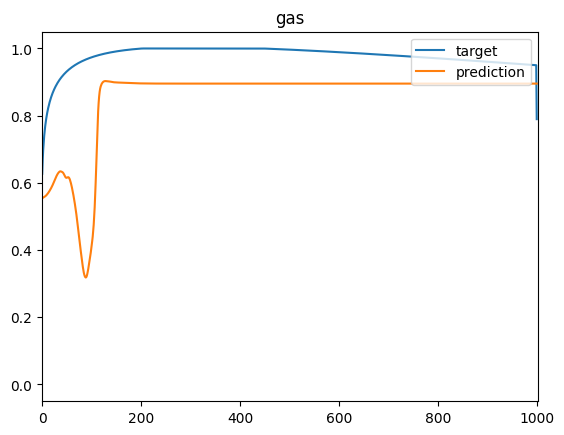

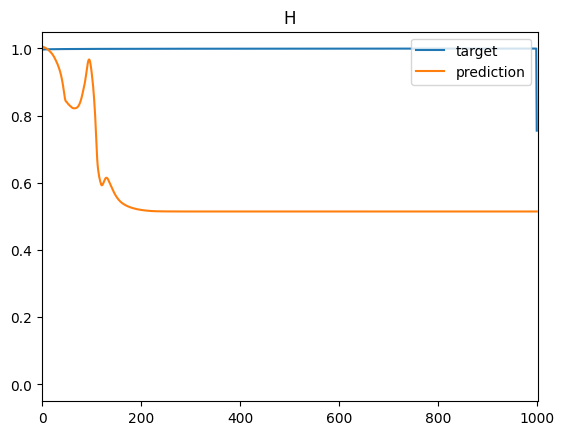

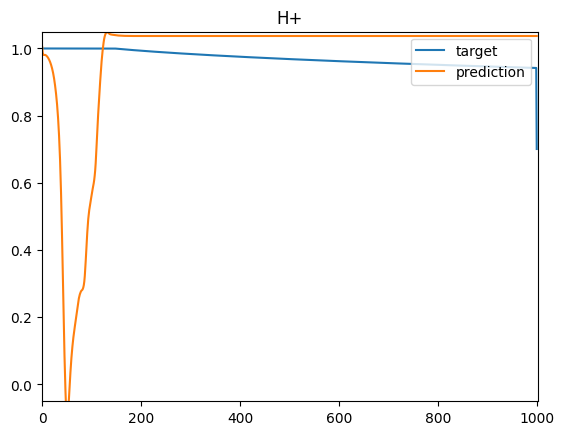

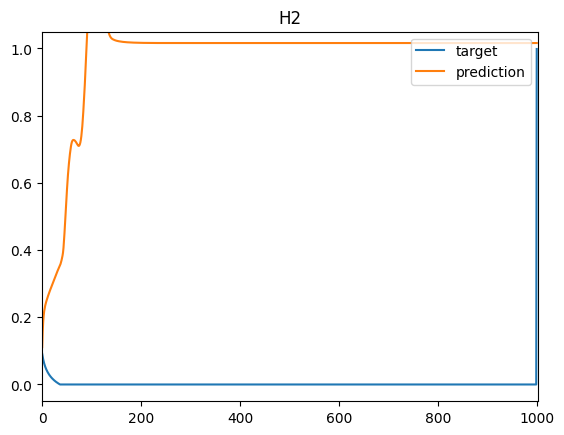

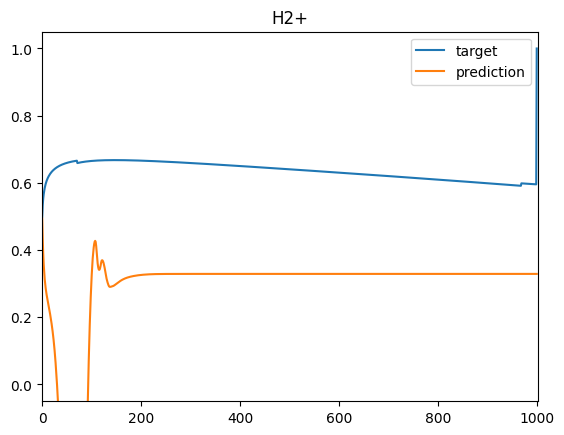

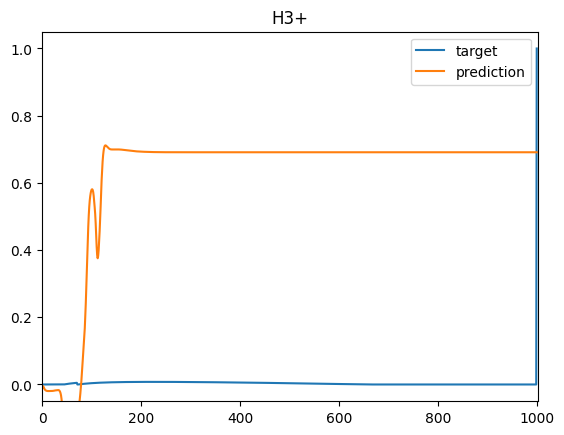

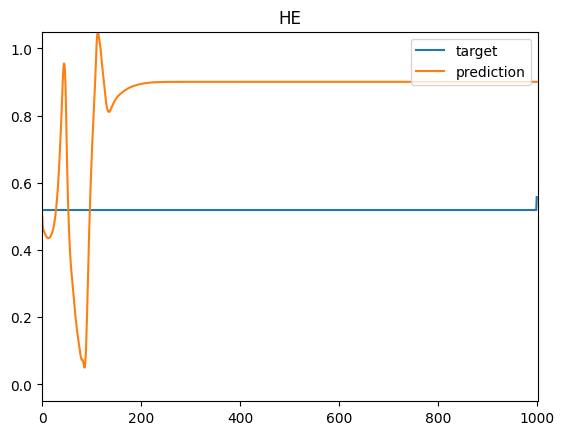

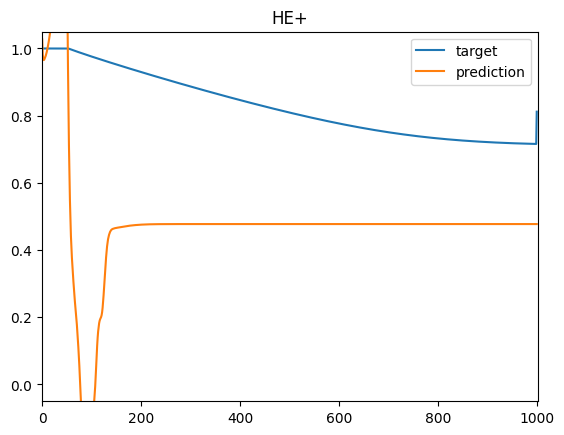

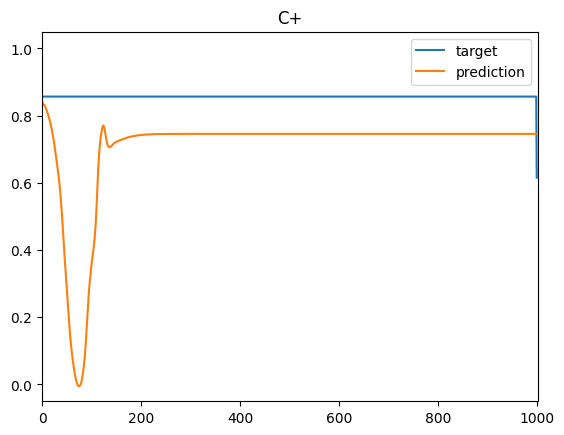

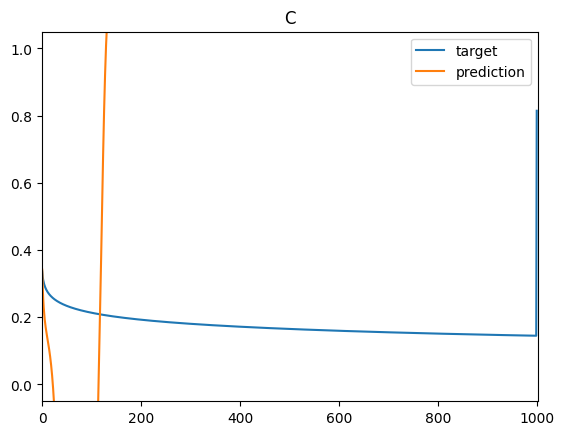

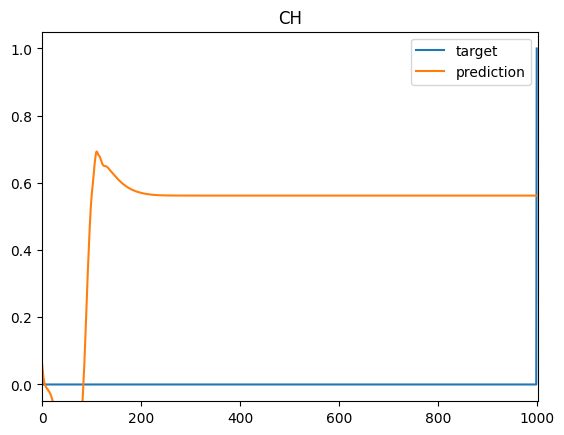

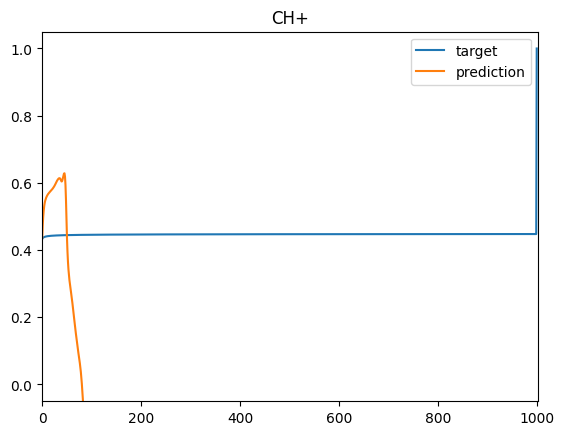

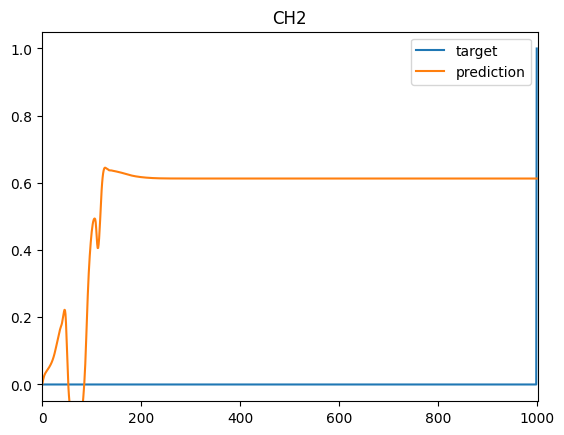

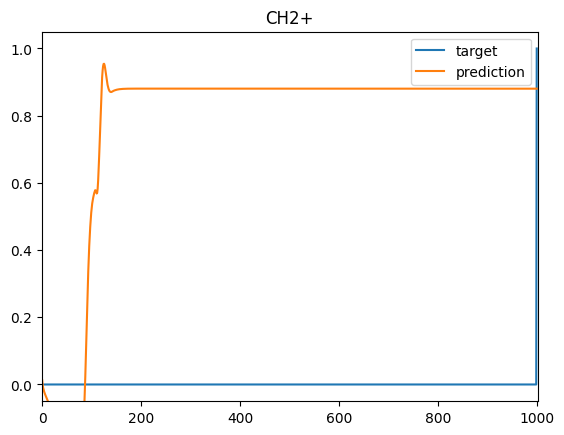

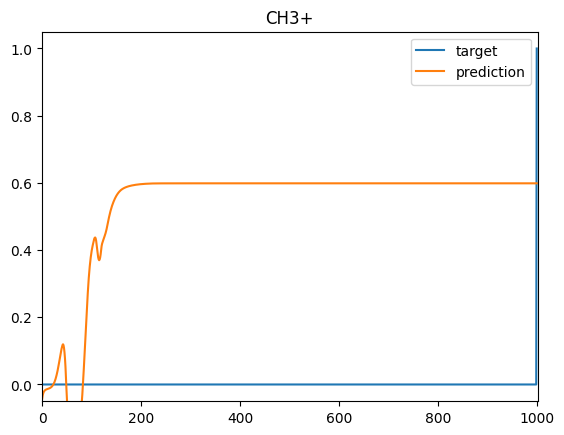

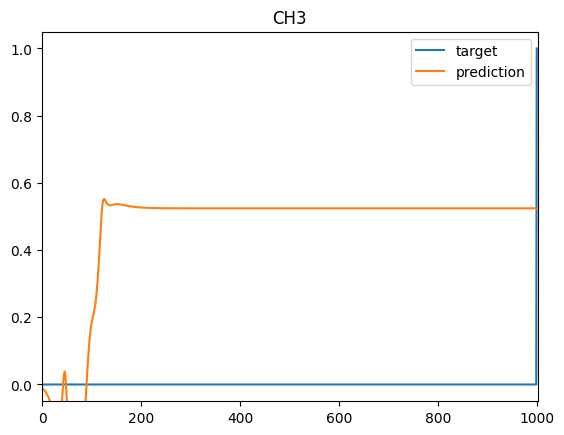

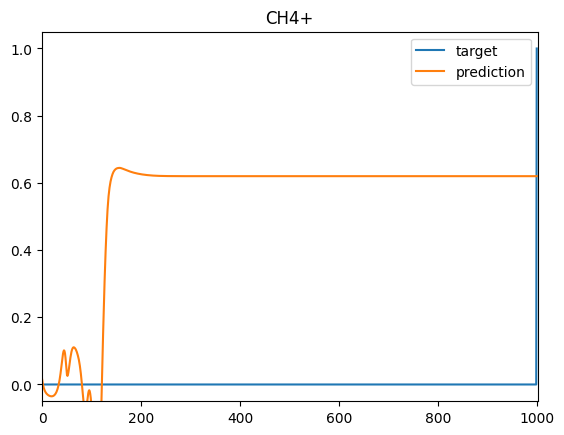

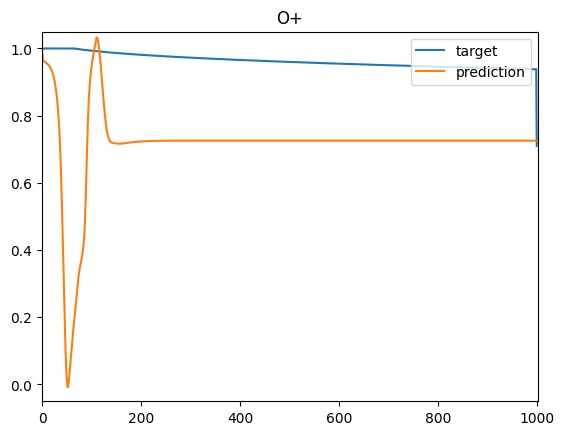

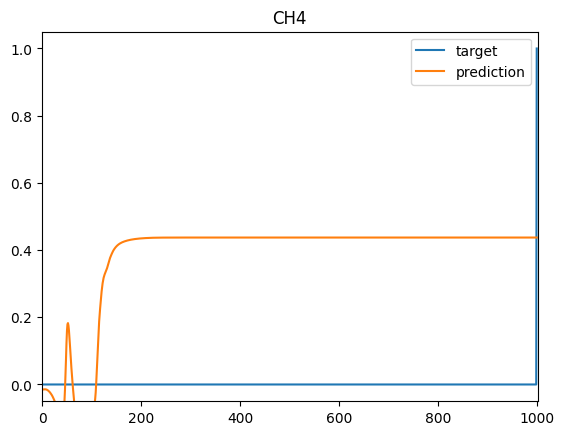

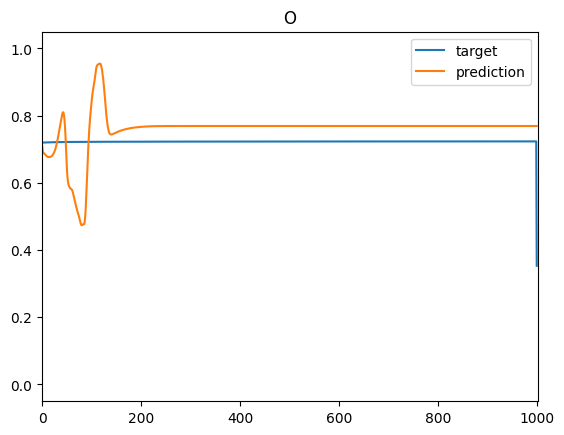

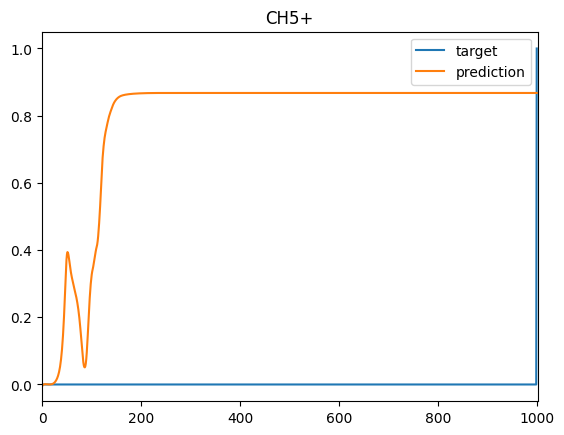

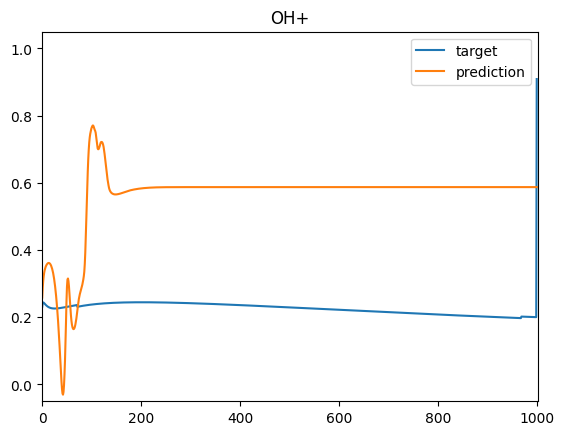

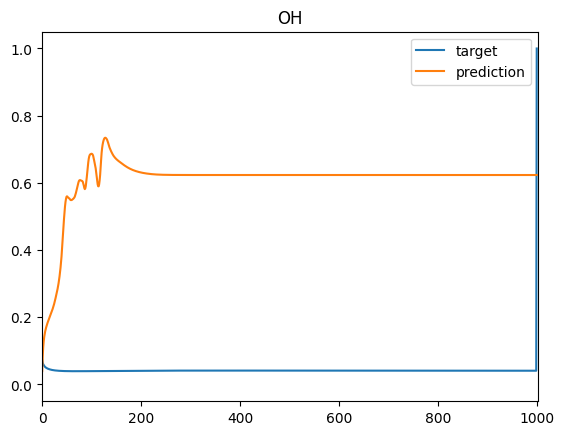

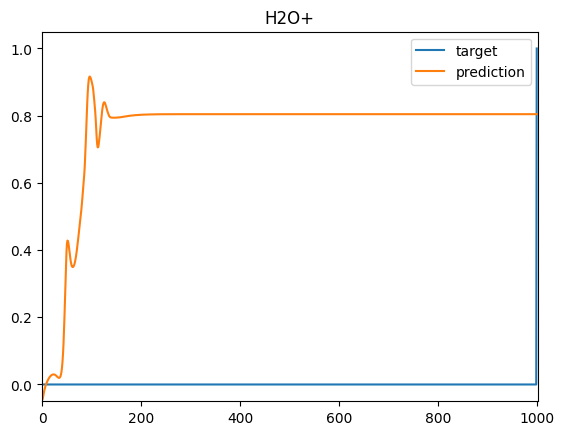

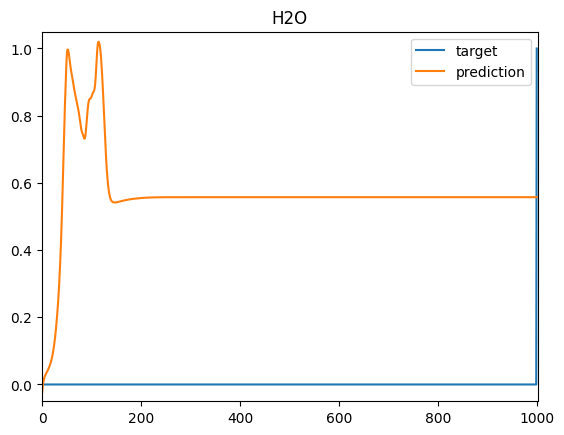

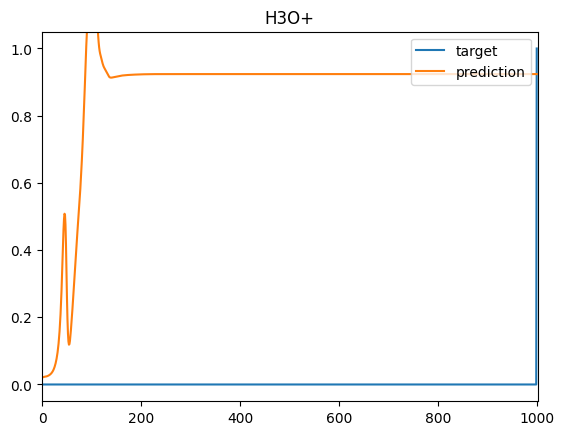

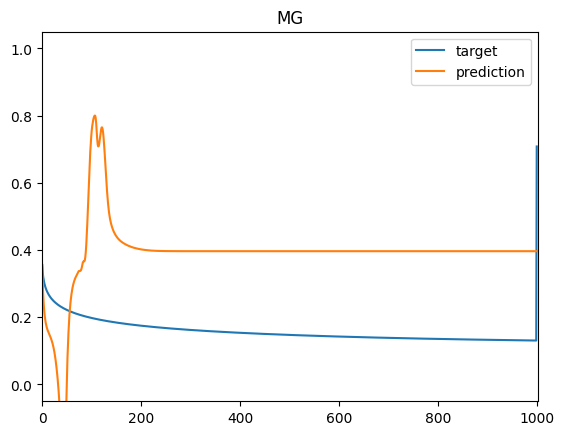

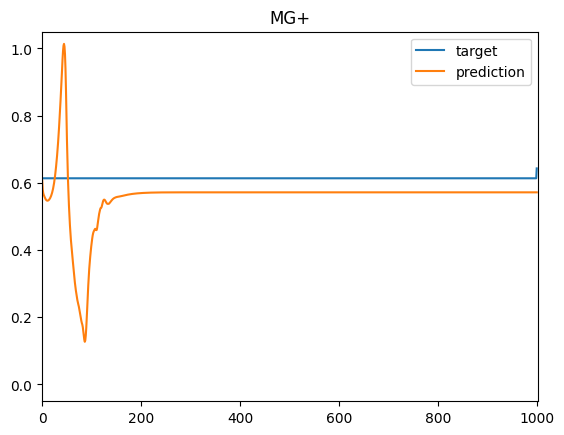

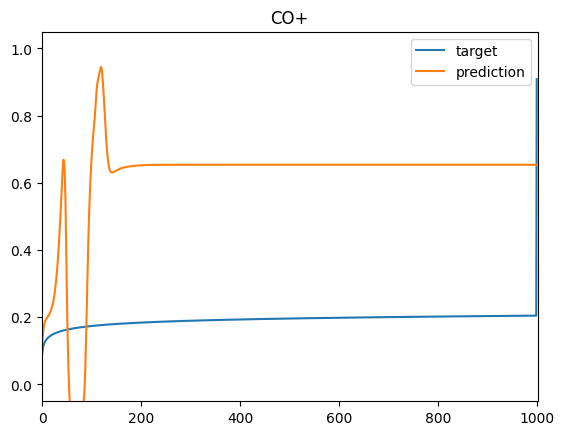

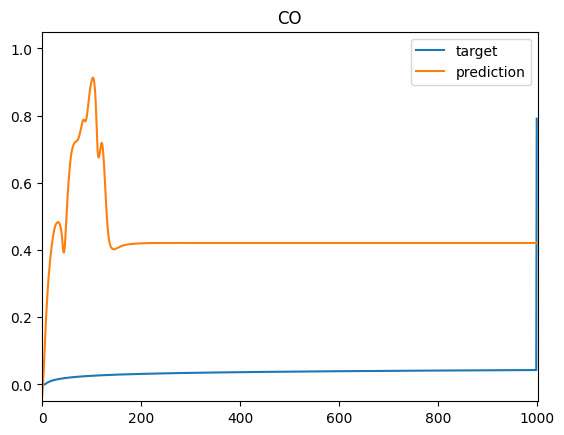

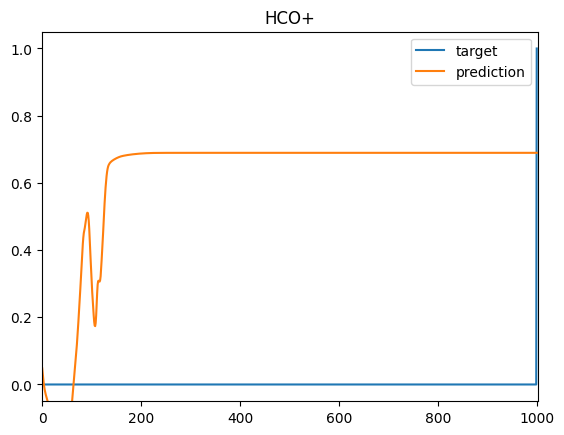

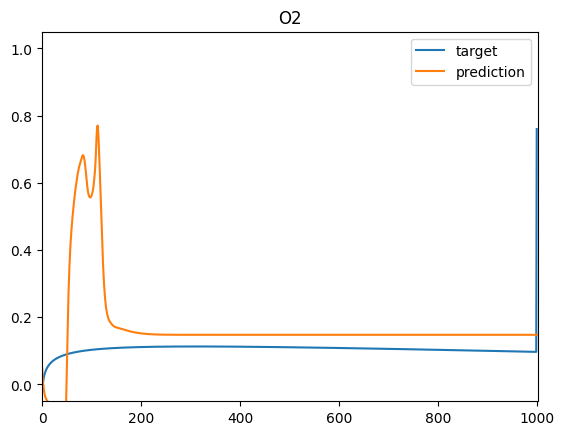

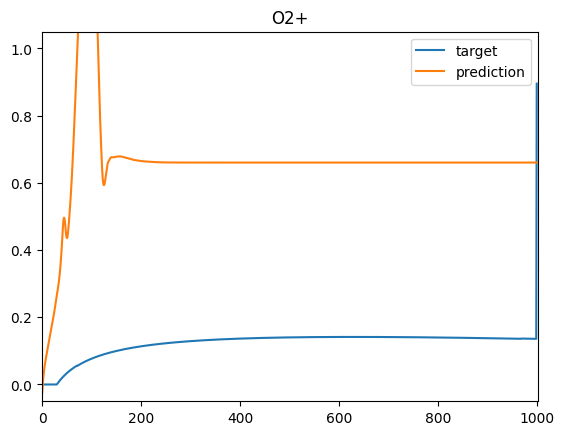

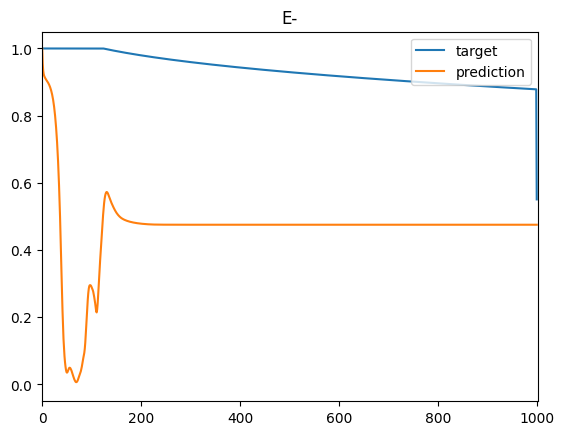

In [17]:
init_idx = 0

init_condition_part = train_ae[init_idx:init_idx+1]
pred_ae = predict_multiple_timesteps(model_ae, init_condition_part, time = 999)

pred_ae = np.stack(pred_ae).reshape(1000, train_ae.shape[1])

pred_ae[:, len(physics_labels):] = (ae_scale.max - ae_scale.min)*pred_ae[:, len(physics_labels):] +ae_scale.min

de_hidden = AE.layers[3](pred_ae[:, len(physics_labels):])
recon_abundances = AE.layers[4](de_hidden)

pred_ae = np.concatenate((pred_ae[:, :len(physics_labels)], recon_abundances), axis = -1)

plt.figure()
plt.plot(train_all_target[init_idx:init_idx+1000, 0], label = 'target')
plt.plot(pred_ae[:, 0],  label = 'prediction')
plt.axis([-1., 1001., -0.05, 1.05])
plt.title('gas')
plt.legend(loc = 1)
for i in range(len(abundances)):
    plt.figure()
    plt.plot(train_all_target[init_idx:init_idx+1000, 1+i], label = 'target')
    plt.plot(pred_ae[:, len(physics_labels)+i], label = 'prediction')
    plt.axis([-1., 1001., -0.05, 1.05])
    plt.title(abundances[i])
    plt.legend(loc = 1)

# 5. Exercise

### Feature extraction using VAE

In this notebook, we used Autoencoders to extracted features and train neural networks with encoded abundances.  
Use a Variational Autoencoders to extract more meaningful features.

- Can you significantly improve the performance?
- Do we need to use $\beta$-vae to balance between reconstruction loss and regulariser?

